# Hello, KAN!

### Kolmogorov-Arnold representation theorem

Kolmogorov-Arnold representation theorem states that if $f$ is a multivariate continuous function
on a bounded domain, then it can be written as a finite composition of continuous functions of a
single variable and the binary operation of addition. More specifically, for a smooth $f : [0,1]^n \to \mathbb{R}$,


$$f(x) = f(x_1,...,x_n)=\sum_{q=1}^{2n+1}\Phi_q(\sum_{p=1}^n \phi_{q,p}(x_p))$$

where $\phi_{q,p}:[0,1]\to\mathbb{R}$ and $\Phi_q:\mathbb{R}\to\mathbb{R}$. In a sense, they showed that the only true multivariate function is addition, since every other function can be written using univariate functions and sum. However, this 2-Layer width-$(2n+1)$ Kolmogorov-Arnold representation may not be smooth due to its limited expressive power. We augment its expressive power by generalizing it to arbitrary depths and widths.

### Kolmogorov-Arnold Network (KAN)

The Kolmogorov-Arnold representation can be written in matrix form

$$f(x)={\bf \Phi}_{\rm out}\circ{\bf \Phi}_{\rm in}\circ {\bf x}$$

where 

$${\bf \Phi}_{\rm in}= \begin{pmatrix} \phi_{1,1}(\cdot) & \cdots & \phi_{1,n}(\cdot) \\ \vdots & & \vdots \\ \phi_{2n+1,1}(\cdot) & \cdots & \phi_{2n+1,n}(\cdot) \end{pmatrix},\quad {\bf \Phi}_{\rm out}=\begin{pmatrix} \Phi_1(\cdot) & \cdots & \Phi_{2n+1}(\cdot)\end{pmatrix}$$

We notice that both ${\bf \Phi}_{\rm in}$ and ${\bf \Phi}_{\rm out}$ are special cases of the following function matrix ${\bf \Phi}$ (with $n_{\rm in}$ inputs, and $n_{\rm out}$ outputs), we call a Kolmogorov-Arnold layer:

$${\bf \Phi}= \begin{pmatrix} \phi_{1,1}(\cdot) & \cdots & \phi_{1,n_{\rm in}}(\cdot) \\ \vdots & & \vdots \\ \phi_{n_{\rm out},1}(\cdot) & \cdots & \phi_{n_{\rm out},n_{\rm in}}(\cdot) \end{pmatrix}$$

${\bf \Phi}_{\rm in}$ corresponds to $n_{\rm in}=n, n_{\rm out}=2n+1$, and ${\bf \Phi}_{\rm out}$ corresponds to $n_{\rm in}=2n+1, n_{\rm out}=1$.

After defining the layer, we can construct a Kolmogorov-Arnold network simply by stacking layers! Let's say we have $L$ layers, with the $l^{\rm th}$ layer ${\bf \Phi}_l$ have shape $(n_{l+1}, n_{l})$. Then the whole network is

$${\rm KAN}({\bf x})={\bf \Phi}_{L-1}\circ\cdots \circ{\bf \Phi}_1\circ{\bf \Phi}_0\circ {\bf x}$$

In constrast, a Multi-Layer Perceptron is interleaved by linear layers ${\bf W}_l$ and nonlinearities $\sigma$:

$${\rm MLP}({\bf x})={\bf W}_{L-1}\circ\sigma\circ\cdots\circ {\bf W}_1\circ\sigma\circ {\bf W}_0\circ {\bf x}$$

A KAN can be easily visualized. (1) A KAN is simply stack of KAN layers. (2) Each KAN layer can be visualized as a fully-connected layer, with a 1D function placed on each edge. Let's see an example below.

## B-Splines for KAN

#### What are Splines?
Splines are a transformation that maps a set of *control points* to a regular, smooth curve. Given a series of such control points, we aim to create a curve that generally follows the shape of these points.

Control points are user-defined, pre-specified points through which the curve must pass.

In constructing this curve, we must stick to several constraints, primarily related to continuity measures such as C1, C2,..., Cn. C1 and C2 measures are specially important in deep learning as we require well-defined functions that can be differentiated to obtain gradients necessary for backpropagation. Several splines have been defined in the literature with varying continuity measures. 

For a comprehensive understanding of splines and continuity measures, I recommend watching [this excellent video on Continuity of Splines](https://www.youtube.com/watch?v=jvPPXbo87ds) by Freya Holmér.

#### What are B-splines?

B-Splines (basis splines) form a class of C2 continuous curves, meaning their second derivatives are continuous and well-defined everywhere. If you were to plot the second derivative, it would be smooth without discontinuities. This fact beautifully lends KANs based on B-splines to be optimized using second-order optimization methods such as LBFGS. 

#### B-Spline Parameters:

A B-spline is defined by two parameters:

1. **Order (k)**: The curve's order.
    - k = 0: Uses the nearest control point directly. This lacks C0 continuity due to abrupt changes.
    - k = 1: Linearly interpolates between two control points.
    - k = 2: Uses a quadratic transformation to account for three control points.
    - k = 3: Applies a cubic transformation using four points, and so forth.


2. **Control Points**: Pre-specified points through which the curve must pass. These points are treated in a conventional sense, much like one would in Euclidean space.


#### How are B-splines used to learn activation functions?

Authors use learnable 2D B-splines to learn activation function for each feature. The features can be the raw input features or the outputs of intermediate layers that are fed into the subsequent layer. The control points (referred to as a `grid`) are specified in 1D. The spline order (often k=3) is fixed. The goal is to manipulate the influence of control points (through learnable coeffecients) to determine the y-values that result in the accurate prediction on the downstream task.

#### B-Splines Mathematically

The workhorse of B-splines are basis functions $N_{i,k}(x): \mathcal{R} \rightarrow \mathcal{R}$ defined for each control point $i$ and the spline-order $k$. For a spline-order $k$, the scalar input $x \in \mathcal{R}$ is converted to "features" using the basis functions. These features are combined using learnable coefficients to result in a scalar output $\in \mathcal{R}$. 

**Cox-De Boor Recursion Formula**

The Cox-De Boor ***recursion formula*** provides a method to calculate the B-spline basis functions of degree $k$. 


**Base Case**

For $k=0$, the basis functions results in a one-hot encoding vector with a value of $1$ at the $i^{th}$ control point $t_i$ less than or equal to the scalar input $x$.

$$
N_{i,0}(x) = 
   \begin{cases} 
   1 & \text{if } t_i \leq x < t_{i+1} \\
   0 & \text{otherwise}
   \end{cases}
$$

If we define M control points, $i \in \{0, 1, 2, ..., M-1\}$, there will be a total of $M$ features corresponding to each scalar input $x$.

**Recursive Step**

The subsequent cases results in features described as follows

$ N_{i,k}(x) = \frac{x - t_i}{t_{i+k} - t_i} N_{i,k-1}(x) + \frac{t_{i+k+1} - x}{t_{i+k+1} - t_{i+1}} N_{i+1,k-1}(x) $

Here, for M control points, $i \in \{0, 1, 2, ..., M-k-1\}$, resulting in a total of $M-k$ basis functions for each scaler input. Authors use the extension of `grid` to increase the control points at the two extremes, resulting in a total of $M$ basis functions and hence $M$ learnable coefficients for each B-spline. We will see the effect of grid extension later in this tutorial.

### Notes:
- The control points $t_i$ must be non-decreasing.
- Each basis function $N_{i,k}(x)$ is non-zero only within the interval $ [t_i, t_{i+k+1}]$.
- ***Why does it generate smooth and continuous curves?***:  The B-spline curves are constructed by linearly combining the basis functions with control points. This also result in continuous curves exhibiting a key property of locality. This means that modifying a specific section of the curve, for example, from \(t_2\) to \(t_5\), does not affect the remainder of the curve. This localized influence is why KANs are resistant to catastrophic forgetting, as the input from various data distributions only impacts the curve locally.



#### B-Splines Programmatically

In this section, we will plot the basis functions to see their behavior as the spline order is increased. 

In [7]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

##### 对应$N_{i,k}(x)$

In [3]:
# 定义控制点
grid = torch.linspace(-1, 1, steps=11)

# we take the entire domain to plot the basis function as a function of x
x = torch.linspace(-1, 1, steps=1000) 

print(f"Grid: Shape:{grid.shape}, values:", grid)
print(f"x: Shape:{x.shape}, values:", x[:5])

# Reshape so that each x can be compared to each control point
grid_ = grid.unsqueeze(dim=0)
x_ = x.unsqueeze(dim=1)

# Base case
k = 0
value1 = (x_ >= grid_[:,:-1]) * (x_ < grid_[:, 1:])

# Other cases
k = 1 # This gives us basis functions for order 1
value21 = (x_ - grid_[:, :-(k+1)]) / (grid_[:, 1:-k] - grid_[:, :-(k+1)]) * value1[:, :-1]
value22 = (grid_[:, (k+1):] - x_) / (grid_[:, (k+1):] - grid_[:, 1:-k]) * value1[:, 1:]
value2 = value21 + value22

k = 2 # This gives us basis functions for order 2
value31 = (x_ - grid_[:, :-(k+1)]) / (grid_[:, 1:-k] - grid_[:, :-(k+1)]) * value2[:, :-1]
value32 = (grid_[:, (k+1):] - x_) / (grid_[:, (k+1):] - grid_[:, 1:-k]) * value2[:, 1:]
value3 = value31 + value32

k = 3 # This gives us basis functions for order 3
value41 = (x_ - grid_[:, :-(k+1)]) / (grid_[:, 1:-k] - grid_[:, :-(k+1)]) * value3[:, :-1]
value42 = (grid_[:, (k+1):] - x_) / (grid_[:, (k+1):] - grid_[:, 1:-k]) * value3[:, 1:]
value4 = value41 + value42

Grid: Shape:torch.Size([11]), values: tensor([-1.0000e+00, -8.0000e-01, -6.0000e-01, -4.0000e-01, -2.0000e-01,
        -1.4901e-08,  2.0000e-01,  4.0000e-01,  6.0000e-01,  8.0000e-01,
         1.0000e+00])
x: Shape:torch.Size([1000]), values: tensor([-1.0000, -0.9980, -0.9960, -0.9940, -0.9920])


In [4]:
print(f"grid_.shape: {grid_.shape}")
print(f"grid_[:, :-(k+1)].shape: {grid_[:, :-(k+1)].shape}")
print(f"value4.shape: {value4.shape}")

grid_.shape: torch.Size([1, 11])
grid_[:, :-(k+1)].shape: torch.Size([1, 7])
value4.shape: torch.Size([1000, 7])


In [5]:
print(f"k=0, number of basis functions: {value1.shape[-1]}")
print(f"k=1, number of basis functions: {value2.shape[-1]}")
print(f"k=2, number of basis functions: {value3.shape[-1]}")
print(f"k=3, number of basis functions: {value4.shape[-1]}")

k=0, number of basis functions: 10
k=1, number of basis functions: 9
k=2, number of basis functions: 8
k=3, number of basis functions: 7


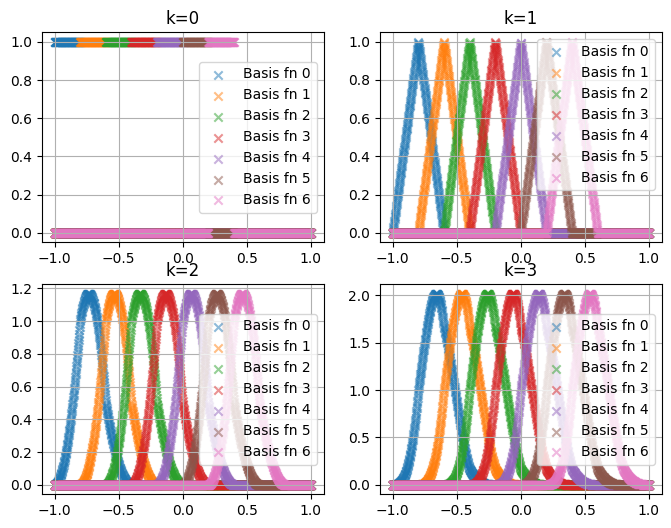

In [6]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(8, 6))

n_basis_to_plot = 7
all_basis = [(value1, 'k=0'), (value2, 'k=1'), (value3, 'k=2'), (value4, 'k=3')]
for i in range(4):
    
    ax = axs[i // 2, i % 2]

    value, label = all_basis[i]
    for idx in range(value.shape[-1])[:n_basis_to_plot]:
        ax.scatter(x, value[:, idx], marker='x', label=f"Basis fn {idx}", alpha=0.5)
    ax.grid()
    ax.set_title(label)
    ax.legend()

**Observations**

- There are a total of $\#control\_points - k - 1$ basis functions. Think of these basis functions as features for a particular scalar input. 
- Each basis function is non-zero over a specific range, defined by the corresponding control points
- $K = 0$ has step basis functions as expected for one-hot encoded vectors
- $K = 1$ has piecewise linear basis functions
- $K \geq 2$ has non-linear basis functions
- $K=2$ and $K=3$ looks same, but are they? Let's look at the max non-zero values in both the cases

In [18]:
import collections
# value3 is [number of samples, number of basis functions]
# we check how many of the cols are nonzero corresp. to each sample

value3_counts = collections.Counter(torch.where(value3 !=0)[0].tolist())
value4_counts = collections.Counter(torch.where(value4 !=0)[0].tolist())

print('min non-zero values in k=2: ',min(value3_counts.values()))
print('max non-zero values in k=2: ',max(value3_counts.values()))
print('min non-zero values in k=3: ',min(value4_counts.values()))
print('max non-zero values in k=3: ',max(value4_counts.values()))

min non-zero values in k=2:  1
max non-zero values in k=2:  3
min non-zero values in k=3:  1
max non-zero values in k=3:  4


#### Extending the Grid for B-Splines Programatically

并非所有输入都具有相同数量的非零基函数。例如，输入域边界附近的基函数通常具有较少的非零基函数。为了解决这个问题，作者扩展了网格，确保输入域内的所有特征具有相等数量的非零基函数

The grid is extended by $k$ control points on each side, allowing the points at the extremes to have the same number of basis functions as those within the central part of the domain.

Next, let's explore how this extension is implemented programmatically. We extend grid once in the beginning of the evaluation. 

In [19]:
# extend grid (pseudocode)
grid = torch.linspace(-1, 1, steps=5)
print('old grid:', grid, grid.shape)
k = 2
n_intervals = grid.shape[0] - 1
bucket_size = (grid[-1] - grid[0]) / n_intervals

for i in range(k):
    grid = torch.cat([grid[:1] - bucket_size, grid], dim=0)
    grid = torch.cat([grid, grid[-1:] + bucket_size], dim=0)
print('new grid:', grid, grid.shape)

old grid: tensor([-1.0000, -0.5000,  0.0000,  0.5000,  1.0000]) torch.Size([5])
new grid: tensor([-2.0000, -1.5000, -1.0000, -0.5000,  0.0000,  0.5000,  1.0000,  1.5000,
         2.0000]) torch.Size([9])


In [2]:
def extend_grid(grid, k):
    """
    Extends the grid on either size by k steps

    Args:
        grid: number of splines x number of control points
        k: spline order

    Returns:
        new_grid: number of splines x (number of control points + 2 * k)
    """
    n_intervals = grid.shape[-1] - 1
    bucket_size = (grid[:, -1] - grid[:, 0]) / n_intervals
    
    for i in range(k):
        grid = torch.cat([grid[:, :1] - bucket_size, grid], dim=-1)
        grid = torch.cat([grid, grid[:, -1:] + bucket_size], dim=-1)

    return grid
    

用扩展网格重做上述练习

In [3]:
def eval_basis_functions(x_eval, grid, k):
    """
    Returns the value of basis functions defiend for order-k splines and control points defined in `grid`. 

    Args:
        x_eval: number of samples x number of dimensions (number of samples, number of dimensions)
        # grid: number of splines x number of control points (number of splines, number of control points)
        grid: number of dimensions x number of control points (number of dimensions, number of control points)
        k (scalar): order of spline

    Returns:
        bases: number of samples x number of dimensions x number of basis functions (number of samples, number of dimensions, number of basis functions)
    """
    grid_ = extend_grid(grid, k)
    # Reshape so that each x can be compared to each control point
    grid_ = grid_.unsqueeze(dim=2)
    x_ = x_eval.unsqueeze(dim=1)
    
    for idx in range(k+1):
        if idx == 0:
            bases = (x_ >= grid_[:, :-1]) * (x_ < grid_[:, 1:]).to(x_eval.dtype) # step function; for each x in between the corresponding knots, the value is 1.
        else:
            bases1 = (x_ - grid_[:, :-(idx+1)]) / (grid_[:, 1:-idx] - grid_[:, :-(idx+1)]) * bases[:, :-1]
            bases2 = (grid_[:, (idx+1):] - x_) / (grid_[:, (idx+1):] - grid_[:, 1:-idx]) * bases[:, 1:]
            bases = bases1 + bases2

    return bases.transpose(1, 2).to(x_eval.dtype)

In [38]:
grid = torch.linspace(-1, 1, steps=10)  # (10)
x = torch.linspace(-1, 1, steps=1000) # (1000) we take the entire domain to plot the basis function as a function of x

print(f"Grid: Shape:{grid.shape}")
print(f"x: Shape:{x.shape}")

# Reshape so that each x can be compared to each control point
grid_ = grid.expand(2, -1)   # (2, 10)
x_ = x.expand(2, -1).T  # (1000, 2)
print(f"Grid_: Shape:{grid_.shape}")
print(f"x_.shape: {x_.shape}")

grid1 = extend_grid(grid_, 1)   # (2, 14), k=1
print(f"Grid1: Shape:{grid1.shape}")
# # Reshape so that each x can be compared to each control point
# grid1_ = grid1.unsqueeze(dim=2)  # (2, 14, 1)
x1_ = x_.unsqueeze(dim=2)  # (1000, 2, 1)
# print(f"Grid1_: Shape:{grid1_.shape}")
print(f"x1_: Shape:{x1_.shape}")

bases = (x1_ >= grid1[:, :-1]) * (x1_ < grid1[:, 1:]).to(x.dtype)
print(f"Bases: Shape:{bases.shape}")
print(f"grid1[:, :-1].shape: {grid1[:, :-1].shape}")

Grid: Shape:torch.Size([10])
x: Shape:torch.Size([1000])
Grid_: Shape:torch.Size([2, 10])
x_.shape: torch.Size([1000, 2])
Grid1: Shape:torch.Size([2, 14])
x1_: Shape:torch.Size([1000, 2, 1])
Bases: Shape:torch.Size([1000, 2, 13])
grid1[:, :-1].shape: torch.Size([2, 13])


Grid: Shape:torch.Size([10]), values: tensor([-1.0000, -0.7778, -0.5556, -0.3333, -0.1111,  0.1111,  0.3333,  0.5556,
         0.7778,  1.0000])
x: Shape:torch.Size([1000]), values: tensor([-1.0000, -0.9980, -0.9960, -0.9940, -0.9920])
k=0, number of basis functions: 9
k=1, number of basis functions: 10
k=2, number of basis functions: 11
k=3, number of basis functions: 12


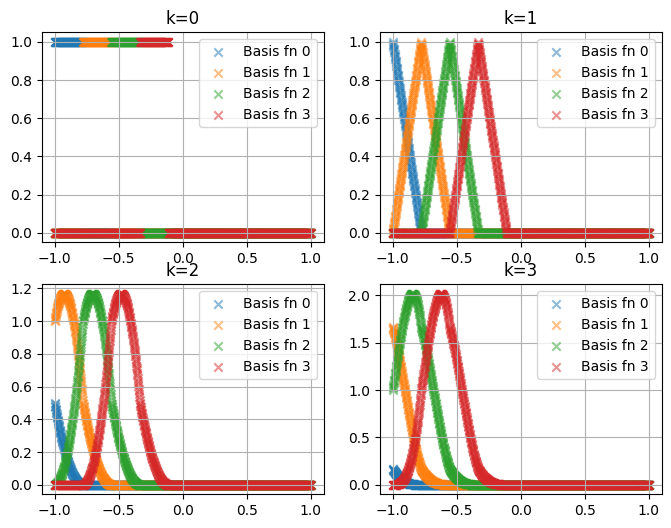

In [44]:
grid = torch.linspace(-1, 1, steps=10)  # (10)
x = torch.linspace(-1, 1, steps=1000) # (1000) we take the entire domain to plot the basis function as a function of x

print(f"Grid: Shape:{grid.shape}, values:", grid)
print(f"x: Shape:{x.shape}, values:", x[:5])

# Reshape so that each x can be compared to each control point
grid_ = grid.unsqueeze(dim=0)   # (1, 10)
x_ = x.unsqueeze(dim=1)  # (1000, 1)


value1 = eval_basis_functions(x_, grid_, k=0)

value2 = eval_basis_functions(x_, grid_, k=1)

value3 = eval_basis_functions(x_, grid_, k=2)

value4 = eval_basis_functions(x_, grid_, k=3)

print(f"k=0, number of basis functions: {value1.shape[-1]}")
print(f"k=1, number of basis functions: {value2.shape[-1]}")
print(f"k=2, number of basis functions: {value3.shape[-1]}")
print(f"k=3, number of basis functions: {value4.shape[-1]}")


fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(8, 6), dpi=100)

n_basis_to_plot = 4
all_basis = [(value1, 'k=0'), (value2, 'k=1'), (value3, 'k=2'), (value4, 'k=3')]
for i in range(4):
    
    ax = axs[i // 2, i % 2] 

    value, label = all_basis[i]
    for idx in range(value.shape[-1])[:n_basis_to_plot]:  
        ax.scatter(x, value[:, 0, idx], marker='x', label=f"Basis fn {idx}", alpha=0.5)
    ax.grid()
    ax.set_title(label)
    ax.legend()

Finally, we see that even the boundary points get the same number of non-zero basis functions.

#### Learning the Activation Function, i.e., Coefficients

Now, let's explore whether we can learn the coefficients to emulate certain well-defined functions, with or without noise.

Formally, we define $ f(x) = \sum_{i=0}^{n} c_i \cdot N_{i, k}(x) = \sum_{i=0}^{n} c_i \cdot N_i(x) $.

Given $ x $, we will compute $ N_i(x) $ deterministically. Since we already have a predefined $ f(x) $, this presents a straightforward linear equation model to solve these equations: $ \min_{\mathbf{c}} |\mathbf{Nc} - f(x)| $. We will use `torch.linalg.lstsq` to solve for $ \mathbf{c} $.

Next, let's explore how to use a zero-order spline for predictions.

In [60]:
fn = lambda x: torch.sin(torch.pi * x) # define a function that we need to match
coeff1 = torch.linalg.lstsq(value1.squeeze(1), fn(x)).solution
coeff1

tensor([-3.3222e-01, -8.4700e-01, -9.6457e-01, -6.2745e-01, -5.2835e-09,
         6.2745e-01,  9.6439e-01,  8.5008e-01,  3.3801e-01])

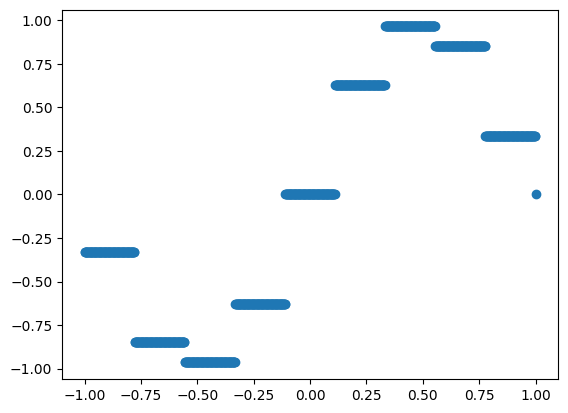

In [61]:
# y_pred = torch.einsum('i, ji -> j', coeff1, value1.squeeze(1)) # use these coefficients to evaluate y
y_pred = torch.einsum('ji, i -> j', value1.squeeze(1), coeff1)
plt.scatter(x, y_pred)

#### How does $k$ impact the learning accuracy?

Let's see the effect of order on estimations of various functions.

We consider two functions -- 
1. $\sin(\pi \times x)$
2. $\sin(\pi \times e^{x})$

We consider four values of $k \in \{0, 1, 2, 3\}$.

**Case 1:** When we don't extend the grid

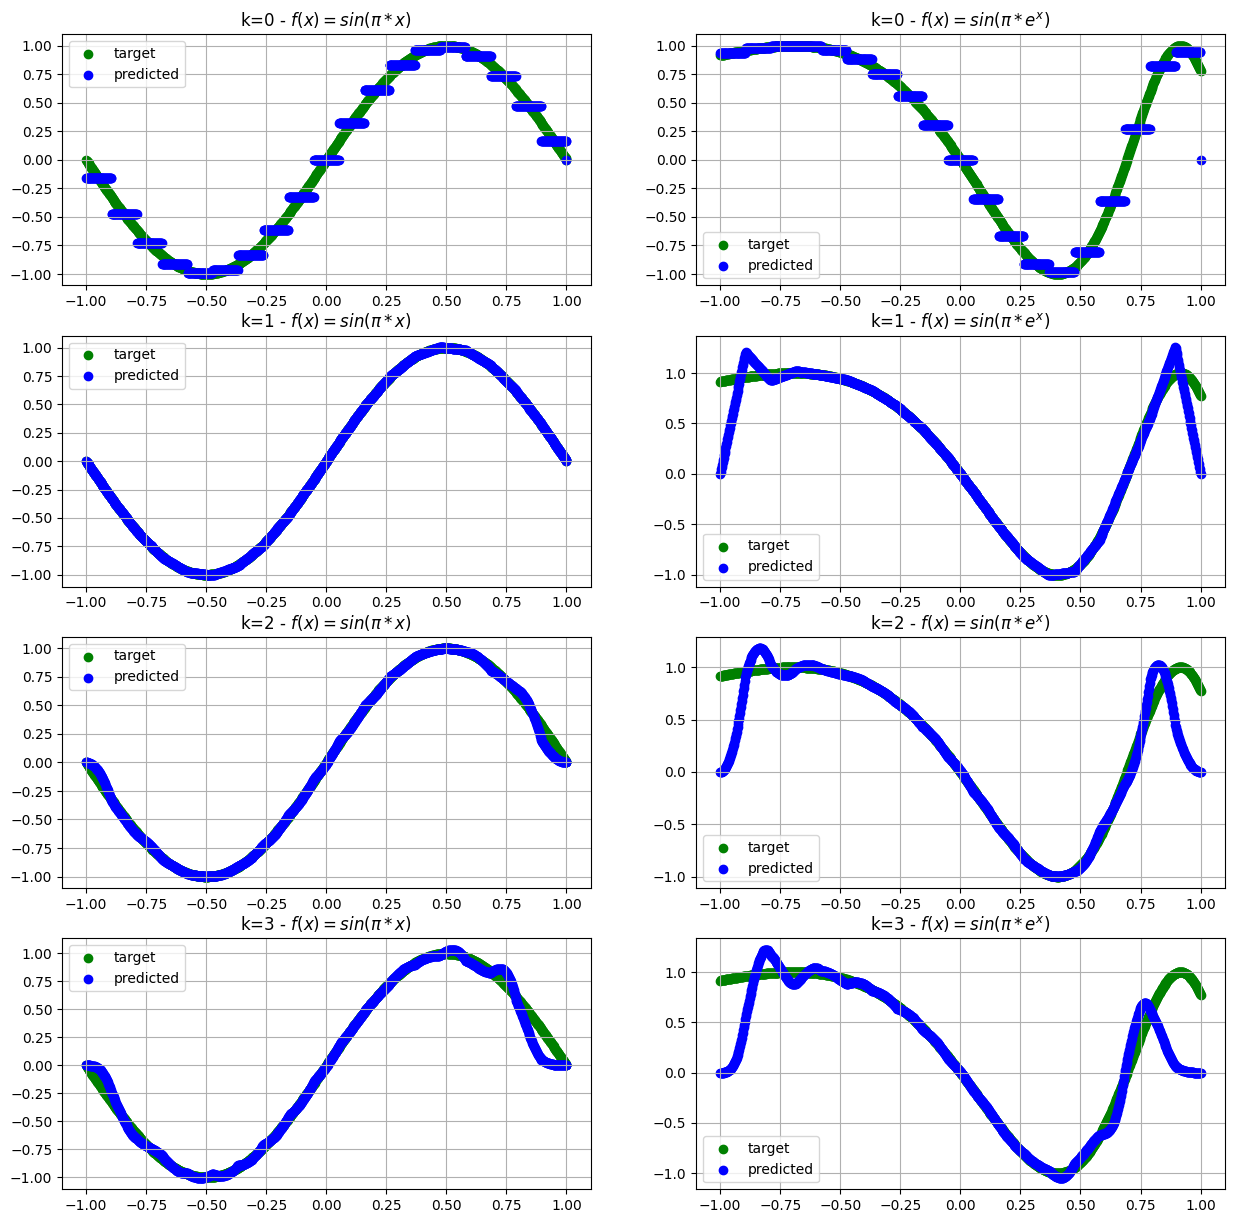

In [65]:
# notice the increase in the grid points to 100
grid = torch.linspace(-1, 1, steps=20)
x = torch.linspace(-1, 1, steps=1000) # we take the entire domain to plot the basis function as a function of x

# Reshape so that each x can be compared to each control point
grid_ = grid.unsqueeze(dim=0)
x_ = x.unsqueeze(dim=1)

k = 0 # This gives us basis functions for order 0
value1 = (x_ >= grid_[:,:-1]) * (x_ < grid_[:, 1:])

k = 1 # This gives us basis functions for order 1
value21 = (x_ - grid_[:, :-(k+1)]) / (grid_[:, 1:-k] - grid_[:, :-(k+1)]) * value1[:, :-1]
value22 = (grid_[:, (k+1):] - x_) / (grid_[:, (k+1):] - grid_[:, 1:-k]) * value1[:, 1:]
value2 = value21 + value22

k = 2 # This gives us basis functions for order 2
value31 = (x_ - grid_[:, :-(k+1)]) / (grid_[:, 1:-k] - grid_[:, :-(k+1)]) * value2[:, :-1]
value32 = (grid_[:, (k+1):] - x_) / (grid_[:, (k+1):] - grid_[:, 1:-k]) * value2[:, 1:]
value3 = value31 + value32

k = 3 # This gives us basis functions for order 3
value41 = (x_ - grid_[:, :-(k+1)]) / (grid_[:, 1:-k] - grid_[:, :-(k+1)]) * value3[:, :-1]
value42 = (grid_[:, (k+1):] - x_) / (grid_[:, (k+1):] - grid_[:, 1:-k]) * value3[:, 1:]
value4 = value41 + value42

# 初始化空列表 fns
fns = []
# 添加第一个函数及其标签
# 使用 += 操作符将每个函数及其标签的元组添加到列表 fns 中
fns += [(lambda x: torch.sin(torch.pi * x), '$f(x) = sin(\pi*x)$')]
# 添加第二个函数及其标签
fns += [(lambda x: torch.sin(torch.pi * torch.exp(x)), '$f(x) = sin(\pi*e^{x})$')]

all_basis = [(value1 * 1.0, 'k=0'), (value2, 'k=1'), (value3, 'k=2'), (value4, 'k=3')]

fig, axs = plt.subplots(ncols=len(fns), nrows=len(all_basis), figsize=(15, 15))

for i in range(len(all_basis)):
    for j in range(len(fns)):
    
        ax = axs[i, j] 
        value, label = all_basis[i]
        fn, fn_label = fns[j]
        
        coeff = torch.linalg.lstsq(value, fn(x)).solution # find the coefficients 
        y_pred = torch.einsum('ji, i -> j', value, coeff) # use these coefficients to evaluate y
        
        ax.scatter(x, fn(x), color='green', label='target')
        ax.scatter(x, y_pred, color='blue', label="predicted")

        ax.grid()
        ax.set_title(f"{label} - {fn_label}")
        ax.legend()

**Observations**

1. 随着k的增加，由于边界效应边界附近的拟合并不完美。这些区域边界点不足。这个问题可以通过增加控制点的数量来最小化。
2. 随着k的增加，在域的中间，拟合显著提高。

**Case 2:** When we extend the grid on either side

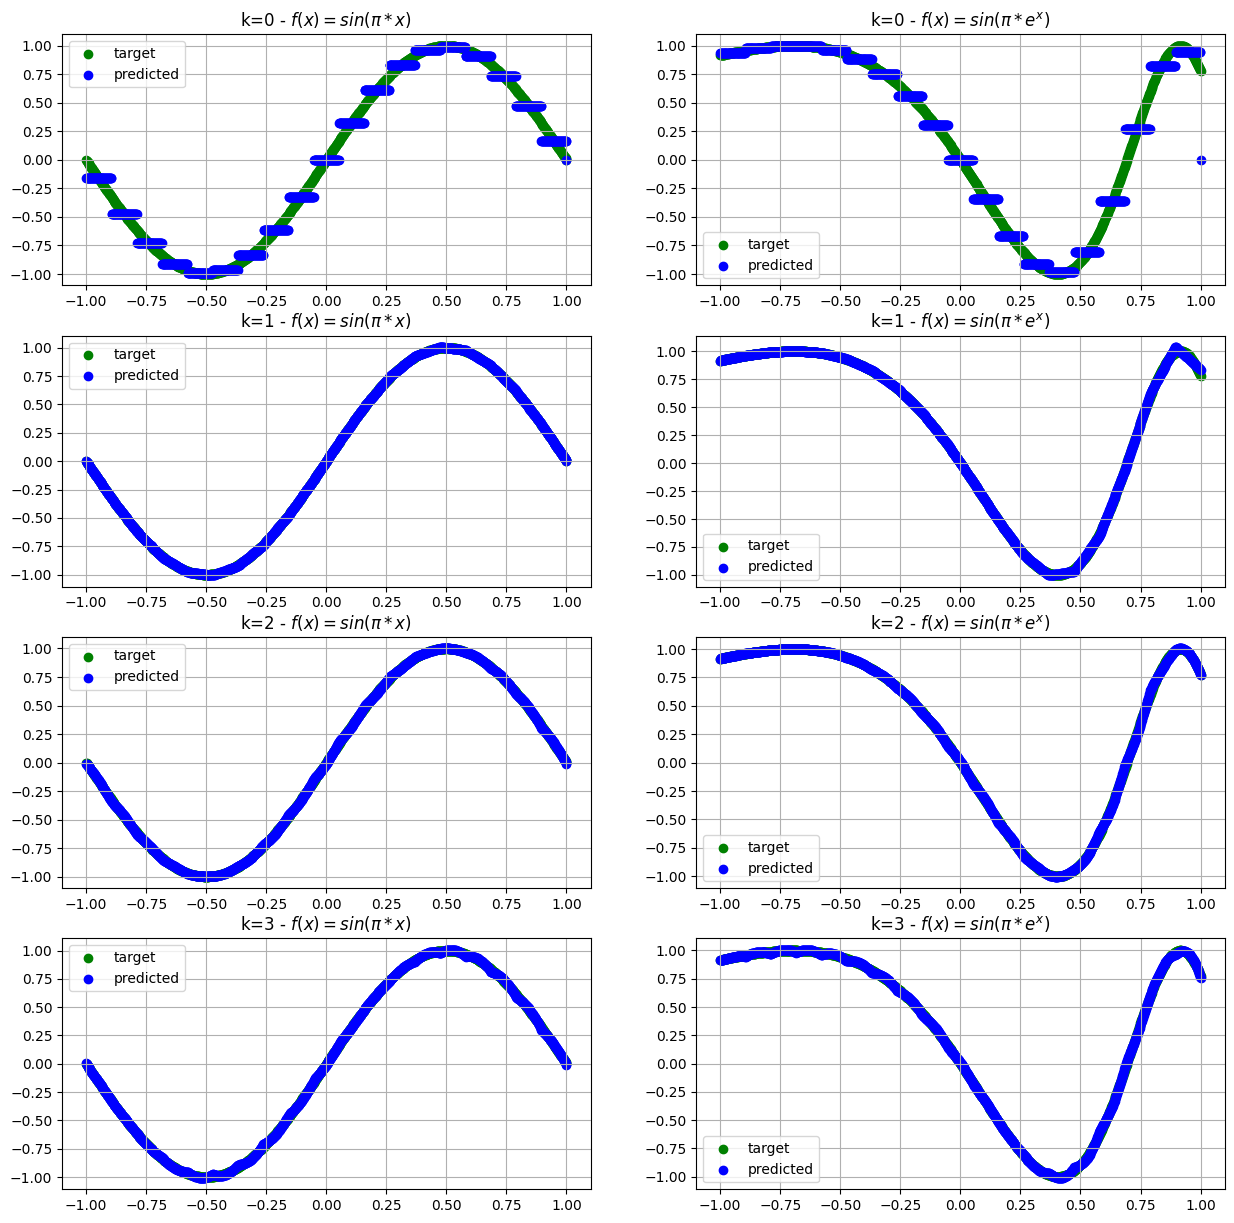

In [66]:
fns = []
fns += [(lambda x: torch.sin(torch.pi * x), '$f(x) = sin(\pi*x)$')]
fns += [(lambda x: torch.sin(torch.pi * torch.exp(x)), '$f(x) = sin(\pi*e^{x})$')]

all_basis = [
        (eval_basis_functions(x_, grid_, k=0), 'k=0'), 
        (eval_basis_functions(x_, grid_, k=1), 'k=1'), 
        (eval_basis_functions(x_, grid_, k=2), 'k=2'), 
        (eval_basis_functions(x_, grid_, k=3), 'k=3')
]

fig, axs = plt.subplots(ncols=len(fns), nrows=len(all_basis), figsize=(15, 15), dpi=100)

for i in range(len(all_basis)):
    for j in range(len(fns)):
    
        ax = axs[i, j] 
        value, label = all_basis[i]
        fn, fn_label = fns[j]
        
        coeff = torch.linalg.lstsq(value.squeeze(1), fn(x)).solution # find the coefficients 
        y_pred = torch.einsum('ji, i -> j', value.squeeze(1), coeff)    # use these coefficients to evaluate y
        
        ax.scatter(x, fn(x), color='green', label='target')
        ax.scatter(x, y_pred, color='blue', label="predicted")

        ax.grid()
        ax.set_title(f"{label} - {fn_label}")
        ax.legend()

增加控制点可以提高边界附近的整体拟合度

**Case 3:** Usually, the real data is messy. How will the noise in the function estimation look like?

In [68]:
y_target = fn(x)
y_target.shape, value.shape

(torch.Size([1000]), torch.Size([1000, 1, 22]))

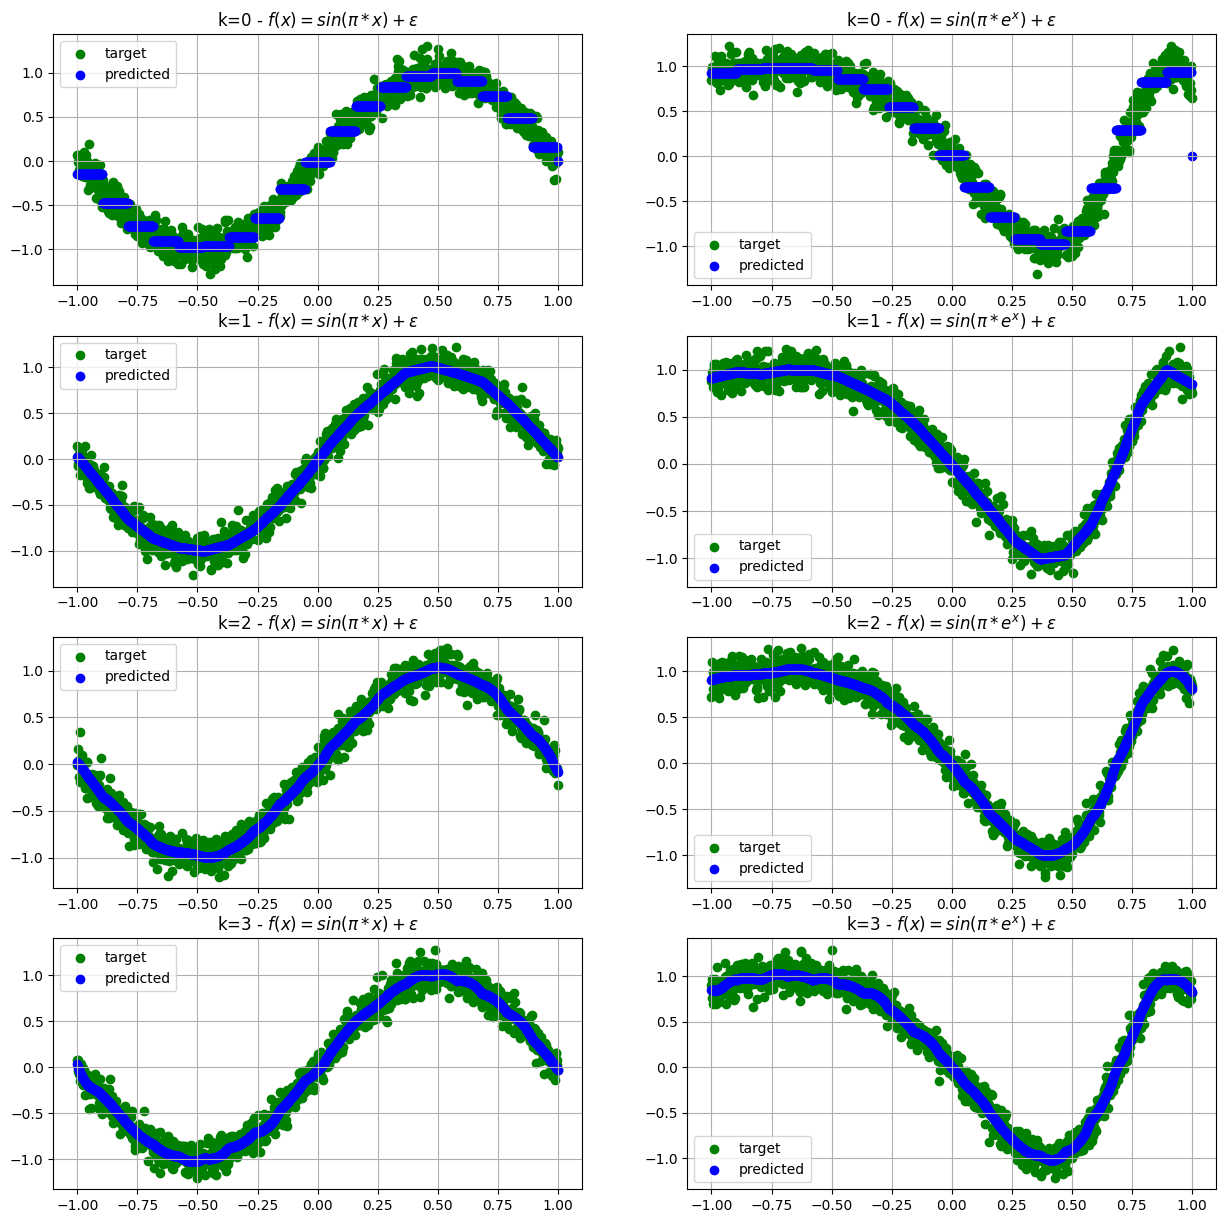

In [69]:
fns = []
fns += [(lambda x: torch.sin(torch.pi * x) + 0.1 * torch.randn(x.shape), '$f(x) = sin(\pi*x) + \epsilon$')]
fns += [(lambda x: torch.sin(torch.pi * torch.exp(x)) + 0.1 * torch.randn(x.shape), '$f(x) = sin(\pi*e^{x}) + \epsilon$')]

all_basis = [
        (eval_basis_functions(x_, grid_, k=0), 'k=0'), 
        (eval_basis_functions(x_, grid_, k=1), 'k=1'), 
        (eval_basis_functions(x_, grid_, k=2), 'k=2'), 
        (eval_basis_functions(x_, grid_, k=3), 'k=3')
]

fig, axs = plt.subplots(ncols=len(fns), nrows=len(all_basis), figsize=(15, 15), dpi=100)

for i in range(len(all_basis)):
    for j in range(len(fns)):
    
        ax = axs[i, j] 
        value, label = all_basis[i]
        fn, fn_label = fns[j]

        y_target = fn(x)
        coeff = torch.linalg.lstsq(value.squeeze(1), y_target).solution # find the coefficients 
        y_pred = torch.einsum('i, ji -> j', coeff, value.squeeze(1)) # use these coefficients to evaluate y
        
        ax.scatter(x, y_target, color='green', label='target')
        ax.scatter(x, y_pred, color='blue', label="predicted")

        ax.grid()
        ax.set_title(f"{label} - {fn_label}")
        ax.legend()

#### Summary

1.我们学习了如何使用控制点和样条阶数定义B样条。

2.我们探索了使用B样条学习任意激活函数的概念。

3.我们研究了控制点和样条阶数对函数拟合精度的影响

This tutorial explored a [1, 1] KAN network configuration, which consisted of one input (first index), one output (last index), and one spline activation function in the middle.

#### What's Next?

We will expand our exploration to see how two units can be stacked on top of each other resulting in [1, 1, 1] KAN network configuration.

## Deeper KANs: [1, 1, 1, ..., 1] KANs

This is Part 2 of the tutorial series on KAN. In Part 1, we learned about the fundamental component of KANs that involves learning activation functions using B-splines.

In this tutorial, we will explore how to construct a network with such units and how to learn the coefficients. 
1. We will begin with a single input processed using two spline activation functions stacked on top of each other.
2. We will explore how to approach backpropagation through the stacked splines.

**Note:** The functions created in Part 1 have been copied in `utils/utils_class.py`

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

from utils.utilis_class import eval_basis_functions

### Warm-up

Let's start by evaluating basis functions for some inputs and learn how to fit a function by determining the best coefficients to combine these basis functions.

**Caution:** We will be doing batch operations, so we must take care of indices. 
1. We expect x_eval to be ***number of samples x number of dimensions***
2. We expect grid to be ***number of activation functions x number of control points***. We consider only one activation function. 
3. We expect to receive output resembling ***number of samples x number of dimensions x number of basis functions***
4. So we expect coefficients to be ***number of dimensions x number of basis functions***

In [2]:
# Let's see it in action
k = 2
x_eval = torch.linspace(-1, 1, steps=20).unsqueeze(dim=1) # (number of samples, number of dimensions) each point is a sample
grid = torch.linspace(-1, 1, steps=10).unsqueeze(dim=0) # (number of dimensions, number of grid points) there is only one spline here

bases = eval_basis_functions(x_eval, grid, k)   # (number of samples, number of dimensions, number of basis functions)
bases.shape

torch.Size([20, 1, 11])

In [4]:
bases.transpose(0, 1).shape

torch.Size([1, 20, 11])

In [6]:
fn = lambda x: torch.sin(torch.pi * torch.exp(x))
y_eval = fn(x_eval) + torch.randn(x_eval.shape) * 0.4
print(y_eval.shape)

# returns coeff for each dimension
coeff = torch.linalg.lstsq(bases.transpose(0, 1), y_eval.unsqueeze(dim=0)).solution
coeff.shape # (number of dimension, number of basis functions, 1)

torch.Size([20, 1])


torch.Size([1, 11, 1])

In [7]:
coeff.shape

torch.Size([1, 11, 1])

Shapes:
Input bases: torch.Size([1, 20, 11])
Y_eval: torch.Size([1, 20, 1])
Ceofficients: torch.Size([1, 11, 1])


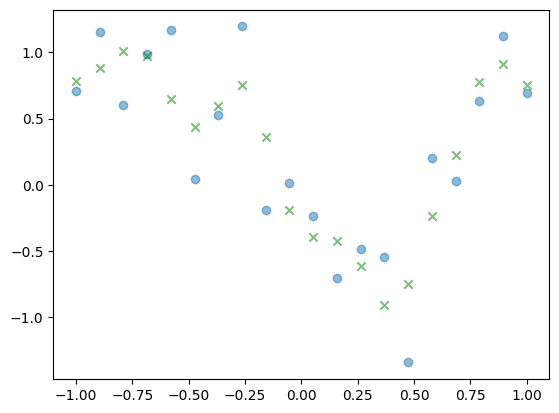

In [6]:
fn = lambda x: torch.sin(torch.pi * torch.exp(x))
y_eval = fn(x_eval) + torch.randn(x_eval.shape) * 0.4

# returns coeff for each dimension
# bases.transpose(0, 1).shape: (number of dimensions, number of samples, number of basis functions) = (1, 20, 11)
# y_eval.unsqueeze(dim=0).shape: (1, number of samples, number of dimensions) = (1, 20, 1)
# coeff.shape: (1, number of basis functions, number of dimensions) = (1, 11, 1)
coeff = torch.linalg.lstsq(bases.transpose(0, 1), y_eval.unsqueeze(dim=0)).solution # number of dimension x nnumber of basis functions x 1
y_pred = torch.einsum('ijk, bij->bk', coeff, bases)
plt.scatter(x_eval[:, 0], y_eval[:, 0], alpha=0.5)
plt.scatter(x_eval[:, 0], y_pred[:, 0], marker='x', color='green', alpha=0.5)

print("Shapes:")
print(f"Input bases: {bases.transpose(0, 1).shape}")
print(f"Y_eval: {y_eval.unsqueeze(dim=0).shape}")
print(f"Ceofficients: {coeff.shape}")

In [11]:
import torch

# 定义矩阵 a 和 b
# 假设我们有 10 个样本，每个样本有 3 个特征，5
a = torch.randn(10, 3, 5)

b = torch.randn(10, 3, 2)

# 使用 lstsq 计算最小二乘解
c = torch.linalg.lstsq(a, b).solution

# 输出结果
print("Matrix a shape:", a.shape)  # (10, 3, 5)
print("Matrix b shape:", b.shape)  # (10, 3, 2)
print("Matrix c shape:", c.shape)  # (10, 5, 2)


Matrix a shape: torch.Size([10, 3, 5])
Matrix b shape: torch.Size([10, 3, 2])
Matrix c shape: torch.Size([10, 5, 2])


### Diagramatic representations

KANs are defined by stacking various splines. 

Let's look at some basic possibilities - 

<img src="./06-KAN/00-tutorial/KAN-Tutorial-main/images/kan-repr.png" width=750px></img>

KANs are represented as $[n_0, n_1, n_2, ..., n_l]$, where each number indicates the number of dimensions in that layer. For instance, the above diagram specifies $ n_0 $ dimensions in the input layer (which is pre-specified). It then describes $ n_1 $ dimensions in the second layer. Drawing an analogy with MLPs, $ n_1 $ represents the number of neurons in layer 1.

In the diagram above, we have the following architectures:
1. $ [1, 1] $: 1 input dimension mapped to 1 output dimension (Part 1 of the tutorial series).
2. $ [1, 1, 1] $: 1 input dimension mapped to 1 neuron in layer 1, which is then mapped to the output dimension.
3. $ [2, 1] $: Represents two input dimensions mapped to one output dimension.

All the neurons in KANs are formed by summing over the activations computed from the splines (read as transformations) of the previous layer's output.

This approach is mathematically proposed in the Kolmogorov-Arnold Representation Theorem, which suggests that essentially, there is only one multivariate function, the addition operation ($f(x, y, z) = x + y + z$). All other functions are univariate functions, implying that any function of several variables can be decomposed into several univariate functions added together. 

This principle underpins the ideology behind KAN networks. Imagine each neuron in a KAN network as a multivariable function of the previous layer, formed from adding the learned univariate activation functions.

**Caution:** Note that this theorem has only been proven for networks of the shape $[n, 2n+1, 1]$, indicating that the mathematical justification for deeper KANs is not yet proven.

In contrast, MLPs process their inputs differently. They multiply each dimension with a weight, sum the results, and then apply an activation function to produce a single neuron.

### Backpropagation to obtain the gradients of the coefficients

In this section, we derive the backpropagation rule for [1, 1, 1] KANs and demonstrate how to propagate errors back to the coefficients in the first layer. PyTorch's autograd functionality is particularly useful in computing the complex gradients of the basis functions.

Let's define the network operations:

- The first layer output, $ x' $, is calculated as:
  $ x' = \sum_{i=1}^{n} c_{0i} \cdot N_{0i}(x) $

- The predicted output, $ \hat{y} $, is:
  $ \hat{y} = \sum_{i=1}^{n} c_{1i} \cdot N_{1i}(x') $

- The loss function, $ \mathcal{L} $, is the L2 norm of the prediction error:
  $ \mathcal{L} = \|\hat{y} - y\|_2 $

- The gradient of $ \mathcal{L} $ with respect to the coefficients $ c_{1i} $ is:
$
\frac{\partial \mathcal{L}}{\partial c_{1i}} = \frac{\partial \mathcal{L}}{\partial \hat{y}} \times \frac{\partial \hat{y}}{\partial c_{1i}}
$

- For the coefficients $ c_{0i} $, the gradient is:
$
\frac{\partial \mathcal{L}}{\partial c_{0i}} = \frac{\partial \mathcal{L}}{\partial \hat{y}} \times \frac{\partial \hat{y}}{\partial x'} \times \frac{\partial x'}{\partial c_{0i}}
$,  where:
$
\frac{\partial \hat{y}}{\partial x'} = \sum_{i=1}^{n} c_{1i} \cdot \frac{\partial N_{1i}(x')}{\partial x'}
$

The derivatives of the basis functions, $ \frac{\partial N_{1i}(x')}{\partial x'} $, will be automatically computed through PyTorch’s autograd functionality, removing the need to manually derive the functional forms of these derivatives.

### Section 1: [1, 1, 1] KAN

Let's examine a network configuration where one spline is stacked on top of another, i.e., [1, 1, 1] KANs. We will explore learning various functions and observe the influence of specific factors.

For illustrative purposes, I've used two different grid sizes for each layer in the diagrams. However, the original implementation typically uses the same control points for all layers unless grid adaptation is applied, which we will discuss later.

In [8]:
def single_stacked_kan_training(
    x_training,
    y_training,
    x_test,
    y_test,
    model_params=None,
    lr=0.1,
    k=2,
    n_layers=2,
    grid_sizes=[],
    grid_ranges=[],
    early_stopping_improvement_threshold=200,
    early_stopping_iterations=1e4,
    verbose=False,
    grid_range=[-1, 1],
    use_scales=False,
):
    """
    Trains a KAN of shape [1, 1, 1, ...1] with `n_layers` layers.
    Args:
        x_training: Training inputs, shape: (number of samples, number of in_features)
        y_training: Training targets, shape: (number of samples, number of out_features)
        x_test: Test inputs, shape: (number of samples, number of in_features)
        y_test: Test targets, shape: (number of samples, number of out_features)
        model_params: Parameters of the model. 用于从现有的一组参数继续训练
        lr: learning rate
        k: spline-order
        n_layers: number of layers in the KAN
        grid_sizes: Number of control points for each spline in the stack
        grid_ranges: Grid ranges for each spline in the stack
        early_stopping_improvement_threshold: Number of iterations after which we can stop if there is no improvement in the validation loss
        early_stopping_iterations: 最大迭代次数
        verbose: 是否打印中间损失
        grid_range: Range of grids
        use_scales: Whether to use the scaling parameters (see section 2. )
    """
    if grid_sizes == []:
        grid_sizes = [10] * n_layers

    if grid_ranges == []:
        grid_ranges = [[-1, 1]] * n_layers

    if not model_params:
        grids, coeffs, scale_bases, scale_splines, base_fns = [], [], [], [], []
        for idx in range(n_layers):
            grid = torch.linspace(
                grid_ranges[idx][0], grid_ranges[idx][1], steps=grid_sizes[idx]
            ).unsqueeze(dim=0)
            grids.append(grid)

            coeff = torch.zeros((1, grid_sizes[idx] + k - 1, 1), requires_grad=True)
            coeffs.append(coeff)

            if use_scales:
                base_fn = torch.nn.SiLU()
                scale_base = torch.nn.Parameter(
                    torch.ones(x_training.shape[-1])
                ).requires_grad_(True)
                scale_spline = torch.nn.Parameter(
                    torch.ones(x_training.shape[-1])
                ).requires_grad_(True)

                scale_bases.append(scale_base)
                scale_splines.append(scale_spline)
                base_fns.append(base_fn)
    else:
        grids = model_params["grids"]
        coeffs = model_params["coeffs"]
        scale_bases = model_params["scale_bases"]
        scale_splines = model_params["scale_splines"]
        base_fns = model_params["base_fns"]

    losses = {"train": [], "val": []}
    best_loss = np.inf
    n_no_improvements = 0
    i = 0
    all_xs = []
    while True:
        x = x_training
        xs = []
        for idx in range(n_layers):
            bases = eval_basis_functions(x, grids[idx], k)
            x_ = torch.einsum("ijk, bij->bk", coeffs[idx], bases)
            if use_scales:
                base_transformed_x = base_fns[idx](
                    x
                )  # transformation of the original x
                # ϕ(x) = w (b(x) + spline(x))
                x = base_transformed_x * scale_bases[idx] + x_ * scale_splines[idx]
            else:
                x = x_

            xs.append(x.detach())

        all_xs.append(xs)

        y_pred = x
        loss = torch.mean(torch.pow(y_pred - y_training, 2))
        loss.backward()
        losses["train"].append(loss.item())

        # Gradient descent step
        for params in coeffs + scale_bases + scale_splines:
            params.data = params.data - lr * params.grad
            params.grad.zero_()

        # evaluate validation loss
        with torch.no_grad():
            x = x_test
            for idx in range(n_layers):
                bases = eval_basis_functions(x, grids[idx], k)
                x_ = torch.einsum("ijk, bij->bk", coeffs[idx], bases)
                if use_scales:
                    base_transformed_x = base_fns[idx](
                        x
                    )  # transformation of the original x
                    # ϕ(x) = w (b(x) + spline(x))
                    x = base_transformed_x * scale_bases[idx] + x_ * scale_splines[idx]
                else:
                    x = x_
            y_pred_test = x
            val_loss = torch.mean(torch.pow(x - y_test, 2))

            losses["val"].append(val_loss.item())

        if i % 100 == 0 and verbose:
            print(
                f"Val loss: {val_loss.item(): 0.5f}\tTrain loss: {loss.item(): 0.5f}\tBest Val loss:{best_loss: 0.5f}"
            )

        if best_loss > val_loss.item():
            best_loss = val_loss.item()
            best_model = (coeffs, base_fns, scale_bases, scale_splines)
            n_no_improvements = 0
        else:
            n_no_improvements += 1
            if n_no_improvements > early_stopping_improvement_threshold:
                print("Stopping: No further improvements...")
                break

        i += 1
        if i > early_stopping_iterations:
            print("Stopping: Iteration limit reached...")
            break

    model_params = {
        "grids": grids,
        "coeffs": best_model[0],
        "scale_bases": best_model[2],
        "scale_splines": best_model[3],
        "base_fns": best_model[1],
    }
    return model_params, y_pred_test, losses, all_xs

$f(x) = sin(\pi*e^{x})$
Number of observations in the training dataset:  799
Number of observations in the test dataset:  468
Stopping: No further improvements...
$f(x) = sin(\pi*e^{x})$ 	 Avg. loss:  0.00999
$f(x) = e^{sin(\pi x) + x^2} + \frac{1}{1+x^2}$
Number of observations in the training dataset:  799
Number of observations in the test dataset:  445
Stopping: No further improvements...
$f(x) = e^{sin(\pi x) + x^2} + \frac{1}{1+x^2}$ 	 Avg. loss:  0.06113


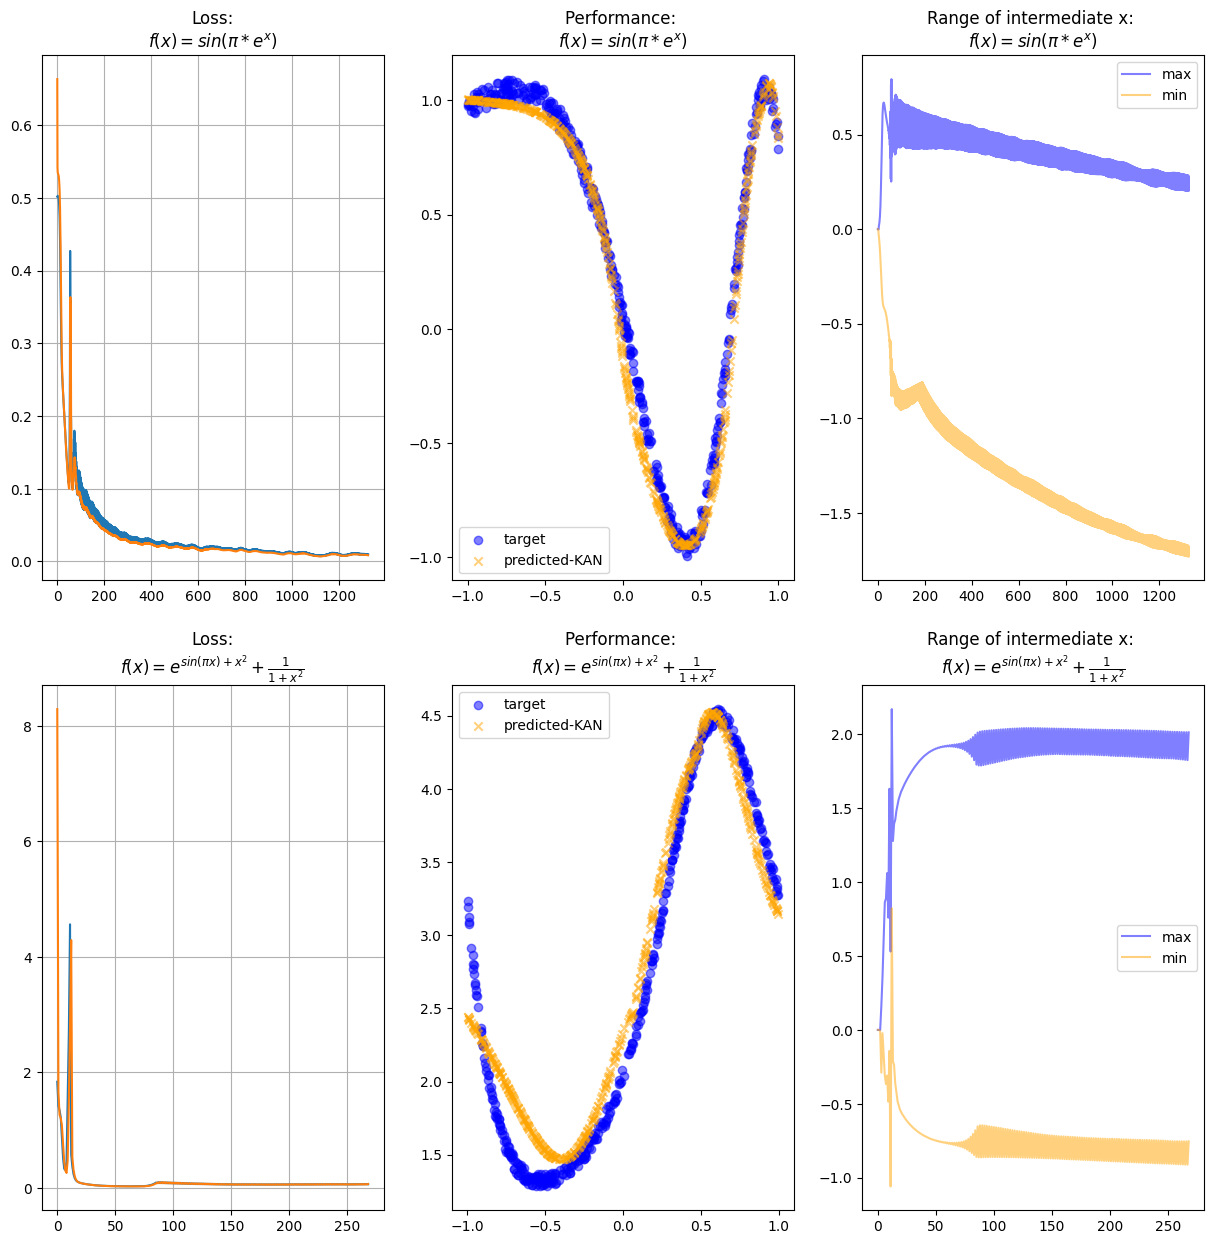

In [17]:
fns = []
fns += [(lambda x: torch.sin(torch.pi * torch.exp(x)), "$f(x) = sin(\pi*e^{x})$")]
fns += [
    (
        lambda x: torch.exp(torch.sin(torch.pi * x) + x**2) + (1 / (1 + x**2)),
        "$f(x) = e^{sin(\pi x) + x^2} + \\frac{1}{1+x^2}$",
    )
]

lr = 0.1
k = 3
n_layers = 2
grid_sizes = [3, 3]
grid_range = [-1, 1]

fig, axs = plt.subplots(nrows=len(fns), ncols=3, figsize=(15, 15), dpi=100)
for idx, (fn, fn_label) in enumerate(fns):
    x_eval = torch.linspace(-1, 1, steps=999).unsqueeze(dim=1)
    y_target = fn(x_eval) + 0.1 * torch.rand(x_eval.shape)

    # test and train split
    n_training = int(x_eval.shape[0] * 0.8)
    training_idxs = np.random.randint(x_eval.shape[0], size=n_training)
    test_idxs = [i for i in range(x_eval.shape[0]) if i not in training_idxs]
    x_training = x_eval[training_idxs]
    x_test = x_eval[test_idxs]
    y_training = y_target[training_idxs]
    y_test = y_target[test_idxs]

    print(fn_label)
    print("Number of observations in the training dataset: ", n_training)
    print("Number of observations in the test dataset: ", len(test_idxs))

    params_kan, y_pred_kan, losses_kan, all_xs = single_stacked_kan_training(
        x_training,
        y_training,
        x_test,
        y_test,
        lr=lr,
        k=k,
        n_layers=n_layers,
        grid_sizes=grid_sizes,
        verbose=False,
        grid_range=grid_range,
    )
    print(f"{fn_label} \t Avg. loss: {np.mean(losses_kan['val'][-100:]): 0.5f}")

    ax = axs[idx, 0]
    ax.plot(losses_kan["val"], label="val")
    ax.plot(losses_kan["train"], label="train")
    ax.grid()
    ax.set_title(f"Loss:\n{fn_label}")

    ax = axs[idx, 1]
    ax.scatter(
        x_test[:, 0].tolist(),
        y_test[:, 0].tolist(),
        color="blue",
        alpha=0.5,
        label="target",
    )
    ax.scatter(
        x_test[:, 0].tolist(),
        y_pred_kan[:, 0].tolist(),
        color="orange",
        alpha=0.5,
        label="predicted-KAN",
        marker="x",
    )
    ax.legend()
    ax.set_title(f"Performance: \n{fn_label}")

    ax = axs[idx, 2]
    x_min = [xs[0].min().item() for xs in all_xs]
    x_max = [xs[0].max().item() for xs in all_xs]
    ax.plot(x_max, color="blue", alpha=0.5, label="max")
    ax.plot(x_min, color="orange", alpha=0.5, label="min")
    ax.legend()
    ax.set_title(f"Range of intermediate x: \n{fn_label}")

**Note:**

We've analyzed the output of the first spline to gauge the minimum and maximum values of this layer. It is observed that the maximum value occasionally exceeds 1, falling outside the expected domain. Thus, it illustrates how intermediate values can sometimes extend beyond their intended range.

Let's look at the solutions to prevent this scenario.

### Section 2: Scaling the activation function

To ensure that these intermediate values remain well-defined and contribute effectively to the gradients, we might consider two strategies:

1. **Extend the Grid Range**: Define a broader `grid_range`, such as `[-2, 2]`, and observe whether this prevents intermediate values from exceeding the domain limits.
2. **Implement Learnable Scaling Parameters**: This approach involves using scaling parameters that can be adjusted to keep intermediate values within the domain. This method is favored by the authors as it provides a more robust solution.

The implementation is as follows:

$$
\phi(x) = w \cdot (b(x) + \sum_{i=0}^{n}c_i \cdot N_{i}(x))
$$

In this formula, the output of the spline activation is first adjusted by a bias parameter $ b(x) $, and then the sum is scaled by a learnable factor $ w $. These modifications are designed to prevent the intermediate neurons from exceeding their domain by suitably adjusting the learnable parameters.

Next, let’s explore these two options in practice when the function is $f(x) = e^{sin(\pi x) + x^2} + \frac{1}{1+x^2}$.

Scales: False, Range:[-1, 1]
Number of observations in the training dataset:  799
Number of observations in the test dataset:  450
Stopping: No further improvements...
$f(x) = e^{sin(\pi x) + x^2} + \frac{1}{1+x^2}$ 	 Avg. loss:  0.00785
Scales: False, Range:[-2, 2]
Number of observations in the training dataset:  799
Number of observations in the test dataset:  450
Stopping: Iteration limit reached...
$f(x) = e^{sin(\pi x) + x^2} + \frac{1}{1+x^2}$ 	 Avg. loss:  0.00470
Scales: True, Range:[-1, 1]
Number of observations in the training dataset:  799
Number of observations in the test dataset:  450
Stopping: No further improvements...
$f(x) = e^{sin(\pi x) + x^2} + \frac{1}{1+x^2}$ 	 Avg. loss:  0.01326


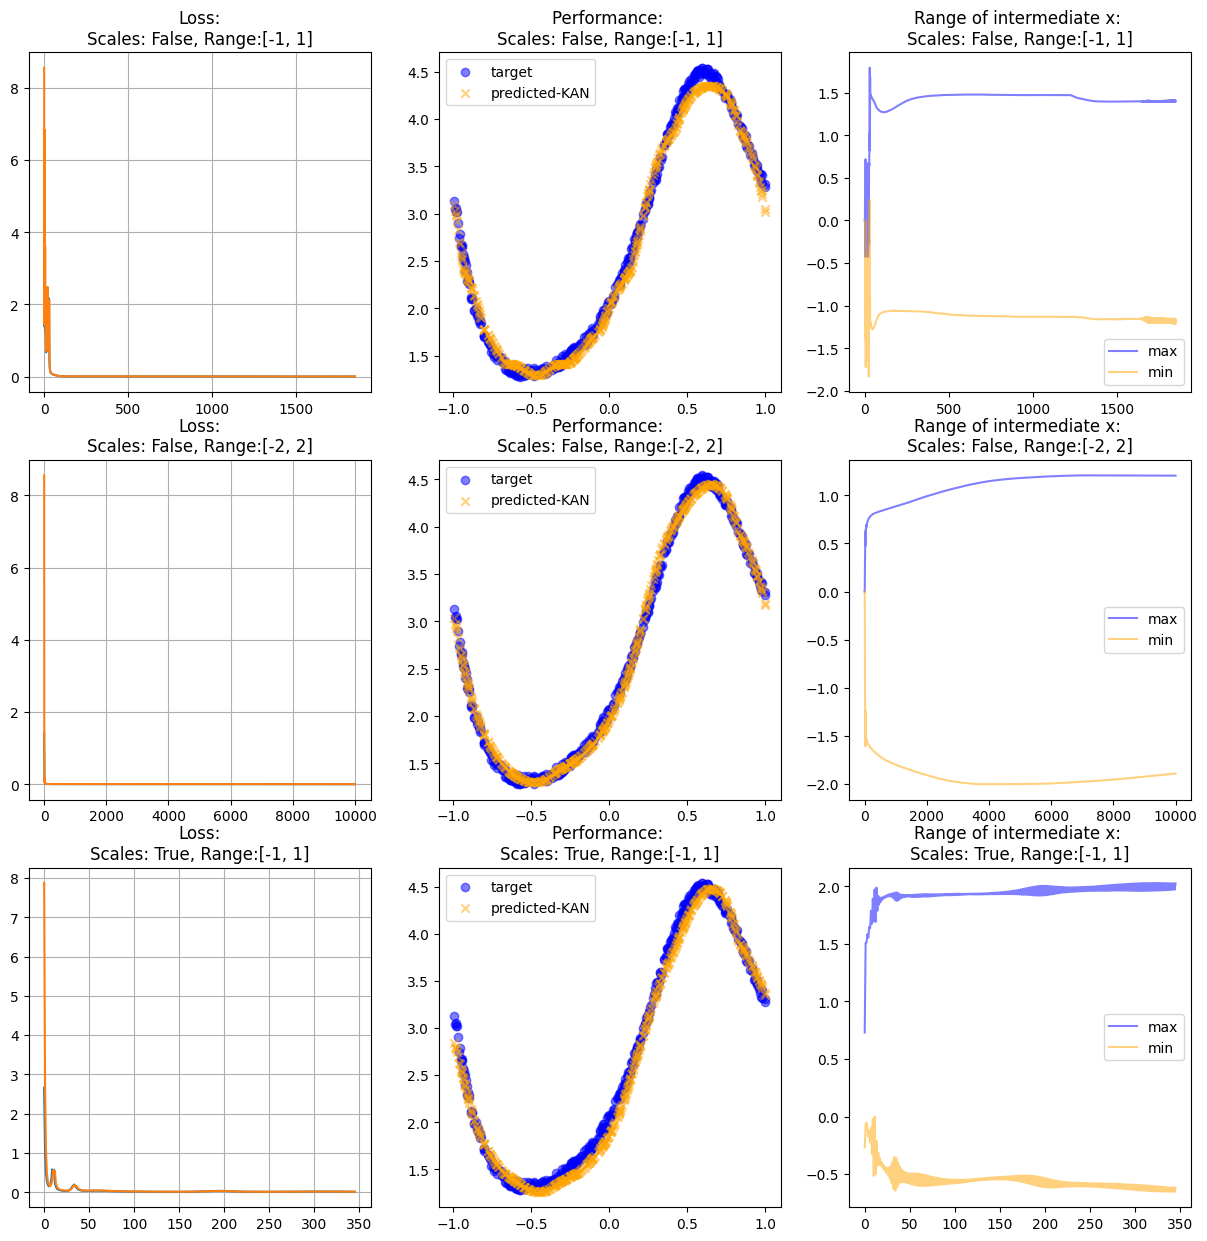

In [28]:
fn, fn_label = (
    lambda x: torch.exp(torch.sin(torch.pi * x) + x**2) + (1 / (1 + x**2)),
    "$f(x) = e^{sin(\pi x) + x^2} + \\frac{1}{1+x^2}$",
)
use_scales = [True, False]


x_eval = torch.linspace(-1, 1, steps=999).unsqueeze(dim=1)
y_target = fn(x_eval) + 0.1 * torch.rand(x_eval.shape)

# test and train split
n_training = int(x_eval.shape[0] * 0.8)
training_idxs = np.random.randint(x_eval.shape[0], size=n_training)
test_idxs = [i for i in range(x_eval.shape[0]) if i not in training_idxs]
x_training = x_eval[training_idxs]
x_test = x_eval[test_idxs]
y_training = y_target[training_idxs]
y_test = y_target[test_idxs]

params = [
    (
        dict(use_scales=False, grid_ranges=[[-1, 1], [-1, 1]]),
        "Scales: False, Range:[-1, 1]",
    ),
    (
        dict(use_scales=False, grid_ranges=[[-1, 1], [-2, 2]]),
        "Scales: False, Range:[-2, 2]",
    ),
    (
        dict(use_scales=True, grid_ranges=[[-1, 1], [-1, 1]]),
        "Scales: True, Range:[-1, 1]",
    ),
]

lr = 0.1
k = 3
n_layers = 2
grid_sizes = [4, 4]

fig, axs = plt.subplots(nrows=len(params), ncols=3, figsize=(15, 15), dpi=100)
final_losses = []
for idx, param in enumerate(params):
    label = param[1]
    print(label)
    print("Number of observations in the training dataset: ", n_training)
    print("Number of observations in the test dataset: ", len(test_idxs))

    params_kan, y_pred_kan, losses_kan, all_xs = single_stacked_kan_training(
        x_training,
        y_training,
        x_test,
        y_test,
        lr=lr,
        k=k,
        n_layers=n_layers,
        grid_sizes=grid_sizes,
        verbose=False,
        **param[
            0
        ],  # 在函数调用中使用 ** 解包操作符，可以将字典中的参数直接传递给函数，而不需要逐个指定参数名
    )
    print(f"{fn_label} \t Avg. loss: {np.mean(losses_kan['val'][-100:]): 0.5f}")

    final_losses.append((label, np.mean(losses_kan["val"][-100:])))

    ax = axs[idx, 0]
    ax.plot(losses_kan["val"], label="val")
    ax.plot(losses_kan["train"], label="train")
    ax.grid()
    ax.set_title(f"Loss:\n{label}")

    ax = axs[idx, 1]
    ax.scatter(
        x_test[:, 0].tolist(),
        y_test[:, 0].tolist(),
        color="blue",
        alpha=0.5,
        label="target",
    )
    ax.scatter(
        x_test[:, 0].tolist(),
        y_pred_kan[:, 0].tolist(),
        color="orange",
        alpha=0.5,
        label="predicted-KAN",
        marker="x",
    )
    ax.legend()
    ax.set_title(f"Performance: \n{label}")

    ax = axs[idx, 2]
    x_min = [xs[0].min().item() for xs in all_xs]
    x_max = [xs[0].max().item() for xs in all_xs]
    ax.plot(x_max, color="blue", alpha=0.5, label="max")
    ax.plot(x_min, color="orange", alpha=0.5, label="min")
    ax.legend()
    ax.set_title(f"Range of intermediate x: \n{label}")

In [29]:
for label, loss in final_losses:
    print(f"{label}: {loss: 0.5f}")

Scales: False, Range:[-1, 1]:  0.00785
Scales: False, Range:[-2, 2]:  0.00470
Scales: True, Range:[-1, 1]:  0.01326


**Observations:**

- Grid range of $ [-1, 1] $ *without* the scaling parameters has the maximum loss value compared to the other cases
- Extending the grid range to $ [-2, 2] $ is as effective as using scales in the grid range of $ [-1, 1] $.

Given the unpredictable ranges of intermediate neuron outputs, employing scaling parameters is a practical approach. Specifically, scaling aids in stabilizing the training process, as these parameters help control the domain of the outputs. This control is crucial in preventing outputs from exceeding domain limits, which could otherwise impede learning.

### Section 3: How does it compare to MLPs?

Finally, let's look at the comparable sized MLP and how it performs compared to KAN above.

In [19]:
def single_stacked_mlp_training(
    x_training,
    y_training,
    x_test,
    y_test,
    lr,
    layer_sizes,
    early_stopping_improvement_threshold=200,
    early_stopping_iterations=1e4,
    verbose=True,
):
    """Trains MLP similar to the function above."""

    layer_sizes = [1] + layer_sizes + [1]
    weights, biases = [], []
    n_layers = len(layer_sizes)

    # Define MLP weights and biases
    for idx in range(n_layers - 1):
        w = torch.randn(layer_sizes[idx], layer_sizes[idx + 1], requires_grad=True)
        weights.append(w)

        b = torch.zeros(layer_sizes[idx + 1], requires_grad=True)
        biases.append(b)

    losses = {"train": [], "val": []}
    best_loss = np.inf
    n_no_improvements = 0
    i = 0
    while True:
        x = x_training
        for weight, bias in zip(weights, biases):
            x = F.linear(x, weight.t(), bias)
            x = F.silu(x)  # relu might not work better here

        y_pred = x
        loss = torch.mean(torch.pow(y_pred - y_training, 2))
        loss.backward()
        losses["train"].append(loss.item())

        # Perform gradient descent
        for weight, bias in zip(weights, biases):
            weight.data = weight.data - lr * weight.grad
            weight.grad.zero_()

            bias.data = bias.data - lr * bias.grad
            bias.grad.zero_()

        # evaluate validation loss
        with torch.no_grad():
            x = x_test
            for weight, bias in zip(weights, biases):
                x = F.linear(x, weight.t(), bias)
                x = F.silu(x)  # relu might not work better here
            y_pred_test = x
            val_loss = torch.mean(torch.pow(y_pred_test - y_test, 2))
            losses["val"].append(val_loss.item())

        if i % 100 == 0 and verbose:
            print(
                f"Val loss: {val_loss.item(): 0.5f}\tTrain loss: {loss.item(): 0.5f}\tBest Val loss:{best_loss: 0.5f}"
            )

        if best_loss > val_loss.item():
            best_loss = val_loss.item()
            best_model = [weights, biases]
            n_no_improvements = 0
        else:
            n_no_improvements += 1
            if n_no_improvements > early_stopping_improvement_threshold:
                print("Stopping: No further improvements...")
                break

        i += 1
        if i > early_stopping_iterations:
            print("Stopping: Iteration limit reached...")
            break

    return best_model, y_pred_test, losses

In [4]:
# Create a dataset
fn, fn_label = (lambda x: torch.exp(torch.sin(torch.pi* x) + x**2) + (1 / (1 + x**2)), '$f(x) = e^{sin(\pi x) + x^2} + \\frac{1}{1+x^2}$')

x_eval = torch.linspace(-1, 1, steps=999).unsqueeze(dim=1)
y_target = fn(x_eval) + 0.1 * torch.rand(x_eval.shape)

# test and train split
n_training = int(x_eval.shape[0] * 0.8)
training_idxs = np.random.randint(x_eval.shape[0], size=n_training)
test_idxs = [i for i in range(x_eval.shape[0]) if i not in training_idxs]
x_training = x_eval[training_idxs]
x_test = x_eval[test_idxs]
y_training = y_target[training_idxs]
y_test = y_target[test_idxs]

$\phi \left( x \right)={{\omega }_{1}}b\left( x \right)+{{\omega }_{2}}spline\left( x \right)$

In [18]:
# train [1, 1, 1] KAN
use_scales = False
grid_sizes = [5, 5]
grid_ranges = []
n_layers = 2
lr = 0.1
k = 3

params_kan, y_pred_kan, losses_kan, all_xs = single_stacked_kan_training(
    x_training,
    y_training,
    x_test,
    y_test,
    lr=lr,
    k=k,
    n_layers=n_layers,
    grid_sizes=grid_sizes,
    verbose=False,
    grid_ranges=[],
    use_scales=use_scales,
)

print(f"Number of params: {sum([x.numel() for x in params_kan['coeffs']])}")
print(f"Avg. loss: {np.mean(losses_kan['val'][-100:]): 0.5f}")

Stopping: No further improvements...
Number of params: 14
Avg. loss:  0.08204


In [23]:
# MLP training 
lr = 0.1
layer_sizes = [3, 3] 

params_mlp, y_pred_mlp, losses_mlp = single_stacked_mlp_training(x_training, y_training, x_test, y_test, lr=lr, layer_sizes=layer_sizes, verbose=False)
weights, biases = params_mlp

print(f"Number of parameters learned: {sum([x.numel() for x in weights]) + sum([x.numel() for x in biases])}")
print(f"Avg. loss: {np.mean(losses_mlp['val'][-100:]): 0.5f}")

Stopping: No further improvements...
Number of parameters learned: 22
Avg. loss:  0.01094


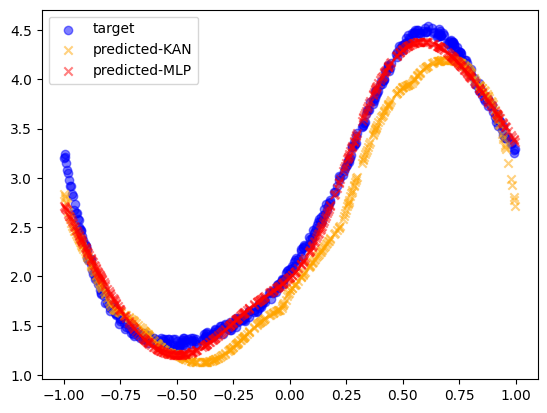

In [24]:
plt.scatter(x_test[:, 0].tolist(), y_test[:, 0].tolist(), color='blue', alpha=0.5, label='target')
plt.scatter(x_test[:, 0].tolist(), y_pred_kan[:, 0].tolist(), color='orange', alpha=0.5, label='predicted-KAN', marker='x')
plt.scatter(x_test[:, 0].tolist(), y_pred_mlp[:, 0].tolist(), color='red', alpha=0.5, label='predicted-MLP', marker='x')
plt.legend()

**Observations:**

The MLP for the same number of parameters yields inferior loss compared to KAN of similar size. However, there might exist some hyperparameters for MLP training yielding similar or better performance as KAN. 

**To summarize:**

- We have explored how to learn the coefficients in KAN by backpropagating errors.
- We observed the benefits of implementing scaling functions alongside spline activations.
- We assessed and compared the performance with that of MLPs.

**What's next?**

In the next notebook, we will learn how to manipulate grid or control points to facilitate continual learning. This approach also allows for ongoing learning without the need to retrain the network, all made possible through the use of spline-activation functions.

### Finish
Now, what will happen when instead of increasing the domain, we increase the control points in the same grid range? i.e., we make the grid finer --> This has the same impact as increasing the number of parameters, which is what we did by using the scales. 

As authors mention, increasing the number of grid points result in the increase in the number of parameters. One exceptional quality of such a method is that the network need not be retrained -- one can use the existing learned parameters and keep training from thereon. 

Let's look at what will happen in the above learning curves, when the grid is made finer instead of increasing the range or using scales?

### Updating the control points to accomadate shifting domains of intermediate neurons

In updating the control points we need two things - 

1. new control points (i.e., new grid)
2. the corresponding coefficients


Here, we are constrained by the following requirements -

1. New control points are determined using the new sample (keeping the number of intervals same, hence the number of coefficients will be same)
2. New coefficients are chosen to keep the predictions same but using the new control points

In [ ]:
def get_coeff(bases, y_eval):
    """
    Returns coefficients that give y_eval from bases

    Args:
        bases: (number of samples, number of basis functions)
        y_eval: (number of samples, 1)
        
    """
    return torch.linalg.lstsq(bases.transpose(0, 1), y_eval.unsqueeze(dim=0)).solution

In [4]:
def update_grids(grids, coeffs, all_xs, grid_eps=0.02, margin=0.01):
    """
    Updates grids.
    """

    n_xs = len(all_xs)
    for i in range(n_xs - 1):
        x = all_xs[i]
        grid = grids[i + 1]  # ith index is input to the grid at i+1
        coeff = coeffs[i + 1]

        x_pos = torch.sort(x, dim=0)[0]
        y_eval = torch.einsum(
            "ijk, bij->bk", coeff, eval_basis_functions(x_pos, grid, k)
        )

        batch = x.shape[0]
        num_intervals = grid.shape[-1] - 1
        ids = [int(batch / num_intervals * i) for i in range(num_intervals)] + [
            -1
        ]  # last index is chosen as is for the boundary

        # grid to have equal number of observations in each bucket
        grid_adaptive = x_pos[ids, :].transpose(1, 0)

        # uniform grid with equally spaced control points
        grid_range = grid_adaptive[:, [-1]] - grid_adaptive[:, [0]]
        grid_uniform = torch.cat(
            [
                grid_adaptive[:, [0]] - margin + (grid_range + 2 * margin) * a
                for a in torch.linspace(0, 1, num_intervals + 1)
            ],
            dim=1,
        )

        new_grid = grid_uniform * grid_eps + grid_adaptive * (1 - grid_eps)
        new_bases = eval_basis_functions(x_pos, new_grid, k)
        new_coeff = get_coeff(new_bases, y_eval)

        grid.data = new_grid.data
        coeff.data = new_coeff.data

    return grids, coeffs

In [26]:
update_grid = False
grid_update_freq = 50  #  backprop iterations
stop_grid_update_step = np.inf  # don't update after these many iterations

fn = lambda x: torch.sin(torch.pi * torch.exp(x)) + torch.tanh(x) + torch.arcsinh(x)
x_eval = torch.linspace(-1, 1, steps=999).unsqueeze(dim=1)
y_target = fn(x_eval) + 0.1 * torch.rand(x_eval.shape)

lr = 0.5
n_layers = 2
k = 0
grid_range = [-1, 1]
grid_sizes = [10, 10]

grids, coeffs = [], []
for idx in range(n_layers):
    grid = torch.linspace(
        grid_range[0], grid_range[1], steps=grid_sizes[idx]
    ).unsqueeze(dim=0)
    grids.append(grid)

    coeff = torch.zeros((1, grid_sizes[idx] - k - 1, 1), requires_grad=True)
    coeffs.append(coeff)

verbose = True
early_stopping_threshold = 200
losses = []
best_loss = np.inf
n_no_improvements = 0
i = 0
all_xs = []
all_grads = []
grid_updates = []

x = x_eval
xs = []
for idx in range(n_layers):
    bases = eval_basis_functions(x, grids[idx], k)
    x = torch.einsum("ijk, bij->bk", coeffs[idx], bases)
    xs.append(x.detach())

all_xs.append(xs)

y_pred = x
loss = torch.mean(torch.pow(y_pred - y_target, 2))
loss.backward()
losses.append(loss.item())

coeffs[1]

tensor([[[0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.]]], requires_grad=True)

In [27]:
update_grid = False
grid_update_freq = 50  #  backprop iterations
stop_grid_update_step = np.inf  # don't update after these many iterations

fn = lambda x: torch.sin(torch.pi * torch.exp(x)) + torch.tanh(x) + torch.arcsinh(x)
x_eval = torch.linspace(-1, 1, steps=999).unsqueeze(dim=1)
y_target = fn(x_eval) + 0.1 * torch.rand(x_eval.shape)

lr = 0.5
n_layers = 2
k = 0
grid_range = [-1, 1]
grid_sizes = [10, 10]

grids, coeffs = [], []
for idx in range(n_layers):
    grid = torch.linspace(
        grid_range[0], grid_range[1], steps=grid_sizes[idx]
    ).unsqueeze(dim=0)
    grids.append(grid)

    coeff = torch.zeros((1, grid_sizes[idx] - k - 1, 1), requires_grad=True)
    coeffs.append(coeff)

verbose = True
early_stopping_threshold = 200
losses = []
best_loss = np.inf
n_no_improvements = 0
i = 0
all_xs = []
all_grads = []
grid_updates = []
while True:
    x = x_eval
    xs = []
    for idx in range(n_layers):
        bases = eval_basis_functions(x, grids[idx], k)
        x = torch.einsum("ijk, bij->bk", coeffs[idx], bases)
        xs.append(x.detach())

    all_xs.append(xs)

    y_pred = x
    loss = torch.mean(torch.pow(y_pred - y_target, 2))
    loss.backward()
    losses.append(loss.item())
    if i % 100 == 0 and verbose:
        print(loss.item())

    if best_loss > loss.item():
        best_loss = loss.item()
        n_no_improvements = 0
    else:
        n_no_improvements += 1
        if n_no_improvements > early_stopping_threshold:
            break

    grads = []
    for coeff in coeffs:
        coeff.data = coeff.data - lr * coeff.grad
        grads.append(coeff.grad.norm())
        coeff.grad.zero_()
    all_grads.append(grads)

    if update_grid and i % grid_update_freq == 0 and i < stop_grid_update_step:
        # if  0.01 < grids[1].min() - xs[0].min() or xs[0].max() - grids[1].max() > 0.01:
        grid_updates.append(i)
        grids, coeffs = update_grids(
            grids, coeffs, all_xs[-1], grid_eps=1.0, margin=0.1
        )

    i += 1

0.8686136603355408


TypeError: unsupported operand type(s) for *: 'float' and 'NoneType'

## Grid Manipulation in KANs

This is the Part 3 of the Tutorial series on KAN. In the previous two parts, we looked at the fundamental components of KANs, focusing on spline activations and performing backpropagation within networks composed of such activation functions.

In this notebook, we will uncover the benefits of KANs. Specifically,

- We will explore how the model's capacity can be expanded easily during training. This flexibility greatly enhances the reusability of models, allowing a previously trained model to be enlarged or pruned while continuing to learn, rather than requiring retraining from scratch.

- We will demonstrate how KANs effectively retain knowledge across diverse input distributions without suffering from catastrophic forgetting. This capability facilitates continual learning, ensuring the model adapts without losing previously acquired knowledge.

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

import matplotlib.pyplot as plt
from utils.Kan.utils_kan import eval_basis_functions, get_coeff, single_stacked_kan_training

### Section 1: Enhancing model capacity mid-training

To increase the capacity of a KAN without adding more neurons (or splines), you can augment the number of parameters by increasing the number of control points. This involves adjusting the existing grid to accommodate more control points.

**Procedure for Increasing Parameters:**
1. **Adapting Control Points**: The goal is to fit more control points into the existing grid. To achieve this, we utilize a spline that maps standard grid control points, typically ranging from $ [-1, 1] $, to those in the existing grid. We calculate temporary coefficients (`temp_coef`) for this purpose.
2. **Generating More Control Points**: With the mapping spline established, we can predict and generate as many control points as needed within the existing grid.

This approach becomes particularly useful when the existing grid's control points are non-uniformly spaced, as a spline provides a methodical way to interpolate and form new control points. However, other techniques might also be used to extend the grid with additional control points.

In [2]:
k = 3
coarse_grid_size = 10
finer_grid_size = 20

preacts = torch.rand((100, 1))
postacts = torch.sin(preacts) + torch.randn(preacts.shape) * 0.1

# find the new control points
prev_grid = torch.linspace(-2.5, 2, steps=coarse_grid_size).unsqueeze(
    dim=0
)  # we need to increase the contorl points here

# learn the spline to predict the control points in the existing grid
x_pos = prev_grid.transpose(1, 0)
temp_grid = torch.linspace(-1, 1, steps=coarse_grid_size).unsqueeze(dim=0)
temp_bases = eval_basis_functions(
    temp_grid.transpose(1, 0), temp_grid, k=1
)  # linear interpolate into a smaller grid
temp_coef = get_coeff(temp_bases, x_pos)

# let's predict more control points using the above spline
percentiles = torch.linspace(-1, 1, steps=finer_grid_size).unsqueeze(dim=1)
percentiles_basis = eval_basis_functions(percentiles, temp_grid, k=1)
new_grid = torch.einsum("ijk, bij-> bk", temp_coef, percentiles_basis).transpose(1, 0)
new_grid

# find the coefficients (predicitng the same postacts from preacts but using the new control points)
new_bases = eval_basis_functions(preacts, new_grid, k)
new_coef = get_coeff(new_bases, postacts)

将其放入函数

In [6]:
def update_grid(prev_grid, new_grid_size, k, preacts, postacts):
    """
    Updates grid.

    Args:
        prev_grid: (number of splines, number of control points)
        new_grid_size: new number of control points
        k: spline-order
        preacts: inputs to the grid
        postacts: current outputs to the grid.

    Returns:
        new_coef: New coefficients to maintain the behavior of the current spline-activation
        new_grid: new grid with new control points
    """
    coarse_grid_size = prev_grid.shape[-1]
    finer_grid_size = new_grid_size

    # learn the spline to predict the control points in the existing grid
    x_pos = prev_grid.transpose(1, 0)
    temp_grid = torch.linspace(-1, 1, steps=coarse_grid_size).unsqueeze(dim=0)
    temp_bases = eval_basis_functions(
        temp_grid.transpose(1, 0), temp_grid, k=1
    )  # linear interpolate into a smaller grid
    temp_coef = get_coeff(temp_bases, x_pos)

    # let's predict more control points using the above spline
    percentiles = torch.linspace(-1, 1, steps=finer_grid_size).unsqueeze(dim=1)
    percentiles_basis = eval_basis_functions(percentiles, temp_grid, k=1)
    new_grid = torch.einsum("ijk, bij-> bk", temp_coef, percentiles_basis).transpose(
        1, 0
    )

    # find the coefficients (predicitng the same postacts from preacts but using the new control points)
    new_bases = eval_basis_functions(preacts, new_grid, k)
    new_coef = get_coeff(new_bases, postacts)

    return new_coef, new_grid

In [4]:
# fn, fn_label = lambda x: torch.sin(torch.pi * x),  '$sin(\pi x)$'
# fn, fn_label = (lambda x: torch.exp(torch.exp(-x)) + torch.sin(torch.pi * x) + torch.exp(torch.sin(x)), '$e^{e^{-x}} + sin(\pi \cdot x) + e^{sin(x)}$')
fn, fn_label = (
    lambda x: torch.exp(torch.sin(torch.pi * x) + x**2) + (1 / (1 + x**2)),
    "$f(x) = e^{sin(\pi x) + x^2} + \\frac{1}{1+x^2}$",
)

x_eval = torch.linspace(-1, 1, steps=999).unsqueeze(dim=1)
y_target = fn(x_eval) + 0.1 * torch.rand(x_eval.shape)

# test and train split
n_training = int(x_eval.shape[0] * 0.8)
training_idxs = np.random.randint(x_eval.shape[0], size=n_training)
test_idxs = [i for i in range(x_eval.shape[0]) if i not in training_idxs]
x_training = x_eval[training_idxs]
x_test = x_eval[test_idxs]
y_training = y_target[training_idxs]
y_test = y_target[test_idxs]


lr = 0.1
k = 2
n_layers = 1
grid_sizes = [3]
grid_range = [-1, 1]

loss_batches = []

params_kan, y_pred_kan, losses_kan, all_xs = single_stacked_kan_training(
    x_training,
    y_training,
    x_test,
    y_test,
    lr=lr,
    k=k,
    n_layers=n_layers,
    grid_sizes=grid_sizes,
    verbose=False,
    grid_range=[],
    use_scales=False,
)
loss_batches.append(losses_kan)

for new_grid_size in [5, 8, 10, 12]:
    prev_grid = params_kan["grids"][0]
    prev_coef = params_kan["coeffs"][0]
    postacts = all_xs[-1][0]
    new_coef, new_grid = update_grid(prev_grid, new_grid_size, k, x_training, postacts)

    new_coef = new_coef.requires_grad_(True)
    params_kan["grids"] = [new_grid]
    params_kan["coeffs"] = [new_coef]

    print(
        f"Increasing number of parameters to {new_grid_size}: Prev grid: {prev_grid.shape} New grid: {new_grid.shape} Prev. Coef: {prev_coef.shape} New Coef: {new_coef.shape}"
    )

    params_kan, y_pred_kan, losses_kan, all_xs = single_stacked_kan_training(
        x_training,
        y_training,
        x_test,
        y_test,
        model_params=params_kan,
        lr=lr,
        k=k,
        n_layers=n_layers,
        grid_sizes=grid_sizes,
        verbose=False,
        grid_range=[],
        use_scales=False,
    )

    loss_batches.append(losses_kan)

Stopping: No further improvements...
Increasing number of parameters to 5: Prev grid: torch.Size([1, 3]) New grid: torch.Size([1, 5]) Prev. Coef: torch.Size([1, 4, 1]) New Coef: torch.Size([1, 6, 1])
Stopping: No further improvements...
Increasing number of parameters to 8: Prev grid: torch.Size([1, 5]) New grid: torch.Size([1, 8]) Prev. Coef: torch.Size([1, 6, 1]) New Coef: torch.Size([1, 9, 1])
Stopping: No further improvements...
Increasing number of parameters to 10: Prev grid: torch.Size([1, 8]) New grid: torch.Size([1, 10]) Prev. Coef: torch.Size([1, 9, 1]) New Coef: torch.Size([1, 11, 1])
Stopping: No further improvements...
Increasing number of parameters to 12: Prev grid: torch.Size([1, 10]) New grid: torch.Size([1, 12]) Prev. Coef: torch.Size([1, 11, 1]) New Coef: torch.Size([1, 13, 1])
Stopping: No further improvements...


Text(0.5, 1.0, 'Loss:\n$f(x) = e^{sin(\\pi x) + x^2} + \\frac{1}{1+x^2}$')

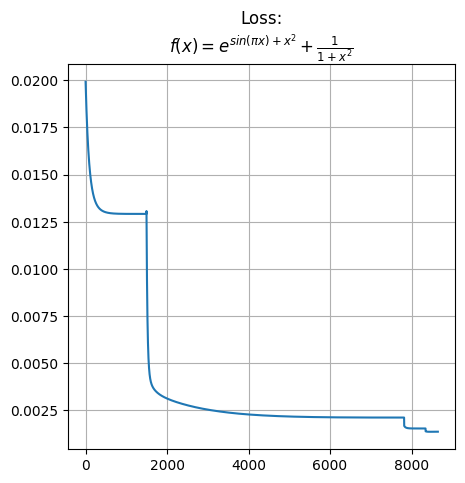

In [5]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5, 5), dpi=100)

ax = axs 
ax.plot([x for losses in loss_batches for x in losses['val'] if x < 0.02])
ax.grid()
ax.set_title(f"Loss:\n{fn_label}")

**Obseravtions:** 

With every expansion in model capacity, we observe an increase in the generalization power of the [1, 1] KAN.

### Section 2: Continual Learning


In continual learning, the domain of inputs changes over time. In traditional deep learning models, using data from a new task as training data often leads to "catastrophic forgetting," where the network begins to forget previously learned tasks. KANs effectively overcome this issue. The reason lies in their use of B-splines as activation functions. B-splines exhibit a property of locality, meaning that adjustments to specific points can be made without affecting the global curve. This feature is crucial in KAN activation functions, allowing them to adapt to new input domains seamlessly while preserving their behavior in previous contexts.

Let's explore this capability in practice...

First, we will wrap our KAN prediction in a function to avoid code repetition. 

In [7]:
def model_predict(params_kan, x_eval, k):
    """
    Implements prediction functions using raw KANs.
    """
    # 从参数中提取所需的网格、系数、缩放基函数、缩放样条函数和基函数
    grids = params_kan["grids"]
    coeffs = params_kan["coeffs"]
    scale_bases = params_kan["scale_bases"]
    scale_splines = params_kan["scale_splines"]
    base_fns = params_kan["base_fns"]

    # 遍历网格和系数的索引
    for idx in range(len(grids)):
        grid, coeff = grids[idx], coeffs[idx]

        # 使用torch.no_grad()避免计算梯度
        with torch.no_grad():
            # spline(x)
            x = torch.einsum(
                "ijk, bij -> bk", coeff, eval_basis_functions(x_eval, grid, k)
            )
            # 如果存在基函数，则进行相应的缩放和计算
            # w1*b(x) + w2*spline(x)
            if len(base_fns) > 0:
                base_fn, scale_sp, scale_base = (
                    base_fns[idx],
                    scale_splines[idx],
                    scale_bases[idx],
                )
                x = scale_base * base_fn(x_eval) + scale_sp * x

        # 更新预测结果和评估输入
        y_pred = x_eval = x

    # 返回预测结果
    return y_pred

创建一个数据集，在不同的输入范围内展示不同的函数形式。挑战在于以逐个任务的方式在这个数据集上训练[1,1]KAN，其中每个任务的观察结果都是按顺序呈现的，而不是一次性呈现的。

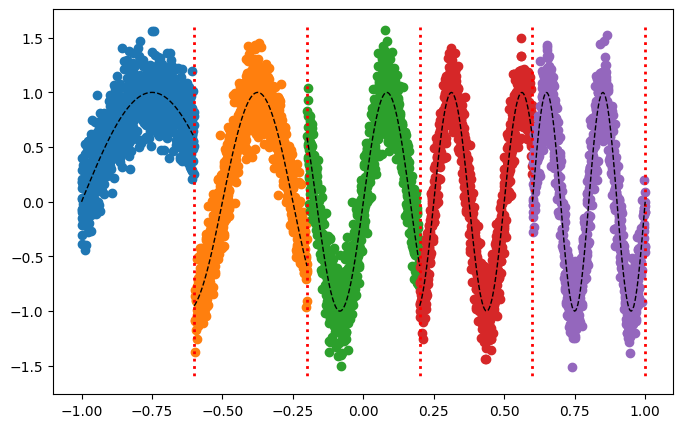

In [8]:
# Set random seed for reproducibility
torch.random.manual_seed(42)

fig, ax = plt.subplots(1, 1, figsize=(8, 5), dpi=100)

# Data generation parameters
n_samples_per_phase = 1000
noise_level = 0.2
n_phases = 5

for i in range(n_phases):
    start = -1 + i * 2/n_phases
    end = start + 2/n_phases
    x = torch.rand(n_samples_per_phase) * (end - start) + start
    
    y = torch.sin(2 * x * torch.pi * (i + 1)) 
    y_noisy = y + noise_level * torch.randn(y.shape)

    ax.scatter(x, y_noisy)
    ax.vlines(end, 1.6, -1.6, color='red', linestyle=':', linewidth=2)

    x_ = torch.linspace(start, end, 100)
    y_ = torch.sin(2 * x_ * torch.pi * (i + 1))
    ax.plot(x_, y_, color='black', linewidth=1, linestyle='--')
    

准备数据集来训练KAN参数。考虑一个涉及三个任务的场景，每个任务由一个数据集表示，该数据集具有在单独的输入域上定义的不同函数形式。

Stopping: No further improvements...
Phase: 0 	 Loss:  0.0374
Stopping: No further improvements...
Phase: 1 	 Loss:  0.0541
Stopping: No further improvements...
Phase: 2 	 Loss:  0.0590


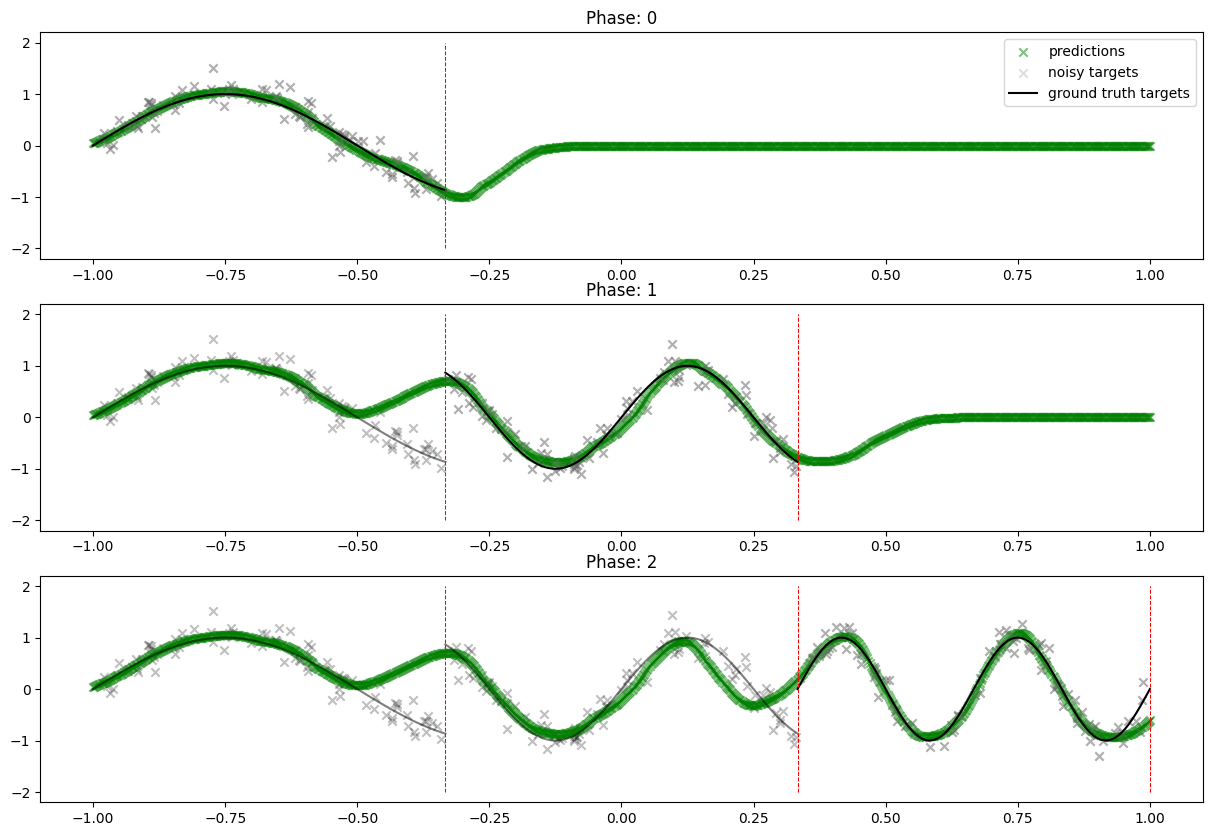

In [9]:
# Data generation parameters
n_samples_per_phase = 100
noise_level = 0.2
n_phases = 3

fig, axs = plt.subplots(nrows=n_phases, ncols=1, figsize=(15, 10), dpi=100)

losses = []
grid_sizes = [20]
grid_range = [-1, 1]
lr = 0.5
k = 3
n_layers = 1

params_kan = None
x_temps, y_temps, ends, y_noisys = [], [], [], []
for i in range(n_phases):

    # create this dataset
    start = -1 + i * 2 / n_phases
    end = start + 2 / n_phases
    fn = lambda x, i: torch.sin(2 * x * torch.pi * (i + 1))

    x = torch.rand(n_samples_per_phase) * (end - start) + start

    y = fn(x, i)
    y_noisy = y + noise_level * torch.randn(y.shape)

    # train the model
    x_eval = x.unsqueeze(dim=1)
    y_target = y_noisy.unsqueeze(dim=1)

    # test and train split
    n_training = int(x_eval.shape[0] * 0.8)
    training_idxs = np.random.randint(x_eval.shape[0], size=n_training)
    test_idxs = [i for i in range(x_eval.shape[0]) if i not in training_idxs]
    x_training = x_eval[training_idxs]
    x_test = x_eval[test_idxs]
    y_training = y_target[training_idxs]
    y_test = y_target[test_idxs]

    # train using the same model (model_params=params_kan)
    params_kan, y_pred_kan, losses_kan, all_xs = single_stacked_kan_training(
        x_training,
        y_training,
        x_test,
        y_test,
        lr=lr,
        model_params=params_kan,
        k=k,
        n_layers=n_layers,
        grid_sizes=grid_sizes,
        verbose=False,
        grid_range=[],
        use_scales=False,
    )

    losses.append(losses_kan)
    print(f"Phase: {i} \t Loss: {np.mean(losses_kan['val'][-50:]): 0.4f}")

    # predictions vs target
    ax = axs[i]
    ax.scatter(x, y_noisy, color="black", marker="x", alpha=0.25)
    for temp_x, temp_y in y_noisys:
        ax.scatter(temp_x, temp_y, color="black", alpha=0.25, marker="x")

    y_noisys.append((x, y_noisy))

    x_in = torch.linspace(-1, 1, 1000).unsqueeze(dim=1)
    y_pred = model_predict(params_kan, x_in, k)
    ax.scatter(
        x_in[:, 0], y_pred, color="green", alpha=0.5, marker="x", label="predictions"
    )
    ax.scatter(x, y_noisy, color="grey", marker="x", alpha=0.25, label="noisy targets")

    x_temp = torch.linspace(0, 1, 100) * (end - start) + start
    y_temp = fn(x_temp, i)

    ax.plot(x_temp, y_temp, linestyle="-", color="black", label="ground truth targets")
    for x, y in zip(x_temps, y_temps):
        ax.plot(x, y, linestyle="-", alpha=0.5, color="black")

    ends.append(end)
    for x in ends:
        ax.vlines(x, -2, 2, linestyle="--", color="red", linewidth=0.75)

    ax.set_title(f"Phase: {i}")
    if i == 0:
        ax.legend()

    x_temps.append(x_temp)
    y_temps.append(y_temp)

**Observations:**

The green points indicate the predictions of the learned KAN. As observed in successive phases of the dataset, the function learned from previous input domains is retained. This consistency allows for continual learning without catastrophic forgetting.

#### Summary

In this session, we explored how the grid in B-splines can be utilized effectively to enhance model capacity without the need to retrain models. We also examined how these grids help prevent catastrophic forgetting in continual learning scenarios.

#### What's next?

In the next notebook, we will explore how to perform symbolic learning using KANs.

## Symbolic Regression using KANs

This is Part 4 of the tutorial series on KAN. 

In our previous notebooks, we looked at the fundamental components of KANs, including spline activation functions and how to perform backpropagation in a network using such functions. We also explored the unique advantages of KANs, such as their capability for continual learning and enhancing model capacity.

In this notebook, we will learn how to train KANs when specific activation functions are predetermined and fixed to a symbolic formula. If a user is able to identify a spline that matches a certain symbolic function, that activation can be fixed to the identified symbolic formula, while the rest of the KAN continues to be trained.

Let's dive into this scenario.


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

import matplotlib.pyplot as plt
from utils.Kan.utils_kan import eval_basis_functions, get_coeff, single_stacked_kan_training

### Dataset

Let's create a dataset using the function example provided by the authors: $ f(x, y) = e^{\sin(\pi x) + (y+0.5)^2} $.

In [13]:
# 定义输入的一维张量
x = torch.tensor([1, 2, 3])
y = torch.tensor([4, 5, 6, 7])

# 生成网格点坐标矩阵，使用 'ij' 索引方式
X, Y = torch.meshgrid(x, y, indexing='ij')

print(X)
print(Y)


tensor([[1, 1, 1, 1],
        [2, 2, 2, 2],
        [3, 3, 3, 3]])
tensor([[4, 5, 6, 7],
        [4, 5, 6, 7],
        [4, 5, 6, 7]])


In [18]:
fn = lambda x: torch.exp(torch.sin(torch.pi * x[:, :1]) + torch.pow(x[:, 1:] + 0.5, 2))

x1 = torch.linspace(-1, 1, steps=40)
x2 = torch.linspace(-1, 1, steps=40)
x1, x2 = torch.meshgrid(x1, x2, indexing="ij")
x_eval = torch.stack([x1.flatten(), x2.flatten()], dim=1)
y_target = fn(x_eval)  # + torch.randn((x_eval.shape[0], 1))*0.1

# test and train split
n_training = int(x_eval.shape[0] * 0.8)
training_idxs = np.random.randint(x_eval.shape[0], size=n_training)
test_idxs = [i for i in range(x_eval.shape[0]) if i not in training_idxs]
x_training = x_eval[training_idxs]
x_test = x_eval[test_idxs]
y_training = y_target[training_idxs]
y_test = y_target[test_idxs]

print("Training dataset: ", n_training)
print("Test dataset: ", len(test_idxs))

Training dataset:  1280
Test dataset:  707


#### Basic functions

Let's define some basic functions
1. `initialize_KAN` to setup a KAN using the parameters provided
2. `eval_KAN` to evaluate KAN for a given x
3. `eval_x_symbolically` to evaluate x given only the symbolic functions
4. `set_symbolic_fn` to set a particular activation function in KAN to a specified symbolic function

In [2]:
def initialize_KAN(KAN, k, grid_range, grid_size):
    """
    Returns the ingredients necessary to evaluate a KAN.
    Note: we use a single grid for all the activation functions.

    Args:
        KAN: List of integers corresponding to neurons in each layer
        k: spline order
        grid_range: range of grid. e.g, [-1, 1]
        grid_size: number of control points
    """
    grid = torch.linspace(grid_range[0], grid_range[1], steps=grid_size).unsqueeze(
        dim=0
    )

    # initialize the coefficients and symbolic functions
    coefs, masks, symbolic_functions = [], [], []
    for in_dim, out_dim in zip(KAN, KAN[1:]):
        coef = torch.zeros((in_dim, out_dim, grid_size + k - 1), requires_grad=True)
        mask = torch.ones((in_dim, out_dim))
        coefs.append(coef)
        masks.append(mask)

        symb_fns = [[lambda x: x for _ in range(out_dim)] for _ in range(in_dim)]
        symbolic_functions.append(symb_fns)

    return coefs, masks, symbolic_functions, grid

In [3]:
def eval_x_symbolically(x_eval, symbolic_fns):
    """
    Evaluates `x_eval` using functions specified in `symbolic_fns`.

    Args:
        x_eval: (batch,number of dimensions)
        symbolic_fns: list of list of symbolc functions. 
    """
    in_dim = len(symbolic_fns)
    out_dim = len(symbolic_fns[0])
    postacts = []
    for i in range(in_dim):
        postacts_ = []
        for j in range(out_dim):
            symb_fn = symbolic_fns[i][j]
            postacts_.append(symb_fn(x_eval[:, i]))
        postacts.append(torch.stack(postacts_, dim=1))
    
    return torch.stack(postacts, dim=1) # stack so that the input_dim is intact
    

In [4]:
def eval_KAN(x, coefs, masks, symbolic_functions, grid, k):
    """
    Acts as the model.forward to evaluate x according to the given KAN.

    Args:
        x: (Batch, input_dimensions)
        coefs: list of coefficients of size (in_dim, out_dim, h), where in_dim and out_dim are determined by the KAN structure, h is determined by the grid
        masks: list of masks to be used to combine spline activation and symbolic activations. Each mask is (in_dim, out_dim). A value of 1 means use spline.
        symbolic_functions: list of list symbolic functions. Each inner list represents symbolic function corresponding to a specific input dimension.
        grid: grid for spline estimation
        k: order of spline
    """
    x_in = x
    for coef, mask, symb_fns in zip(coefs, masks, symbolic_functions):
        # spline activations
        bases = eval_basis_functions(x_in, grid, k)
        y_sp = torch.einsum("ijk, bik -> bij", coef, bases)

        # symbolic activations
        y_symb = eval_x_symbolically(x_in, symb_fns)

        # combine the two outputs
        y = mask[None, ...] * y_sp + (1 - mask[None, ...]) * y_symb

        # add along the input dimensions
        x_in = y.sum(dim=1)  # B x output_dimension

    return x_in

In [5]:
def eval_x_symbolically(x_eval, symbolic_fns):
    """
    Evaluates `x_eval` using functions specified in `symbolic_fns`.

    Args:
        x_eval: batch x number of dimensions
        symbolic_fns: list of list of symbolc functions. 
    """
    in_dim = len(symbolic_fns)
    out_dim = len(symbolic_fns[0])
    postacts = []
    for i in range(in_dim):
        postacts_ = []
        for j in range(out_dim):
            symb_fn = symbolic_fns[i][j]
            postacts_.append(symb_fn(x_eval[:, i]))
        postacts.append(torch.stack(postacts_, dim=1))
    
    return torch.stack(postacts, dim=1) # stack so that the input_dim is intact
    

In [7]:
class SymbolicKANLayer(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
        
        # learnable parameters
        self.affine = torch.nn.Parameter(torch.zeros(4), requires_grad=True)
        
    def forward(self, x_eval):
        return self.affine[0] * self.fn(self.affine[1]*x_eval + self.affine[2]) + self.affine[3]

    def step(self, lr):
        """
        Performs a step of gradient descent using the learning rate `lr`
        """
        if self.affine.grad is not None:
            self.affine.data = self.affine.data - lr * self.affine.grad

    def zero_grad_(self):
        """
        Zeroes out the gradients in-place.
        """
        self.affine.grad.zero_()

In [6]:
def set_symbolic_fn(symbolic_functions, masks, i, j, k, fn, use_affine=False):
    """
    Sets the symbolic function in the layer i, neuron j's kth output.
    
    Args:
         symbolic_functions:  list of list symbolic functions. Each inner list represents symbolic function corresponding to a specific input dimension. 
         masks: list of masks to be used to combine spline activation and symbolic activations. Each mask is (in_dim, out_dim). A value of 1 means use spline. 
         i: layer index
         j: neuron index (input)
         k: output index
         fn: function to use
         use_affine: whether to use SymbolicKANLayer or not

    Returns:
        modified symbolic_functions and masks
    """
    if use_affine:
        symb_fn = SymbolicKANLayer(fn)
    else:
        symb_fn = fn

    symbolic_functions[i][j][k] = symb_fn
    masks[i].data[j][k]= 0

    return symbolic_functions, masks

## Pykan

In [1]:
import torch
import torch.nn as nn
import numpy as np

In [2]:
def B_batch(x, grid, k=0, extend=True, device="cpu"):
    """
    在B样条基上评估输入x

    参数:
    -----
        x : 2D torch.tensor
            inputs, shape (number of splines, number of samples)
        grid : 2D torch.tensor
            grids, shape (number of splines, number of grid points)
        k : int
            样条的分段多项式阶数
        extend : bool
            If True, k points are extended on both ends. If False, no extension (zero boundary condition). Default: True
        device : str
            devicde

    返回值:
    --------
        spline values : 3D torch.tensor
            样条值，(number of splines, number of B-spline bases (coeffcients), number of samples). The numbef of B-spline bases = number of grid points + k - 1.

    示例:
    -------
    >>> num_spline = 5
    >>> num_sample = 100
    >>> num_grid_interval = 10
    >>> k = 3
    >>> x = torch.normal(0,1,size=(num_spline, num_sample))
    >>> grids = torch.einsum('i,j->ij', torch.ones(num_spline,), torch.linspace(-1,1,steps=num_grid_interval+1))
    >>> B_batch(x, grids, k=k).shape
    torch.Size([5, 13, 100])
    """

    # x shape: (size, x); grid shape: (number of splines, number of grid points)
    # 扩展前grid shape: (number of splines, num_grid_interval + 1)
    # 扩展后grid shape: (number of splines, num_grid_interval + 1 + 2k)
    def extend_grid(grid, k_extend=0):
        # pad k to left and right
        # grid shape: (number of splines, number of grid points)
        h = (grid[:, [-1]] - grid[:, [0]]) / (grid.shape[1] - 1)

        for i in range(k_extend):
            grid = torch.cat([grid[:, [0]] - h, grid], dim=1)
            grid = torch.cat([grid, grid[:, [-1]] + h], dim=1)
        grid = grid.to(device)
        return grid

    if extend == True:
        grid = extend_grid(
            grid, k_extend=k
        )  # shape: (number of splines, num_grid_interval + 1 + 2k)

    # shape: (number of splines, num_grid_interval + 1 + 2k, 1)
    grid = grid.unsqueeze(dim=2).to(device)
    # shape: (number of splines, 1, num_sample)
    x = x.unsqueeze(dim=1).to(device)

    if k == 0:
        value = (x >= grid[:, :-1]) * (x < grid[:, 1:])
    else:
        B_km1 = B_batch(
            x[:, 0], grid=grid[:, :, 0], k=k - 1, extend=False, device=device
        )
        value = (x - grid[:, : -(k + 1)]) / (
            grid[:, k:-1] - grid[:, : -(k + 1)]
        ) * B_km1[:, :-1] + (grid[:, k + 1 :] - x) / (
            grid[:, k + 1 :] - grid[:, 1:(-k)]
        ) * B_km1[
            :, 1:
        ]
    return value

In [3]:
def extend_grid(grid, k_extend=0):
        # pad k to left and right
        # grid shape: (batch, grid)
        h = (grid[:, [-1]] - grid[:, [0]]) / (grid.shape[1] - 1)

        for i in range(k_extend):
            grid = torch.cat([grid[:, [0]] - h, grid], dim=1)
            grid = torch.cat([grid, grid[:, [-1]] + h], dim=1)
        return grid

In [23]:
num_spline = 5
num_sample = 100
num_grid_interval = 10
k = 3
x = torch.normal(0, 1, size=(num_spline, num_sample))
grids = torch.einsum(
    "i,j->ij",
    torch.ones(
        num_spline,
    ),
    torch.linspace(-1, 1, steps=num_grid_interval + 1),
)
print(f"grids (before extend): {grids.shape}")
grids_extend = extend_grid(grids, k)
print(f"grids (after extend): {grids_extend.shape}")
B_batch(x, grids, k=k).shape


grids (before extend): torch.Size([5, 11])
grids (after extend): torch.Size([5, 17])


torch.Size([5, 13, 100])

In [4]:
def coef2curve(x_eval, grid, coef, k, device="cpu"):
    """
    
    将B样条系数转换为B样条曲线。在B样条曲线上评估x（对B样条基的结果进行求和）。
    参数:
    -----
        x_eval : 2D torch.tensor)
            shape (number of splines, number of samples)
        grid : 2D torch.tensor)
            shape (number of splines, number of grid points)
        coef : 2D torch.tensor)
            shape (number of splines, number of coef params). number of coef params = number of grid intervals + k
        k : int
            the piecewise polynomial order of splines.
        device : str
            devicde

    返回:
    --------
        y_eval : 2D torch.tensor
            shape (number of splines, number of samples)

    示例
    -------
    >>> num_spline = 5
    >>> num_sample = 100
    >>> num_grid_interval = 10
    >>> k = 3
    >>> x_eval = torch.normal(0,1,size=(num_spline, num_sample))
    >>> grids = torch.einsum('i,j->ij', torch.ones(num_spline,), torch.linspace(-1,1,steps=num_grid_interval+1))
    >>> coef = torch.normal(0,1,size=(num_spline, num_grid_interval+k))
    >>> coef2curve(x_eval, grids, coef, k=k).shape
    torch.Size([5, 100])
    """
    # x_eval: (size, batch), grid: (size, grid), coef: (size, coef)
    # coef: (size, coef), B_batch: (size, coef, batch), summer over coef
    y_eval = torch.einsum("ij,ijk->ik", coef, B_batch(x_eval, grid, k, device=device))
    return y_eval

In [5]:
def curve2coef(x_eval, y_eval, grid, k, device="cpu"):
    """
    converting B-spline curves to B-spline coefficients using least squares.

    Args:
    -----
        x_eval : 2D torch.tensor
            shape (number of splines, number of samples)
        y_eval : 2D torch.tensor
            shape (number of splines, number of samples)
        grid : 2D torch.tensor
            shape (number of splines, number of grid points)
        k : int
            the piecewise polynomial order of splines.
        device : str
            devicde

    Example
    -------
    >>> num_spline = 5
    >>> num_sample = 100
    >>> num_grid_interval = 10
    >>> k = 3
    >>> x_eval = torch.normal(0,1,size=(num_spline, num_sample))
    >>> y_eval = torch.normal(0,1,size=(num_spline, num_sample))
    >>> grids = torch.einsum('i,j->ij', torch.ones(num_spline,), torch.linspace(-1,1,steps=num_grid_interval+1))
    >>> curve2coef(x_eval, y_eval, grids, k=k).shape
    torch.Size([5, 13])
    """
    # x_eval: (size, batch); y_eval: (size, batch); grid: (size, grid); k: scalar
    mat = B_batch(x_eval, grid, k, device=device).permute(0, 2, 1)
    coef = torch.linalg.lstsq(
        mat.to("cpu"), y_eval.unsqueeze(dim=2).to("cpu")
    ).solution[
        :, :, 0
    ]  # sometimes 'cuda' version may diverge
    return coef.to(device)

In [7]:
class KANLayer(nn.Module):
    """
    KANLayer class

    Attributes:
    -----------
        in_dim: int
            input dimension
        out_dim: int
            output dimension
        size: int
            number of splines = input dimension * output dimension
        k: int
            the piecewise polynomial order of splines
        grid: 2D torch.float
            number of splines * grid points
        noises: 2D torch.float
            injected noises to splines at initialization (to break degeneracy)
        coef: 2D torch.tensor
            number of splines * number of coef params
        scale_base: 1D torch.float
            magnitude of the residual function b(x), b(x)的权重
        scale_sp: 1D torch.float
            mangitude of the spline function spline(x), spline(x)的权重
        base_fun: fun
            residual function b(x)
        mask: 1D torch.float
            mask of spline functions. setting some element of the mask to zero means setting the corresponding activation to zero function.
        grid_eps: float in [0,1]
            a hyperparameter used in update_grid_from_samples. When grid_eps = 0, the grid is uniform; when grid_eps = 1, the grid is partitioned using percentiles of samples. 0 < grid_eps < 1 interpolates between the two extremes.
        weight_sharing: 1D tensor int
            allow spline activations to share parameters
        lock_counter: int
            counter how many activation functions are locked (weight sharing)
        lock_id: 1D torch.int
            the id of activation functions that are locked
        device: str
            device

    Methods:
    --------
        __init__():
            initialize a KANLayer
        forward():
            forward
        update_grid_from_samples():
            update grids based on samples' incoming activations
        initialize_grid_from_parent():
            initialize grids from another model
        get_subset():
            get subset of the KANLayer (used for pruning)
        lock():
            lock several activation functions to share parameters
        unlock():
            unlock already locked activation functions
    """

    def __init__(
        self,
        in_dim=3,
        out_dim=2,
        num=5,
        k=3,
        noise_scale=0.1,
        scale_base=1.0,
        scale_sp=1.0,
        base_fun=torch.nn.SiLU(),
        grid_eps=0.02,
        grid_range=[-1, 1],
        sp_trainable=True,
        sb_trainable=True,
        device="cpu",
    ):
        """'
        initialize a KANLayer

        Args:
        -----
            in_dim : int
                input dimension. Default: 2.
            out_dim : int
                output dimension. Default: 3.
            num : int
                the number of grid intervals = G. Default: 5.
            k : int
                the order of piecewise polynomial. Default: 3.
            noise_scale : float
                the scale of noise injected at initialization. Default: 0.1.
            scale_base : float
                the scale of the residual function b(x). Default: 1.0.
            scale_sp : float
                the scale of the base function spline(x). Default: 1.0.
            base_fun : function
                residual function b(x). Default: torch.nn.SiLU()
            grid_eps : float
                When grid_eps = 0, the grid is uniform; when grid_eps = 1, the grid is partitioned using percentiles of samples. 0 < grid_eps < 1 interpolates between the two extremes. Default: 0.02.
            grid_range : list/np.array of shape (2,)
                setting the range of grids. Default: [-1,1].
            sp_trainable : bool
                If true, scale_sp is trainable. Default: True.
            sb_trainable : bool
                If true, scale_base is trainable. Default: True.
            device : str
                device

        Returns:
        --------
            self

        Example
        -------
        >>> model = KANLayer(in_dim=3, out_dim=5)
        >>> (model.in_dim, model.out_dim)
        (3, 5)
        """
        super(KANLayer, self).__init__()
        # size
        self.size = size = out_dim * in_dim
        self.out_dim = out_dim
        self.in_dim = in_dim
        self.num = num
        self.k = k

        # shape: (num_splines, grid points)
        self.grid = torch.einsum(
            "i,j->ij",
            torch.ones(size, device=device),
            torch.linspace(grid_range[0], grid_range[1], steps=num + 1, device=device),
        )
        self.grid = torch.nn.Parameter(self.grid).requires_grad_(False)
        noises = (torch.rand(size, self.grid.shape[1]) - 1 / 2) * noise_scale / num
        noises = noises.to(device)
        # shape: (num_splines, grid points)
        self.coef = torch.nn.Parameter(
            curve2coef(self.grid, noises, self.grid, k, device)
        )
        if isinstance(scale_base, float):
            self.scale_base = torch.nn.Parameter(
                torch.ones(size, device=device) * scale_base
            ).requires_grad_(
                sb_trainable
            )  # make scale trainable
        else:
            self.scale_base = torch.nn.Parameter(
                torch.FloatTensor(scale_base).to(device)
            ).requires_grad_(sb_trainable)
        self.scale_sp = torch.nn.Parameter(
            torch.ones(size, device=device) * scale_sp
        ).requires_grad_(
            sp_trainable
        )  # make scale trainable
        self.base_fun = base_fun

        self.mask = torch.nn.Parameter(torch.ones(size, device=device)).requires_grad_(
            False
        )
        self.grid_eps = grid_eps
        self.weight_sharing = torch.arange(size)
        self.lock_counter = 0
        self.lock_id = torch.zeros(size)
        self.device = device

    def forward(self, x):
        """
        KANLayer forward given input x

        Args:
        -----
            x : 2D torch.float
                inputs, shape (number of samples, input dimension)

        Returns:
        --------
            y : 2D torch.float
                outputs, shape (number of samples, output dimension)
            preacts : 3D torch.float
                fan out x into activations, shape (number of samples, output dimension, input dimension)
            postacts : 3D torch.float
                the outputs of activation functions with preacts as inputs
            postspline : 3D torch.float
                the outputs of spline functions with preacts as inputs

        Example
        -------
        >>> model = KANLayer(in_dim=3, out_dim=5)
        >>> x = torch.normal(0,1,size=(100,3))
        >>> y, preacts, postacts, postspline = model(x)
        >>> y.shape, preacts.shape, postacts.shape, postspline.shape
        (torch.Size([100, 5]),
         torch.Size([100, 5, 3]),
         torch.Size([100, 5, 3]),
         torch.Size([100, 5, 3]))
        """
        batch = x.shape[0]
        # x: shape (batch, in_dim) => shape (size, batch) (size = out_dim * in_dim)
        x = (
            torch.einsum("ij,k->ikj", x, torch.ones(self.out_dim, device=self.device))
            .reshape(batch, self.size)
            .permute(1, 0)
        )
        preacts = x.permute(1, 0).clone().reshape(batch, self.out_dim, self.in_dim)
        base = self.base_fun(x).permute(1, 0)  # shape (batch, size)
        y = coef2curve(
            x_eval=x,
            grid=self.grid[self.weight_sharing],
            coef=self.coef[self.weight_sharing],
            k=self.k,
            device=self.device,
        )  # shape (size, batch)
        y = y.permute(1, 0)  # shape (batch, size)
        postspline = y.clone().reshape(batch, self.out_dim, self.in_dim)
        y = self.scale_base.unsqueeze(dim=0) * base + self.scale_sp.unsqueeze(dim=0) * y
        y = self.mask[None, :] * y
        postacts = y.clone().reshape(batch, self.out_dim, self.in_dim)
        y = torch.sum(
            y.reshape(batch, self.out_dim, self.in_dim), dim=2
        )  # shape (batch, out_dim)
        # y shape: (batch, out_dim); preacts shape: (batch, in_dim, out_dim)
        # postspline shape: (batch, in_dim, out_dim); postacts: (batch, in_dim, out_dim)
        # postspline is for extension; postacts is for visualization
        return y, preacts, postacts, postspline

    def update_grid_from_samples(self, x):
        """
        update grid from samples

        Args:
        -----
            x : 2D torch.float
                inputs, shape (number of samples, input dimension)

        Returns:
        --------
            None

        Example
        -------
        >>> model = KANLayer(in_dim=1, out_dim=1, num=5, k=3)
        >>> print(model.grid.data)
        >>> x = torch.linspace(-3,3,steps=100)[:,None]
        >>> model.update_grid_from_samples(x)
        >>> print(model.grid.data)
        tensor([[-1.0000, -0.6000, -0.2000,  0.2000,  0.6000,  1.0000]])
        tensor([[-3.0002, -1.7882, -0.5763,  0.6357,  1.8476,  3.0002]])
        """
        batch = x.shape[0]
        x = (
            torch.einsum(
                "ij,k->ikj",
                x,
                torch.ones(
                    self.out_dim,
                ).to(self.device),
            )
            .reshape(batch, self.size)
            .permute(1, 0)
        )
        x_pos = torch.sort(x, dim=1)[0]
        y_eval = coef2curve(x_pos, self.grid, self.coef, self.k, device=self.device)
        num_interval = self.grid.shape[1] - 1
        ids = [int(batch / num_interval * i) for i in range(num_interval)] + [-1]
        grid_adaptive = x_pos[:, ids]
        margin = 0.01
        grid_uniform = torch.cat(
            [
                grid_adaptive[:, [0]]
                - margin
                + (grid_adaptive[:, [-1]] - grid_adaptive[:, [0]] + 2 * margin) * a
                for a in np.linspace(0, 1, num=self.grid.shape[1])
            ],
            dim=1,
        )
        self.grid.data = (
            self.grid_eps * grid_uniform + (1 - self.grid_eps) * grid_adaptive
        )
        self.coef.data = curve2coef(
            x_pos, y_eval, self.grid, self.k, device=self.device
        )

    def initialize_grid_from_parent(self, parent, x):
        """
        update grid from a parent KANLayer & samples

        Args:
        -----
            parent : KANLayer
                a parent KANLayer (whose grid is usually coarser than the current model)
            x : 2D torch.float
                inputs, shape (number of samples, input dimension)

        Returns:
        --------
            None

        Example
        -------
        >>> batch = 100
        >>> parent_model = KANLayer(in_dim=1, out_dim=1, num=5, k=3)
        >>> print(parent_model.grid.data)
        >>> model = KANLayer(in_dim=1, out_dim=1, num=10, k=3)
        >>> x = torch.normal(0,1,size=(batch, 1))
        >>> model.initialize_grid_from_parent(parent_model, x)
        >>> print(model.grid.data)
        tensor([[-1.0000, -0.6000, -0.2000,  0.2000,  0.6000,  1.0000]])
        tensor([[-1.0000, -0.8000, -0.6000, -0.4000, -0.2000,  0.0000,  0.2000,  0.4000,
          0.6000,  0.8000,  1.0000]])
        """
        batch = x.shape[0]
        # preacts: shape (batch, in_dim) => shape (size, batch) (size = out_dim * in_dim)
        x_eval = (
            torch.einsum(
                "ij,k->ikj",
                x,
                torch.ones(
                    self.out_dim,
                ).to(self.device),
            )
            .reshape(batch, self.size)
            .permute(1, 0)
        )
        x_pos = parent.grid
        sp2 = KANLayer(
            in_dim=1, out_dim=self.size, k=1, num=x_pos.shape[1] - 1, scale_base=0.0
        ).to(self.device)
        sp2.coef.data = curve2coef(sp2.grid, x_pos, sp2.grid, k=1)
        y_eval = coef2curve(
            x_eval, parent.grid, parent.coef, parent.k, device=self.device
        )
        percentile = torch.linspace(-1, 1, self.num + 1).to(self.device)
        self.grid.data = sp2(percentile.unsqueeze(dim=1))[0].permute(1, 0)
        self.coef.data = curve2coef(x_eval, y_eval, self.grid, self.k, self.device)

    def get_subset(self, in_id, out_id):
        """
        get a smaller KANLayer from a larger KANLayer (used for pruning)

        Args:
        -----
            in_id : list
                id of selected input neurons
            out_id : list
                id of selected output neurons

        Returns:
        --------
            spb : KANLayer

        Example
        -------
        >>> kanlayer_large = KANLayer(in_dim=10, out_dim=10, num=5, k=3)
        >>> kanlayer_small = kanlayer_large.get_subset([0,9],[1,2,3])
        >>> kanlayer_small.in_dim, kanlayer_small.out_dim
        (2, 3)
        """
        spb = KANLayer(
            len(in_id),
            len(out_id),
            self.num,
            self.k,
            base_fun=self.base_fun,
            device=self.device,
        )
        spb.grid.data = self.grid.reshape(self.out_dim, self.in_dim, spb.num + 1)[
            out_id
        ][:, in_id].reshape(-1, spb.num + 1)
        spb.coef.data = self.coef.reshape(self.out_dim, self.in_dim, spb.coef.shape[1])[
            out_id
        ][:, in_id].reshape(-1, spb.coef.shape[1])
        spb.scale_base.data = self.scale_base.reshape(self.out_dim, self.in_dim)[
            out_id
        ][:, in_id].reshape(
            -1,
        )
        spb.scale_sp.data = self.scale_sp.reshape(self.out_dim, self.in_dim)[out_id][
            :, in_id
        ].reshape(
            -1,
        )
        spb.mask.data = self.mask.reshape(self.out_dim, self.in_dim)[out_id][
            :, in_id
        ].reshape(
            -1,
        )

        spb.in_dim = len(in_id)
        spb.out_dim = len(out_id)
        spb.size = spb.in_dim * spb.out_dim
        return spb

    def lock(self, ids):
        """
        lock activation functions to share parameters based on ids

        Args:
        -----
            ids : list
                list of ids of activation functions

        Returns:
        --------
            None

        Example
        -------
        >>> model = KANLayer(in_dim=3, out_dim=3, num=5, k=3)
        >>> print(model.weight_sharing.reshape(3,3))
        >>> model.lock([[0,0],[1,2],[2,1]]) # set (0,0),(1,2),(2,1) functions to be the same
        >>> print(model.weight_sharing.reshape(3,3))
        tensor([[0, 1, 2],
                [3, 4, 5],
                [6, 7, 8]])
        tensor([[0, 1, 2],
                [3, 4, 0],
                [6, 0, 8]])
        """
        self.lock_counter += 1
        # ids: [[i1,j1],[i2,j2],[i3,j3],...]
        for i in range(len(ids)):
            if i != 0:
                self.weight_sharing[ids[i][1] * self.in_dim + ids[i][0]] = (
                    ids[0][1] * self.in_dim + ids[0][0]
                )
            self.lock_id[ids[i][1] * self.in_dim + ids[i][0]] = self.lock_counter

    def unlock(self, ids):
        """
        unlock activation functions

        Args:
        -----
            ids : list
                list of ids of activation functions

        Returns:
        --------
            None

        Example
        -------
        >>> model = KANLayer(in_dim=3, out_dim=3, num=5, k=3)
        >>> model.lock([[0,0],[1,2],[2,1]]) # set (0,0),(1,2),(2,1) functions to be the same
        >>> print(model.weight_sharing.reshape(3,3))
        >>> model.unlock([[0,0],[1,2],[2,1]]) # unlock the locked functions
        >>> print(model.weight_sharing.reshape(3,3))
        tensor([[0, 1, 2],
                [3, 4, 0],
                [6, 0, 8]])
        tensor([[0, 1, 2],
                [3, 4, 5],
                [6, 7, 8]])
        """
        # check ids are locked
        num = len(ids)
        locked = True
        for i in range(num):
            locked *= (
                self.weight_sharing[ids[i][1] * self.in_dim + ids[i][0]]
                == self.weight_sharing[ids[0][1] * self.in_dim + ids[0][0]]
            )
        if locked == False:
            print("they are not locked. unlock failed.")
            return 0
        for i in range(len(ids)):
            self.weight_sharing[ids[i][1] * self.in_dim + ids[i][0]] = (
                ids[i][1] * self.in_dim + ids[i][0]
            )
            self.lock_id[ids[i][1] * self.in_dim + ids[i][0]] = 0
        self.lock_counter -= 1

In [8]:
model = KANLayer(in_dim=1, out_dim=1, num=5, k=3)
print(model.grid.data)

tensor([[-1.0000, -0.6000, -0.2000,  0.2000,  0.6000,  1.0000]])


In [1]:
from utils.Kan.ex_kan import *

In [2]:
class KAN(nn.Module):
    """
    KAN class

    Attributes:
    -----------
        biases: a list of nn.Linear()
            biases are added on nodes (in principle, biases can be absorbed into activation functions. However, we still have them for better optimization)
        act_fun: a list of KANLayer
            KANLayers
        depth: int
            depth of KAN
        width: list
            number of neurons in each layer. e.g., [2,5,5,3] means 2D inputs, 3D outputs, with 2 layers of 5 hidden neurons.
        grid: int
            the number of grid intervals
        k: int
            the order of piecewise polynomial
        base_fun: fun
            residual function b(x). an activation function phi(x) = sb_scale * b(x) + sp_scale * spline(x)
        symbolic_fun: a list of Symbolic_KANLayer
            Symbolic_KANLayers
        symbolic_enabled: bool
            If False, the symbolic front is not computed (to save time). Default: True.

    Methods:
    --------
        __init__():
            initialize a KAN
        initialize_from_another_model():
            initialize a KAN from another KAN (with the same shape, but potentially different grids)
        update_grid_from_samples():
            update spline grids based on samples
        initialize_grid_from_another_model():
            initalize KAN grids from another KAN
        forward():
            forward
        set_mode():
            set the mode of an activation function: 'n' for numeric, 's' for symbolic, 'ns' for combined (note they are visualized differently in plot(). 'n' as black, 's' as red, 'ns' as purple).
        fix_symbolic():
            fix an activation function to be symbolic
        suggest_symbolic():
            suggest the symbolic candicates of a numeric spline-based activation function
        lock():
            lock activation functions to share parameters
        unlock():
            unlock locked activations
        get_range():
            get the input and output ranges of an activation function
        plot():
            plot the diagram of KAN
        train():
            train KAN
        prune():
            prune KAN
        remove_edge():
            remove some edge of KAN
        remove_node():
            remove some node of KAN
        auto_symbolic():
            automatically fit all splines to be symbolic functions
        symbolic_formula():
            obtain the symbolic formula of the KAN network
    """

    def __init__(
        self,
        width=None,
        grid=3,
        k=3,
        noise_scale=0.1,
        noise_scale_base=0.1,
        base_fun=torch.nn.SiLU(),
        symbolic_enabled=True,
        bias_trainable=True,
        grid_eps=1.0,
        grid_range=[-1, 1],
        sp_trainable=True,
        sb_trainable=True,
        device="cpu",
        seed=0,
    ):
        """
        initalize a KAN model

        Args:
        -----
            width : list of int
                :math:`[n_0, n_1, .., n_{L-1}]` specify the number of neurons in each layer (including inputs/outputs)
            grid : int
                number of grid intervals. Default: 3.
            k : int
                order of piecewise polynomial. Default: 3.
            noise_scale : float
                initial injected noise to spline. Default: 0.1.
            base_fun : fun
                the residual function b(x). Default: torch.nn.SiLU().
            symbolic_enabled : bool
                compute or skip symbolic computations (for efficiency). By default: True.
            bias_trainable : bool
                bias parameters are updated or not. By default: True
            grid_eps : float
                When grid_eps = 0, the grid is uniform; when grid_eps = 1, the grid is partitioned using percentiles of samples. 0 < grid_eps < 1 interpolates between the two extremes. Default: 0.02.
            grid_range : list/np.array of shape (2,))
                setting the range of grids. Default: [-1,1].
            sp_trainable : bool
                If true, scale_sp is trainable. Default: True.
            sb_trainable : bool
                If true, scale_base is trainable. Default: True.
            device : str
                device
            seed : int
                random seed

        Returns:
        --------
            self

        Example
        -------
        >>> model = KAN(width=[2,5,1], grid=5, k=3)
        >>> (model.act_fun[0].in_dim, model.act_fun[0].out_dim), (model.act_fun[1].in_dim, model.act_fun[1].out_dim)
        ((2, 5), (5, 1))
        """
        super(KAN, self).__init__()

        torch.manual_seed(seed)
        np.random.seed(seed)
        random.seed(seed)

        ### initializeing the numerical front ###

        self.biases = []
        self.act_fun = []
        self.depth = len(width) - 1
        self.width = width

        for l in range(self.depth):
            # splines
            scale_base = (
                1 / np.sqrt(width[l])
                + (
                    torch.randn(
                        width[l] * width[l + 1],
                    )
                    * 2
                    - 1
                )
                * noise_scale_base
            )
            sp_batch = KANLayer(
                in_dim=width[l],
                out_dim=width[l + 1],
                num=grid,
                k=k,
                noise_scale=noise_scale,
                scale_base=scale_base,
                scale_sp=1.0,
                base_fun=base_fun,
                grid_eps=grid_eps,
                grid_range=grid_range,
                sp_trainable=sp_trainable,
                sb_trainable=sb_trainable,
                device=device,
            )
            self.act_fun.append(sp_batch)

            # bias
            bias = nn.Linear(width[l + 1], 1, bias=False, device=device).requires_grad_(
                bias_trainable
            )
            bias.weight.data *= 0.0
            self.biases.append(bias)

        self.biases = nn.ModuleList(self.biases)
        self.act_fun = nn.ModuleList(self.act_fun)

        self.grid = grid
        self.k = k
        self.base_fun = base_fun

        ### initializing the symbolic front ###
        self.symbolic_fun = []
        for l in range(self.depth):
            sb_batch = Symbolic_KANLayer(
                in_dim=width[l], out_dim=width[l + 1], device=device
            )
            self.symbolic_fun.append(sb_batch)

        self.symbolic_fun = nn.ModuleList(self.symbolic_fun)
        self.symbolic_enabled = symbolic_enabled

        self.device = device

    def initialize_from_another_model(self, another_model, x):
        """
        initialize from a parent model. The parent has the same width as the current model but may have different grids.

        Args:
        -----
            another_model : KAN
                the parent model used to initialize the current model
            x : 2D torch.float
                inputs, shape (batch, input dimension)

        Returns:
        --------
            self : KAN

        Example
        -------
        >>> model_coarse = KAN(width=[2,5,1], grid=5, k=3)
        >>> model_fine = KAN(width=[2,5,1], grid=10, k=3)
        >>> print(model_fine.act_fun[0].coef[0][0].data)
        >>> x = torch.normal(0,1,size=(100,2))
        >>> model_fine.initialize_from_another_model(model_coarse, x);
        >>> print(model_fine.act_fun[0].coef[0][0].data)
        tensor(-0.0030)
        tensor(0.0506)
        """
        another_model(x)  # get activations
        batch = x.shape[0]

        self.initialize_grid_from_another_model(another_model, x)

        for l in range(self.depth):
            spb = self.act_fun[l]
            spb_parent = another_model.act_fun[l]

            # spb = spb_parent
            preacts = another_model.spline_preacts[l]
            postsplines = another_model.spline_postsplines[l]
            self.act_fun[l].coef.data = curve2coef(
                preacts.reshape(batch, spb.size).permute(1, 0),
                postsplines.reshape(batch, spb.size).permute(1, 0),
                spb.grid,
                k=spb.k,
            )
            spb.scale_base.data = spb_parent.scale_base.data
            spb.scale_sp.data = spb_parent.scale_sp.data
            spb.mask.data = spb_parent.mask.data
            # print(spb.mask.data, self.act_fun[l].mask.data)

        for l in range(self.depth):
            self.biases[l].weight.data = another_model.biases[l].weight.data

        for l in range(self.depth):
            self.symbolic_fun[l] = another_model.symbolic_fun[l]

        return self

    def update_grid_from_samples(self, x):
        """
        update grid from samples

        Args:
        -----
            x : 2D torch.float
                inputs, shape (batch, input dimension)

        Returns:
        --------
            None

        Example
        -------
        >>> model = KAN(width=[2,5,1], grid=5, k=3)
        >>> print(model.act_fun[0].grid[0].data)
        >>> x = torch.rand(100,2)*5
        >>> model.update_grid_from_samples(x)
        >>> print(model.act_fun[0].grid[0].data)
        tensor([-1.0000, -0.6000, -0.2000,  0.2000,  0.6000,  1.0000])
        tensor([0.0128, 1.0064, 2.0000, 2.9937, 3.9873, 4.9809])
        """
        for l in range(self.depth):
            self.forward(x)
            self.act_fun[l].update_grid_from_samples(self.acts[l])

    def initialize_grid_from_another_model(self, model, x):
        """
        initialize grid from a parent model

        Args:
        -----
            model : KAN
                parent model
            x : 2D torch.float
                inputs, shape (batch, input dimension)

        Returns:
        --------
            None

        Example
        -------
        >>> model_parent = KAN(width=[1,1], grid=5, k=3)
        >>> model_parent.act_fun[0].grid.data = torch.linspace(-2,2,steps=6)[None,:]
        >>> x = torch.linspace(-2,2,steps=1001)[:,None]
        >>> model = KAN(width=[1,1], grid=5, k=3)
        >>> print(model.act_fun[0].grid.data)
        >>> model = model.initialize_from_another_model(model_parent, x)
        >>> print(model.act_fun[0].grid.data)
        tensor([[-1.0000, -0.6000, -0.2000,  0.2000,  0.6000,  1.0000]])
        tensor([[-2.0000, -1.2000, -0.4000,  0.4000,  1.2000,  2.0000]])
        """
        model(x)
        for l in range(self.depth):
            self.act_fun[l].initialize_grid_from_parent(model.act_fun[l], model.acts[l])

    def forward(self, x):
        """
        KAN forward

        Args:
        -----
            x : 2D torch.float
                inputs, shape (batch, input dimension)

        Returns:
        --------
            y : 2D torch.float
                outputs, shape (batch, output dimension)

        Example
        -------
        >>> model = KAN(width=[2,5,3], grid=5, k=3)
        >>> x = torch.normal(0,1,size=(100,2))
        >>> model(x).shape
        torch.Size([100, 3])
        """

        self.acts = []  # shape ([batch, n0], [batch, n1], ..., [batch, n_L])
        self.spline_preacts = []
        self.spline_postsplines = []
        self.spline_postacts = []
        self.acts_scale = []
        self.acts_scale_std = []
        # self.neurons_scale = []

        self.acts.append(x)  # acts shape: (batch, width[l])

        for l in range(self.depth):

            x_numerical, preacts, postacts_numerical, postspline = self.act_fun[l](x)

            if self.symbolic_enabled == True:
                x_symbolic, postacts_symbolic = self.symbolic_fun[l](x)
            else:
                x_symbolic = 0.0
                postacts_symbolic = 0.0

            x = x_numerical + x_symbolic
            postacts = postacts_numerical + postacts_symbolic

            # self.neurons_scale.append(torch.mean(torch.abs(x), dim=0))
            grid_reshape = self.act_fun[l].grid.reshape(
                self.width[l + 1], self.width[l], -1
            )
            input_range = grid_reshape[:, :, -1] - grid_reshape[:, :, 0] + 1e-4
            output_range = torch.mean(torch.abs(postacts), dim=0)
            self.acts_scale.append(output_range / input_range)
            self.acts_scale_std.append(torch.std(postacts, dim=0))
            self.spline_preacts.append(preacts.detach())
            self.spline_postacts.append(postacts.detach())
            self.spline_postsplines.append(postspline.detach())

            x = x + self.biases[l].weight
            self.acts.append(x)

        return x

    def set_mode(self, l, i, j, mode, mask_n=None):
        """
        set (l,i,j) activation to have mode

        Args:
        -----
            l : int
                layer index
            i : int
                input neuron index
            j : int
                output neuron index
            mode : str
                'n' (numeric) or 's' (symbolic) or 'ns' (combined)
            mask_n : None or float)
                magnitude of the numeric front

        Returns:
        --------
            None
        """
        if mode == "s":
            mask_n = 0.0
            mask_s = 1.0
        elif mode == "n":
            mask_n = 1.0
            mask_s = 0.0
        elif mode == "sn" or mode == "ns":
            if mask_n == None:
                mask_n = 1.0
            else:
                mask_n = mask_n
            mask_s = 1.0
        else:
            mask_n = 0.0
            mask_s = 0.0

        self.act_fun[l].mask.data[j * self.act_fun[l].in_dim + i] = mask_n
        self.symbolic_fun[l].mask.data[j, i] = mask_s

    def fix_symbolic(
        self,
        l,
        i,
        j,
        fun_name,
        fit_params_bool=True,
        a_range=(-10, 10),
        b_range=(-10, 10),
        verbose=True,
        random=False,
    ):
        """
        set (l,i,j) activation to be symbolic (specified by fun_name)

        Args:
        -----
            l : int
                layer index
            i : int
                input neuron index
            j : int
                output neuron index
            fun_name : str
                function name
            fit_params_bool : bool
                obtaining affine parameters through fitting (True) or setting default values (False)
            a_range : tuple
                sweeping range of a
            b_range : tuple
                sweeping range of b
            verbose : bool
                If True, more information is printed.
            random : bool
                initialize affine parameteres randomly or as [1,0,1,0]

        Returns:
        --------
            None or r2 (coefficient of determination)

        Example 1
        ---------
        >>> # when fit_params_bool = False
        >>> model = KAN(width=[2,5,1], grid=5, k=3)
        >>> model.fix_symbolic(0,1,3,'sin',fit_params_bool=False)
        >>> print(model.act_fun[0].mask.reshape(2,5))
        >>> print(model.symbolic_fun[0].mask.reshape(2,5))
        tensor([[1., 1., 1., 1., 1.],
                [1., 1., 0., 1., 1.]])
        tensor([[0., 0., 0., 0., 0.],
                [0., 0., 1., 0., 0.]])

        Example 2
        ---------
        >>> # when fit_params_bool = True
        >>> model = KAN(width=[2,5,1], grid=5, k=3, noise_scale=1.)
        >>> x = torch.normal(0,1,size=(100,2))
        >>> model(x) # obtain activations (otherwise model does not have attributes acts)
        >>> model.fix_symbolic(0,1,3,'sin',fit_params_bool=True)
        >>> print(model.act_fun[0].mask.reshape(2,5))
        >>> print(model.symbolic_fun[0].mask.reshape(2,5))
        r2 is 0.8131332993507385
        r2 is not very high, please double check if you are choosing the correct symbolic function.
        tensor([[1., 1., 1., 1., 1.],
                [1., 1., 0., 1., 1.]])
        tensor([[0., 0., 0., 0., 0.],
                [0., 0., 1., 0., 0.]])
        """
        self.set_mode(l, i, j, mode="s")
        if not fit_params_bool:
            self.symbolic_fun[l].fix_symbolic(
                i, j, fun_name, verbose=verbose, random=random
            )
            return None
        else:
            x = self.acts[l][:, i]
            y = self.spline_postacts[l][:, j, i]
            r2 = self.symbolic_fun[l].fix_symbolic(
                i, j, fun_name, x, y, a_range=a_range, b_range=b_range, verbose=verbose
            )
            return r2

    def unfix_symbolic(self, l, i, j):
        """
        unfix the (l,i,j) activation function.
        """
        self.set_mode(l, i, j, mode="n")

    def unfix_symbolic_all(self):
        """
        unfix all activation functions.
        """
        for l in range(len(self.width) - 1):
            for i in range(self.width[l]):
                for j in range(self.width[l + 1]):
                    self.unfix_symbolic(l, i, j)

    def lock(self, l, ids):
        """
        lock ids in the l-th layer to be the same function

        Args:
        -----
            l : int
                layer index
            ids : 2D list
                :math:`[[i_1,j_1],[i_2,j_2],...]` set :math:`(l,i_i,j_1), (l,i_2,j_2), ...` to be the same function

        Returns:
        --------
            None

        Example
        -------
        >>> model = KAN(width=[2,3,1], grid=5, k=3, noise_scale=1.)
        >>> print(model.act_fun[0].weight_sharing.reshape(3,2))
        >>> model.lock(0,[[1,0],[1,1]])
        >>> print(model.act_fun[0].weight_sharing.reshape(3,2))
        tensor([[0, 1],
                [2, 3],
                [4, 5]])
        tensor([[0, 1],
                [2, 1],
                [4, 5]])
        """
        self.act_fun[l].lock(ids)

    def unlock(self, l, ids):
        """
        unlock ids in the l-th layer to be the same function

        Args:
        -----
            l : int
                layer index
            ids : 2D list)
                [[i1,j1],[i2,j2],...] set (l,ii,j1), (l,i2,j2), ... to be unlocked

        Example:
        --------
        >>> model = KAN(width=[2,3,1], grid=5, k=3, noise_scale=1.)
        >>> model.lock(0,[[1,0],[1,1]])
        >>> print(model.act_fun[0].weight_sharing.reshape(3,2))
        >>> model.unlock(0,[[1,0],[1,1]])
        >>> print(model.act_fun[0].weight_sharing.reshape(3,2))
        tensor([[0, 1],
                [2, 1],
                [4, 5]])
        tensor([[0, 1],
                [2, 3],
                [4, 5]])
        """
        self.act_fun[l].unlock(ids)

    def get_range(self, l, i, j, verbose=True):
        """
        Get the input range and output range of the (l,i,j) activation

        Args:
        -----
            l : int
                layer index
            i : int
                input neuron index
            j : int
                output neuron index

        Returns:
        --------
            x_min : float
                minimum of input
            x_max : float
                maximum of input
            y_min : float
                minimum of output
            y_max : float
                maximum of output

        Example
        -------
        >>> model = KAN(width=[2,3,1], grid=5, k=3, noise_scale=1.)
        >>> x = torch.normal(0,1,size=(100,2))
        >>> model(x) # do a forward pass to obtain model.acts
        >>> model.get_range(0,0,0)
        x range: [-2.13 , 2.75 ]
        y range: [-0.50 , 1.83 ]
        (tensor(-2.1288), tensor(2.7498), tensor(-0.5042), tensor(1.8275))
        """
        x = self.spline_preacts[l][:, j, i]
        y = self.spline_postacts[l][:, j, i]
        x_min = torch.min(x)
        x_max = torch.max(x)
        y_min = torch.min(y)
        y_max = torch.max(y)
        if verbose:
            print("x range: [" + "%.2f" % x_min, ",", "%.2f" % x_max, "]")
            print("y range: [" + "%.2f" % y_min, ",", "%.2f" % y_max, "]")
        return x_min, x_max, y_min, y_max

    def plot(
        self,
        folder="./figures",
        beta=3,
        mask=False,
        mode="supervised",
        scale=0.5,
        tick=False,
        sample=False,
        in_vars=None,
        out_vars=None,
        title=None,
    ):
        """
        plot KAN

        Args:
        -----
            folder : str
                the folder to store pngs
            beta : float
                positive number. control the transparency of each activation. transparency = tanh(beta*l1).
            mask : bool
                If True, plot with mask (need to run prune() first to obtain mask). If False (by default), plot all activation functions.
            mode : bool
                "supervised" or "unsupervised". If "supervised", l1 is measured by absolution value (not subtracting mean); if "unsupervised", l1 is measured by standard deviation (subtracting mean).
            scale : float
                control the size of the diagram
            in_vars: None or list of str
                the name(s) of input variables
            out_vars: None or list of str
                the name(s) of output variables
            title: None or str
                title

        Returns:
        --------
            Figure

        Example
        -------
        >>> # see more interactive examples in demos
        >>> model = KAN(width=[2,3,1], grid=3, k=3, noise_scale=1.0)
        >>> x = torch.normal(0,1,size=(100,2))
        >>> model(x) # do a forward pass to obtain model.acts
        >>> model.plot()
        """
        if not os.path.exists(folder):
            os.makedirs(folder)
        # matplotlib.use('Agg')
        depth = len(self.width) - 1
        for l in range(depth):
            w_large = 2.0
            for i in range(self.width[l]):
                for j in range(self.width[l + 1]):
                    rank = torch.argsort(self.acts[l][:, i])
                    fig, ax = plt.subplots(figsize=(w_large, w_large))

                    num = rank.shape[0]

                    symbol_mask = self.symbolic_fun[l].mask[j][i]
                    numerical_mask = self.act_fun[l].mask.reshape(
                        self.width[l + 1], self.width[l]
                    )[j][i]
                    if symbol_mask > 0.0 and numerical_mask > 0.0:
                        color = "purple"
                        alpha_mask = 1
                    if symbol_mask > 0.0 and numerical_mask == 0.0:
                        color = "red"
                        alpha_mask = 1
                    if symbol_mask == 0.0 and numerical_mask > 0.0:
                        color = "black"
                        alpha_mask = 1
                    if symbol_mask == 0.0 and numerical_mask == 0.0:
                        color = "white"
                        alpha_mask = 0

                    if tick == True:
                        ax.tick_params(axis="y", direction="in", pad=-22, labelsize=50)
                        ax.tick_params(axis="x", direction="in", pad=-15, labelsize=50)
                        x_min, x_max, y_min, y_max = self.get_range(
                            l, i, j, verbose=False
                        )
                        plt.xticks([x_min, x_max], ["%2.f" % x_min, "%2.f" % x_max])
                        plt.yticks([y_min, y_max], ["%2.f" % y_min, "%2.f" % y_max])
                    else:
                        plt.xticks([])
                        plt.yticks([])
                    if alpha_mask == 1:
                        plt.gca().patch.set_edgecolor("black")
                    else:
                        plt.gca().patch.set_edgecolor("white")
                    plt.gca().patch.set_linewidth(1.5)
                    # plt.axis('off')

                    plt.plot(
                        self.acts[l][:, i][rank].cpu().detach().numpy(),
                        self.spline_postacts[l][:, j, i][rank].cpu().detach().numpy(),
                        color=color,
                        lw=5,
                    )
                    if sample == True:
                        plt.scatter(
                            self.acts[l][:, i][rank].cpu().detach().numpy(),
                            self.spline_postacts[l][:, j, i][rank]
                            .cpu()
                            .detach()
                            .numpy(),
                            color=color,
                            s=400 * scale**2,
                        )
                    plt.gca().spines[:].set_color(color)

                    lock_id = (
                        self.act_fun[l].lock_id[j * self.width[l] + i].long().item()
                    )
                    if lock_id > 0:
                        im = plt.imread(f"{folder}/lock.png")
                        newax = fig.add_axes([0.15, 0.7, 0.15, 0.15])
                        plt.text(500, 400, lock_id, fontsize=15)
                        newax.imshow(im)
                        newax.axis("off")

                    plt.savefig(
                        f"{folder}/sp_{l}_{i}_{j}.png", bbox_inches="tight", dpi=400
                    )
                    plt.close()

        def score2alpha(score):
            return np.tanh(beta * score)

        if mode == "supervised":
            alpha = [
                score2alpha(score.cpu().detach().numpy()) for score in self.acts_scale
            ]
        elif mode == "unsupervised":
            alpha = [
                score2alpha(score.cpu().detach().numpy())
                for score in self.acts_scale_std
            ]

        # draw skeleton
        width = np.array(self.width)
        A = 1
        y0 = 0.4  # 0.4

        # plt.figure(figsize=(5,5*(neuron_depth-1)*y0))
        neuron_depth = len(width)
        min_spacing = A / np.maximum(np.max(width), 5)

        max_neuron = np.max(width)
        max_num_weights = np.max(width[:-1] * width[1:])
        y1 = 0.4 / np.maximum(max_num_weights, 3)

        fig, ax = plt.subplots(
            figsize=(10 * scale, 10 * scale * (neuron_depth - 1) * y0)
        )
        # fig, ax = plt.subplots(figsize=(5,5*(neuron_depth-1)*y0))

        # plot scatters and lines
        for l in range(neuron_depth):
            n = width[l]
            spacing = A / n
            for i in range(n):
                plt.scatter(
                    1 / (2 * n) + i / n,
                    l * y0,
                    s=min_spacing**2 * 10000 * scale**2,
                    color="black",
                )

                if l < neuron_depth - 1:
                    # plot connections
                    n_next = width[l + 1]
                    N = n * n_next
                    for j in range(n_next):
                        id_ = i * n_next + j

                        symbol_mask = self.symbolic_fun[l].mask[j][i]
                        numerical_mask = self.act_fun[l].mask.reshape(
                            self.width[l + 1], self.width[l]
                        )[j][i]
                        if symbol_mask == 1.0 and numerical_mask == 1.0:
                            color = "purple"
                            alpha_mask = 1.0
                        if symbol_mask == 1.0 and numerical_mask == 0.0:
                            color = "red"
                            alpha_mask = 1.0
                        if symbol_mask == 0.0 and numerical_mask == 1.0:
                            color = "black"
                            alpha_mask = 1.0
                        if symbol_mask == 0.0 and numerical_mask == 0.0:
                            color = "white"
                            alpha_mask = 0.0
                        if mask == True:
                            plt.plot(
                                [1 / (2 * n) + i / n, 1 / (2 * N) + id_ / N],
                                [l * y0, (l + 1 / 2) * y0 - y1],
                                color=color,
                                lw=2 * scale,
                                alpha=alpha[l][j][i]
                                * self.mask[l][i].item()
                                * self.mask[l + 1][j].item(),
                            )
                            plt.plot(
                                [1 / (2 * N) + id_ / N, 1 / (2 * n_next) + j / n_next],
                                [(l + 1 / 2) * y0 + y1, (l + 1) * y0],
                                color=color,
                                lw=2 * scale,
                                alpha=alpha[l][j][i]
                                * self.mask[l][i].item()
                                * self.mask[l + 1][j].item(),
                            )
                        else:
                            plt.plot(
                                [1 / (2 * n) + i / n, 1 / (2 * N) + id_ / N],
                                [l * y0, (l + 1 / 2) * y0 - y1],
                                color=color,
                                lw=2 * scale,
                                alpha=alpha[l][j][i] * alpha_mask,
                            )
                            plt.plot(
                                [1 / (2 * N) + id_ / N, 1 / (2 * n_next) + j / n_next],
                                [(l + 1 / 2) * y0 + y1, (l + 1) * y0],
                                color=color,
                                lw=2 * scale,
                                alpha=alpha[l][j][i] * alpha_mask,
                            )

            plt.xlim(0, 1)
            plt.ylim(-0.1 * y0, (neuron_depth - 1 + 0.1) * y0)

        # -- Transformation functions
        DC_to_FC = ax.transData.transform
        FC_to_NFC = fig.transFigure.inverted().transform
        # -- Take data coordinates and transform them to normalized figure coordinates
        DC_to_NFC = lambda x: FC_to_NFC(DC_to_FC(x))

        plt.axis("off")

        # plot splines
        for l in range(neuron_depth - 1):
            n = width[l]
            for i in range(n):
                n_next = width[l + 1]
                N = n * n_next
                for j in range(n_next):
                    id_ = i * n_next + j
                    im = plt.imread(f"{folder}/sp_{l}_{i}_{j}.png")
                    left = DC_to_NFC([1 / (2 * N) + id_ / N - y1, 0])[0]
                    right = DC_to_NFC([1 / (2 * N) + id_ / N + y1, 0])[0]
                    bottom = DC_to_NFC([0, (l + 1 / 2) * y0 - y1])[1]
                    up = DC_to_NFC([0, (l + 1 / 2) * y0 + y1])[1]
                    newax = fig.add_axes([left, bottom, right - left, up - bottom])
                    # newax = fig.add_axes([1/(2*N)+id_/N-y1, (l+1/2)*y0-y1, y1, y1], anchor='NE')
                    if mask == False:
                        newax.imshow(im, alpha=alpha[l][j][i])
                    else:
                        ### make sure to run model.prune() first to compute mask ###
                        newax.imshow(
                            im,
                            alpha=alpha[l][j][i]
                            * self.mask[l][i].item()
                            * self.mask[l + 1][j].item(),
                        )
                    newax.axis("off")

        if in_vars != None:
            n = self.width[0]
            for i in range(n):
                plt.gcf().get_axes()[0].text(
                    1 / (2 * (n)) + i / (n),
                    -0.1,
                    in_vars[i],
                    fontsize=40 * scale,
                    horizontalalignment="center",
                    verticalalignment="center",
                )

        if out_vars != None:
            n = self.width[-1]
            for i in range(n):
                plt.gcf().get_axes()[0].text(
                    1 / (2 * (n)) + i / (n),
                    y0 * (len(self.width) - 1) + 0.1,
                    out_vars[i],
                    fontsize=40 * scale,
                    horizontalalignment="center",
                    verticalalignment="center",
                )

        if title != None:
            plt.gcf().get_axes()[0].text(
                0.5,
                y0 * (len(self.width) - 1) + 0.2,
                title,
                fontsize=40 * scale,
                horizontalalignment="center",
                verticalalignment="center",
            )

    def train(
        self,
        dataset,
        opt="LBFGS",
        steps=100,
        log=1,
        lamb=0.0,
        lamb_l1=1.0,
        lamb_entropy=2.0,
        lamb_coef=0.0,
        lamb_coefdiff=0.0,
        update_grid=True,
        grid_update_num=10,
        loss_fn=None,
        lr=1.0,
        stop_grid_update_step=50,
        batch=-1,
        small_mag_threshold=1e-16,
        small_reg_factor=1.0,
        metrics=None,
        sglr_avoid=False,
        save_fig=False,
        in_vars=None,
        out_vars=None,
        beta=3,
        save_fig_freq=1,
        img_folder="./video",
        device="cpu",
    ):
        """
        training

        Args:
        -----
            dataset : dic
                contains dataset['train_input'], dataset['train_label'], dataset['test_input'], dataset['test_label']
            opt : str
                "LBFGS" or "Adam"
            steps : int
                training steps
            log : int
                logging frequency
            lamb : float
                overall penalty strength
            lamb_l1 : float
                l1 penalty strength
            lamb_entropy : float
                entropy penalty strength
            lamb_coef : float
                coefficient magnitude penalty strength
            lamb_coefdiff : float
                difference of nearby coefficits (smoothness) penalty strength
            update_grid : bool
                If True, update grid regularly before stop_grid_update_step
            grid_update_num : int
                the number of grid updates before stop_grid_update_step
            stop_grid_update_step : int
                no grid updates after this training step
            batch : int
                batch size, if -1 then full.
            small_mag_threshold : float
                threshold to determine large or small numbers (may want to apply larger penalty to smaller numbers)
            small_reg_factor : float
                penalty strength applied to small factors relative to large factos
            device : str
                device
            save_fig_freq : int
                save figure every (save_fig_freq) step

        Returns:
        --------
            results : dic
                results['train_loss'], 1D array of training losses (RMSE)
                results['test_loss'], 1D array of test losses (RMSE)
                results['reg'], 1D array of regularization

        Example
        -------
        >>> # for interactive examples, please see demos
        >>> from utils import create_dataset
        >>> model = KAN(width=[2,5,1], grid=5, k=3, noise_scale=0.1, seed=0)
        >>> f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)
        >>> dataset = create_dataset(f, n_var=2)
        >>> model.train(dataset, opt='LBFGS', steps=50, lamb=0.01);
        >>> model.plot()
        """

        def reg(acts_scale):

            def nonlinear(x, th=small_mag_threshold, factor=small_reg_factor):
                return (x < th) * x * factor + (x > th) * (x + (factor - 1) * th)

            reg_ = 0.0
            for i in range(len(acts_scale)):
                vec = acts_scale[i].reshape(
                    -1,
                )

                p = vec / torch.sum(vec)
                l1 = torch.sum(nonlinear(vec))
                entropy = -torch.sum(p * torch.log2(p + 1e-4))
                reg_ += lamb_l1 * l1 + lamb_entropy * entropy  # both l1 and entropy

            # regularize coefficient to encourage spline to be zero
            for i in range(len(self.act_fun)):
                coeff_l1 = torch.sum(torch.mean(torch.abs(self.act_fun[i].coef), dim=1))
                coeff_diff_l1 = torch.sum(
                    torch.mean(torch.abs(torch.diff(self.act_fun[i].coef)), dim=1)
                )
                reg_ += lamb_coef * coeff_l1 + lamb_coefdiff * coeff_diff_l1

            return reg_

        pbar = tqdm(range(steps), desc="description", ncols=100)

        if loss_fn == None:
            loss_fn = loss_fn_eval = lambda x, y: torch.mean((x - y) ** 2)
        else:
            loss_fn = loss_fn_eval = loss_fn

        grid_update_freq = int(stop_grid_update_step / grid_update_num)

        if opt == "Adam":
            optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        elif opt == "LBFGS":
            optimizer = LBFGS(
                self.parameters(),
                lr=lr,
                history_size=10,
                line_search_fn="strong_wolfe",
                tolerance_grad=1e-32,
                tolerance_change=1e-32,
                tolerance_ys=1e-32,
            )

        results = {}
        results["train_loss"] = []
        results["test_loss"] = []
        results["reg"] = []
        if metrics != None:
            for i in range(len(metrics)):
                results[metrics[i].__name__] = []

        if batch == -1 or batch > dataset["train_input"].shape[0]:
            batch_size = dataset["train_input"].shape[0]
            batch_size_test = dataset["test_input"].shape[0]
        else:
            batch_size = batch
            batch_size_test = batch

        global train_loss, reg_

        def closure():
            global train_loss, reg_
            optimizer.zero_grad()
            pred = self.forward(dataset["train_input"][train_id].to(device))
            if sglr_avoid == True:
                id_ = torch.where(torch.isnan(torch.sum(pred, dim=1)) == False)[0]
                train_loss = loss_fn(
                    pred[id_], dataset["train_label"][train_id][id_].to(device)
                )
            else:
                train_loss = loss_fn(pred, dataset["train_label"][train_id].to(device))
            reg_ = reg(self.acts_scale)
            objective = train_loss + lamb * reg_
            objective.backward()
            return objective

        if save_fig:
            if not os.path.exists(img_folder):
                os.makedirs(img_folder)

        for _ in pbar:

            train_id = np.random.choice(
                dataset["train_input"].shape[0], batch_size, replace=False
            )
            test_id = np.random.choice(
                dataset["test_input"].shape[0], batch_size_test, replace=False
            )

            if _ % grid_update_freq == 0 and _ < stop_grid_update_step and update_grid:
                self.update_grid_from_samples(
                    dataset["train_input"][train_id].to(device)
                )

            if opt == "LBFGS":
                optimizer.step(closure)

            if opt == "Adam":
                pred = self.forward(dataset["train_input"][train_id].to(device))
                if sglr_avoid == True:
                    id_ = torch.where(torch.isnan(torch.sum(pred, dim=1)) == False)[0]
                    train_loss = loss_fn(
                        pred[id_], dataset["train_label"][train_id][id_].to(device)
                    )
                else:
                    train_loss = loss_fn(
                        pred, dataset["train_label"][train_id].to(device)
                    )
                reg_ = reg(self.acts_scale)
                loss = train_loss + lamb * reg_
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            test_loss = loss_fn_eval(
                self.forward(dataset["test_input"][test_id].to(device)),
                dataset["test_label"][test_id].to(device),
            )

            if _ % log == 0:
                pbar.set_description(
                    "train loss: %.2e | test loss: %.2e | reg: %.2e "
                    % (
                        torch.sqrt(train_loss).cpu().detach().numpy(),
                        torch.sqrt(test_loss).cpu().detach().numpy(),
                        reg_.cpu().detach().numpy(),
                    )
                )

            if metrics != None:
                for i in range(len(metrics)):
                    results[metrics[i].__name__].append(metrics[i]().item())

            results["train_loss"].append(torch.sqrt(train_loss).cpu().detach().numpy())
            results["test_loss"].append(torch.sqrt(test_loss).cpu().detach().numpy())
            results["reg"].append(reg_.cpu().detach().numpy())

            if save_fig and _ % save_fig_freq == 0:
                self.plot(
                    folder=img_folder,
                    in_vars=in_vars,
                    out_vars=out_vars,
                    title="Step {}".format(_),
                    beta=beta,
                )
                plt.savefig(
                    img_folder + "/" + str(_) + ".jpg", bbox_inches="tight", dpi=200
                )
                plt.close()

        return results

    def prune(self, threshold=1e-2, mode="auto", active_neurons_id=None):
        """
        pruning KAN on the node level. If a node has small incoming or outgoing connection, it will be pruned away.

        Args:
        -----
            threshold : float
                the threshold used to determine whether a node is small enough
            mode : str
                "auto" or "manual". If "auto", the thresold will be used to automatically prune away nodes. If "manual", active_neuron_id is needed to specify which neurons are kept (others are thrown away).
            active_neuron_id : list of id lists
                For example, [[0,1],[0,2,3]] means keeping the 0/1 neuron in the 1st hidden layer and the 0/2/3 neuron in the 2nd hidden layer. Pruning input and output neurons is not supported yet.

        Returns:
        --------
            model2 : KAN
                pruned model

        Example
        -------
        >>> # for more interactive examples, please see demos
        >>> from utils import create_dataset
        >>> model = KAN(width=[2,5,1], grid=5, k=3, noise_scale=0.1, seed=0)
        >>> f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)
        >>> dataset = create_dataset(f, n_var=2)
        >>> model.train(dataset, opt='LBFGS', steps=50, lamb=0.01);
        >>> model.prune()
        >>> model.plot(mask=True)
        """
        mask = [
            torch.ones(
                self.width[0],
            )
        ]
        active_neurons = [list(range(self.width[0]))]
        for i in range(len(self.acts_scale) - 1):
            if mode == "auto":
                in_important = torch.max(self.acts_scale[i], dim=1)[0] > threshold
                out_important = torch.max(self.acts_scale[i + 1], dim=0)[0] > threshold
                overall_important = in_important * out_important
            elif mode == "manual":
                overall_important = torch.zeros(self.width[i + 1], dtype=torch.bool)
                overall_important[active_neurons_id[i + 1]] = True
            mask.append(overall_important.float())
            active_neurons.append(torch.where(overall_important == True)[0])
        active_neurons.append(list(range(self.width[-1])))
        mask.append(
            torch.ones(
                self.width[-1],
            )
        )

        self.mask = mask  # this is neuron mask for the whole model

        # update act_fun[l].mask
        for l in range(len(self.acts_scale) - 1):
            for i in range(self.width[l + 1]):
                if i not in active_neurons[l + 1]:
                    self.remove_node(l + 1, i)

        model2 = KAN(
            copy.deepcopy(self.width),
            self.grid,
            self.k,
            base_fun=self.base_fun,
            device=self.device,
        )
        model2.load_state_dict(self.state_dict())
        for i in range(len(self.acts_scale)):
            if i < len(self.acts_scale) - 1:
                model2.biases[i].weight.data = model2.biases[i].weight.data[
                    :, active_neurons[i + 1]
                ]

            model2.act_fun[i] = model2.act_fun[i].get_subset(
                active_neurons[i], active_neurons[i + 1]
            )
            model2.width[i] = len(active_neurons[i])
            model2.symbolic_fun[i] = self.symbolic_fun[i].get_subset(
                active_neurons[i], active_neurons[i + 1]
            )

        return model2

    def remove_edge(self, l, i, j):
        """
        remove activtion phi(l,i,j) (set its mask to zero)

        Args:
        -----
            l : int
                layer index
            i : int
                input neuron index
            j : int
                output neuron index

        Returns:
        --------
            None
        """
        self.act_fun[l].mask[j * self.width[l] + i] = 0.0

    def remove_node(self, l, i):
        """
        remove neuron (l,i) (set the masks of all incoming and outgoing activation functions to zero)

        Args:
        -----
            l : int
                layer index
            i : int
                neuron index

        Returns:
        --------
            None
        """
        self.act_fun[l - 1].mask[
            i * self.width[l - 1] + torch.arange(self.width[l - 1])
        ] = 0.0
        self.act_fun[l].mask[torch.arange(self.width[l + 1]) * self.width[l] + i] = 0.0
        self.symbolic_fun[l - 1].mask[i, :] *= 0.0
        self.symbolic_fun[l].mask[:, i] *= 0.0

    def suggest_symbolic(
        self,
        l,
        i,
        j,
        a_range=(-10, 10),
        b_range=(-10, 10),
        lib=None,
        topk=5,
        verbose=True,
    ):
        """suggest the symbolic candidates of phi(l,i,j)

        Args:
        -----
            l : int
                layer index
            i : int
                input neuron index
            j : int
                output neuron index
            lib : dic
                library of symbolic bases. If lib = None, the global default library will be used.
            topk : int
                display the top k symbolic functions (according to r2)
            verbose : bool
                If True, more information will be printed.

        Returns:
        --------
            None

        Example
        -------
        >>> model = KAN(width=[2,5,1], grid=5, k=3, noise_scale=0.1, seed=0)
        >>> f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)
        >>> dataset = create_dataset(f, n_var=2)
        >>> model.train(dataset, opt='LBFGS', steps=50, lamb=0.01);
        >>> model = model.prune()
        >>> model(dataset['train_input'])
        >>> model.suggest_symbolic(0,0,0)
        function , r2
        sin , 0.9994412064552307
        gaussian , 0.9196369051933289
        tanh , 0.8608126044273376
        sigmoid , 0.8578218817710876
        arctan , 0.842217743396759
        """
        r2s = []

        if lib == None:
            symbolic_lib = SYMBOLIC_LIB
        else:
            symbolic_lib = {}
            for item in lib:
                symbolic_lib[item] = SYMBOLIC_LIB[item]

        for name, fun in symbolic_lib.items():
            r2 = self.fix_symbolic(
                l, i, j, name, a_range=a_range, b_range=b_range, verbose=False
            )
            r2s.append(r2.item())

        self.unfix_symbolic(l, i, j)

        sorted_ids = np.argsort(r2s)[::-1][:topk]
        r2s = np.array(r2s)[sorted_ids][:topk]
        topk = np.minimum(topk, len(symbolic_lib))
        if verbose == True:
            print("function", ",", "r2")
            for i in range(topk):
                print(list(symbolic_lib.items())[sorted_ids[i]][0], ",", r2s[i])

        best_name = list(symbolic_lib.items())[sorted_ids[0]][0]
        best_fun = list(symbolic_lib.items())[sorted_ids[0]][1]
        best_r2 = r2s[0]
        return best_name, best_fun, best_r2

    def auto_symbolic(self, a_range=(-10, 10), b_range=(-10, 10), lib=None, verbose=1):
        """
        automatic symbolic regression: using top 1 suggestion from suggest_symbolic to replace splines with symbolic activations

        Args:
        -----
            lib : None or a list of function names
                the symbolic library
            verbose : int
                verbosity

        Returns:
        --------
            None (print suggested symbolic formulas)

        Example 1
        ---------
        >>> # default library
        >>> from utils import create_dataset
        >>> model = KAN(width=[2,5,1], grid=5, k=3, noise_scale=0.1, seed=0)
        >>> f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)
        >>> dataset = create_dataset(f, n_var=2)
        >>> model.train(dataset, opt='LBFGS', steps=50, lamb=0.01);
        >>> >>> model = model.prune()
        >>> model(dataset['train_input'])
        >>> model.auto_symbolic()
        fixing (0,0,0) with sin, r2=0.9994837045669556
        fixing (0,1,0) with cosh, r2=0.9978033900260925
        fixing (1,0,0) with arctan, r2=0.9997088313102722

        Example 2
        ---------
        >>> # customized library
        >>> from utils import create_dataset
        >>> model = KAN(width=[2,5,1], grid=5, k=3, noise_scale=0.1, seed=0)
        >>> f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)
        >>> dataset = create_dataset(f, n_var=2)
        >>> model.train(dataset, opt='LBFGS', steps=50, lamb=0.01);
        >>> >>> model = model.prune()
        >>> model(dataset['train_input'])
        >>> model.auto_symbolic(lib=['exp','sin','x^2'])
        fixing (0,0,0) with sin, r2=0.999411404132843
        fixing (0,1,0) with x^2, r2=0.9962921738624573
        fixing (1,0,0) with exp, r2=0.9980258941650391
        """
        for l in range(len(self.width) - 1):
            for i in range(self.width[l]):
                for j in range(self.width[l + 1]):
                    if self.symbolic_fun[l].mask[j, i] > 0.0:
                        print(f"skipping ({l},{i},{j}) since already symbolic")
                    else:
                        name, fun, r2 = self.suggest_symbolic(
                            l,
                            i,
                            j,
                            a_range=a_range,
                            b_range=b_range,
                            lib=lib,
                            verbose=False,
                        )
                        self.fix_symbolic(l, i, j, name, verbose=verbose > 1)
                        if verbose >= 1:
                            print(f"fixing ({l},{i},{j}) with {name}, r2={r2}")

    def symbolic_formula(
        self, floating_digit=2, var=None, normalizer=None, simplify=False
    ):
        """
        obtain the symbolic formula

        Args:
        -----
            floating_digit : int
                the number of digits to display
            var : list of str
                the name of variables (if not provided, by default using ['x_1', 'x_2', ...])
            normalizer : [mean array (floats), varaince array (floats)]
                the normalization applied to inputs
            simplify : bool
                If True, simplify the equation at each step (usually quite slow), so set up False by default.

        Returns:
        --------
            symbolic formula : sympy function

        Example
        -------
        >>> model = KAN(width=[2,5,1], grid=5, k=3, noise_scale=0.1, seed=0, grid_eps=0.02)
        >>> f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)
        >>> dataset = create_dataset(f, n_var=2)
        >>> model.train(dataset, opt='LBFGS', steps=50, lamb=0.01);
        >>> model = model.prune()
        >>> model(dataset['train_input'])
        >>> model.auto_symbolic(lib=['exp','sin','x^2'])
        >>> model.train(dataset, opt='LBFGS', steps=50, lamb=0.00, update_grid=False);
        >>> model.symbolic_formula()
        """
        symbolic_acts = []
        x = []

        def ex_round(ex1, floating_digit=floating_digit):
            ex2 = ex1
            for a in sympy.preorder_traversal(ex1):
                if isinstance(a, sympy.Float):
                    ex2 = ex2.subs(a, round(a, floating_digit))
            return ex2

        # define variables
        if var == None:
            for ii in range(1, self.width[0] + 1):
                exec(f"x{ii} = sympy.Symbol('x_{ii}')")
                exec(f"x.append(x{ii})")
        else:
            x = [sympy.symbols(var_) for var_ in var]

        x0 = x

        if normalizer != None:
            mean = normalizer[0]
            std = normalizer[1]
            x = [(x[i] - mean[i]) / std[i] for i in range(len(x))]

        symbolic_acts.append(x)

        for l in range(len(self.width) - 1):
            y = []
            for j in range(self.width[l + 1]):
                yj = 0.0
                for i in range(self.width[l]):
                    a, b, c, d = self.symbolic_fun[l].affine[j, i]
                    sympy_fun = self.symbolic_fun[l].funs_sympy[j][i]
                    try:
                        yj += c * sympy_fun(a * x[i] + b) + d
                    except:
                        print(
                            "make sure all activations need to be converted to symbolic formulas first!"
                        )
                        return
                if simplify == True:
                    y.append(sympy.simplify(yj + self.biases[l].weight.data[0, j]))
                else:
                    y.append(yj + self.biases[l].weight.data[0, j])

            x = y
            symbolic_acts.append(x)

        self.symbolic_acts = [
            [ex_round(symbolic_acts[l][i]) for i in range(len(symbolic_acts[l]))]
            for l in range(len(symbolic_acts))
        ]

        out_dim = len(symbolic_acts[-1])
        return [
            ex_round(symbolic_acts[-1][i]) for i in range(len(symbolic_acts[-1]))
        ], x0

    def clear_ckpts(self, folder="./model_ckpt"):
        """
        clear all checkpoints

        Args:
        -----
            folder : str
                the folder that stores checkpoints

        Returns:
        --------
            None
        """
        if os.path.exists(folder):
            files = glob.glob(folder + "/*")
            for f in files:
                os.remove(f)
        else:
            os.makedirs(folder)

    def save_ckpt(self, name, folder="./model_ckpt"):
        """
        save the current model as checkpoint

        Args:
        -----
            name: str
                the name of the checkpoint to be saved
            folder : str
                the folder that stores checkpoints

        Returns:
        --------
            None
        """

        if not os.path.exists(folder):
            os.makedirs(folder)

        torch.save(self.state_dict(), folder + "/" + name)
        print("save this model to", folder + "/" + name)

    def load_ckpt(self, name, folder="./model_ckpt"):
        """
        load a checkpoint to the current model

        Args:
        -----
            name: str
                the name of the checkpoint to be loaded
            folder : str
                the folder that stores checkpoints

        Returns:
        --------
            None
        """
        self.load_state_dict(torch.load(folder + "/" + name))

In [2]:
# initialize KAN with G=3
model = KAN(width=[2,1,1], grid=3, k=3)

# create dataset
f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)
dataset = create_dataset(f, n_var=2)

In [6]:
model.train(dataset, opt="LBFGS", steps=20);

train loss: 1.46e-02 | test loss: 1.52e-02 | reg: 3.36e+00 : 100%|██| 20/20 [00:01<00:00, 13.66it/s]


In [13]:
# initialize a more fine-grained KAN with G=10
model2 = KAN(width=[2,1,1], grid=10, k=3)
# initialize model2 from model
model2.initialize_from_another_model(model, dataset['train_input']);


In [14]:
model2.train(dataset, opt="LBFGS", steps=20);

train loss: 5.42e-04 | test loss: 5.62e-04 | reg: 3.33e+00 : 100%|██| 20/20 [00:04<00:00,  4.33it/s]


In [3]:
grids = np.array([5,10,20,50,100])

train_losses = []
test_losses = []
steps = 50
k = 3

for i in range(grids.shape[0]):
    if i == 0:
        model = KAN(width=[2,1,1], grid=grids[i], k=k)
    if i != 0:
        model = KAN(width=[2,1,1], grid=grids[i], k=k).initialize_from_another_model(model, dataset['train_input'])
    results = model.train(dataset, opt="LBFGS", steps=steps, stop_grid_update_step=30)
    train_losses += results['train_loss']
    test_losses += results['test_loss']
    

train loss: 6.42e-03 | test loss: 6.56e-03 | reg: 2.76e+00 : 100%|██| 50/50 [00:09<00:00,  5.03it/s]
train loss: 2.91e-04 | test loss: 3.29e-04 | reg: 2.79e+00 : 100%|██| 50/50 [00:02<00:00, 18.46it/s]
train loss: 2.21e-05 | test loss: 2.38e-05 | reg: 2.79e+00 : 100%|██| 50/50 [00:02<00:00, 20.75it/s]
train loss: 4.87e-06 | test loss: 1.16e-05 | reg: 2.79e+00 : 100%|██| 50/50 [00:02<00:00, 19.89it/s]
train loss: 2.47e-06 | test loss: 1.08e-05 | reg: 2.79e+00 : 100%|██| 50/50 [00:02<00:00, 20.42it/s]


Text(0, 0.5, 'RMSE')

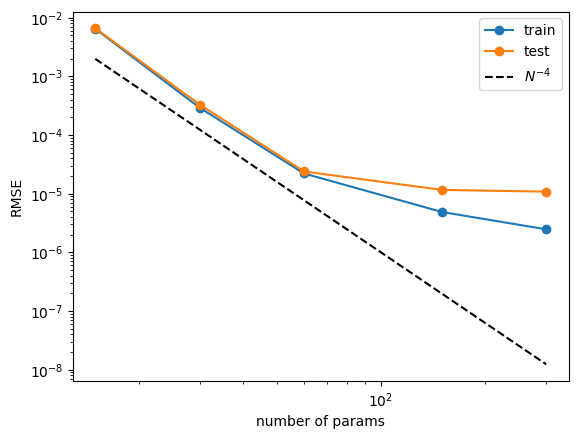

In [7]:
n_params = 3 * grids
train_vs_G = train_losses[(steps-1)::steps]
test_vs_G = test_losses[(steps-1)::steps]
plt.plot(n_params, train_vs_G, marker="o")
plt.plot(n_params, test_vs_G, marker="o")
plt.plot(n_params, 100*n_params**(-4.), ls="--", color="black")
plt.xscale('log')
plt.yscale('log')
plt.legend(['train', 'test', r'$N^{-4}$'])
plt.xlabel('number of params')
plt.ylabel('RMSE')

In [29]:
import torch
from utils.Kan.ex_kan import KAN, create_dataset

In [30]:
# create a KAN: 2D inputs, 1D output, and 5 hidden neurons. cubic spline (k=3), 5 grid intervals (grid=5).
model = KAN(width=[4,2,1,1], grid=3, k=3, seed=0)
f = lambda x: torch.exp((torch.sin(torch.pi*(x[:,[0]]**2+x[:,[1]]**2))+torch.sin(torch.pi*(x[:,[2]]**2+x[:,[3]]**2)))/2)
dataset = create_dataset(f, n_var=4, train_num=3000)

# train the model
model.train(dataset, opt="LBFGS", steps=20, lamb=0.001, lamb_entropy=2.);

train loss: 1.32e-02 | test loss: 1.32e-02 | reg: 6.74e+00 : 100%|██| 20/20 [00:03<00:00,  5.24it/s]


In [7]:
# create a KAN: 第一层（输入层）有 4 个神经元, 第二层有 2 个神经元, 第三层（输出层）有 1 个神经元。 cubic spline (k=3), 5 grid intervals (grid=5).
model = KAN(width=[4,2,1,1], grid=3, k=3, seed=0)
f = lambda x: torch.exp((torch.sin(torch.pi*(x[:,[0]]**2+x[:,[1]]**2))+torch.sin(torch.pi*(x[:,[2]]**2+x[:,[3]]**2)))/2)
dataset = create_dataset(f, n_var=4, train_num=3000)

# train the model
model.train(dataset, opt="LBFGS", steps=20, lamb=0.001, lamb_entropy=2.);

train loss: 1.25e-02 | test loss: 1.22e-02 | reg: 6.90e+00 : 100%|██| 20/20 [00:08<00:00,  2.46it/s]


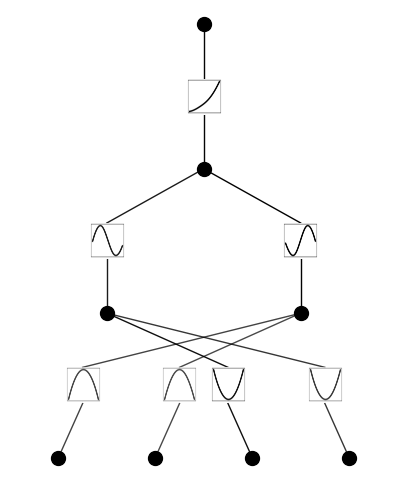

In [12]:
model.plot(beta = 10)

In [24]:
# it seems that removing edge manually does not change results too much. We include both for completeness.
remove_edge = True

if remove_edge == True:
    model.remove_edge(0,0,1)
    model.remove_edge(0,1,1)
    model.remove_edge(0,2,0)
    model.remove_edge(0,3,0)
else:
    pass

In [31]:
grids = [3,5,10,20,50]
#grids = [5]

train_rmse = []
test_rmse = []

for i in range(len(grids)):
    model = KAN(width=[4,2,1,1], grid=grids[i], k=3, seed=0).initialize_from_another_model(model, dataset['train_input'])
    results = model.train(dataset, opt="LBFGS", steps=50, stop_grid_update_step=30);
    train_rmse.append(results['train_loss'][-1].item())
    test_rmse.append(results['test_loss'][-1].item())

train loss: 4.99e-03 | test loss: 5.20e-03 | reg: 6.90e+00 : 100%|██| 50/50 [00:09<00:00,  5.36it/s]
train loss: 2.08e-03 | test loss: 2.10e-03 | reg: 6.97e+00 : 100%|██| 50/50 [00:12<00:00,  3.90it/s]
train loss: 1.50e-04 | test loss: 1.52e-04 | reg: 6.92e+00 : 100%|██| 50/50 [00:10<00:00,  4.89it/s]
train loss: 1.08e-05 | test loss: 1.01e-05 | reg: 6.92e+00 : 100%|██| 50/50 [00:08<00:00,  5.84it/s]
train loss: 3.47e-06 | test loss: 1.92e-06 | reg: 6.92e+00 : 100%|██| 50/50 [00:13<00:00,  3.60it/s]


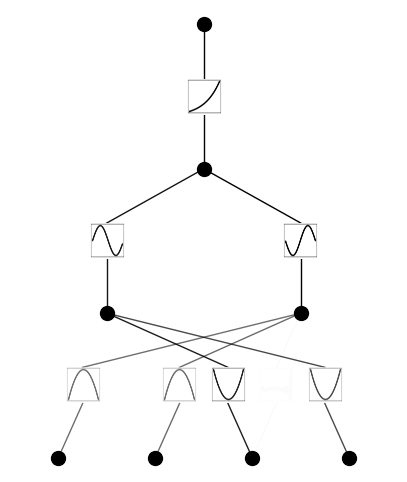

In [32]:
model.plot(beta = 10)

[0.004985550884157419, 0.0020759033504873514, 0.00014951586490496993, 1.0800052223203238e-05, 3.4744377899187384e-06]
[0.005199520383030176, 0.0021013382356613874, 0.00015170453116297722, 1.0094515346281696e-05, 1.924375737871742e-06]


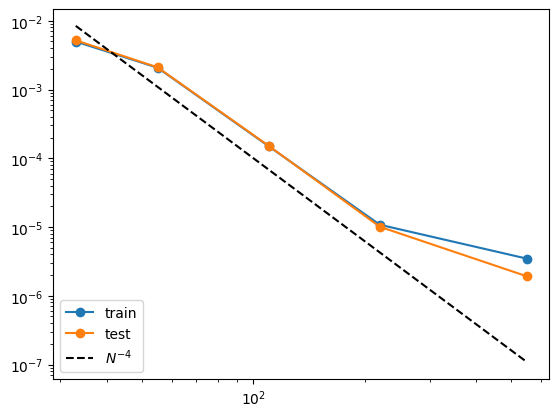

In [33]:
import numpy as np
import matplotlib.pyplot as plt

n_params = np.array(grids) * (4*2+2*1+1*1)
plt.plot(n_params, train_rmse, marker="o")
plt.plot(n_params, test_rmse, marker="o")
plt.plot(n_params, 10000*n_params**(-4.), color="black", ls="--")
plt.legend(['train', 'test', r'$N^{-4}$'], loc="lower left")
plt.xscale('log')
plt.yscale('log')
print(train_rmse)
print(test_rmse)

## Example 6: Solving Partial Differential Equation (PDE)

We aim to solve a 2D poisson equation $\nabla^2 f(x,y) = -2\pi^2{\rm sin}(\pi x){\rm sin}(\pi y)$, with boundary condition $f(-1,y)=f(1,y)=f(x,-1)=f(x,1)=0$. The ground truth solution is $f(x,y)={\rm sin}(\pi x){\rm sin}(\pi y)$.

In [ ]:
import torch
import matplotlib.pyplot as plt
from torch import autograd
from tqdm import tqdm
from utils.Kan.ex_kan import KAN, LBFGS

dim = 2
np_i = 21  # number of interior points (along each dimension)
np_b = 21  # number of boundary points (along each dimension)
ranges = [-1, 1]

model = KAN(width=[2, 2, 1], grid=5, k=3, grid_eps=1.0, noise_scale_base=0.25)


def batch_jacobian(func, x, create_graph=False):
    # x in shape (Batch, Length)
    def _func_sum(x):
        return func(x).sum(dim=0)

    return autograd.functional.jacobian(
        _func_sum, x, create_graph=create_graph
    ).permute(1, 0, 2)


# define solution
sol_fun = lambda x: torch.sin(torch.pi * x[:, [0]]) * torch.sin(torch.pi * x[:, [1]])
source_fun = (
    lambda x: -2
    * torch.pi**2
    * torch.sin(torch.pi * x[:, [0]])
    * torch.sin(torch.pi * x[:, [1]])
)

# interior
sampling_mode = "random"  # 'radnom' or 'mesh'

x_mesh = torch.linspace(ranges[0], ranges[1], steps=np_i)
y_mesh = torch.linspace(ranges[0], ranges[1], steps=np_i)
X, Y = torch.meshgrid(x_mesh, y_mesh, indexing="ij")
if sampling_mode == "mesh":
    # mesh
    x_i = torch.stack(
        [
            X.reshape(
                -1,
            ),
            Y.reshape(
                -1,
            ),
        ]
    ).permute(1, 0)
else:
    # random
    x_i = torch.rand((np_i**2, 2)) * 2 - 1

# boundary, 4 sides
helper = lambda X, Y: torch.stack(
    [
        X.reshape(
            -1,
        ),
        Y.reshape(
            -1,
        ),
    ]
).permute(1, 0)
xb1 = helper(X[0], Y[0])
xb2 = helper(X[-1], Y[0])
xb3 = helper(X[:, 0], Y[:, 0])
xb4 = helper(X[:, 0], Y[:, -1])
x_b = torch.cat([xb1, xb2, xb3, xb4], dim=0)

steps = 20
alpha = 0.1
log = 1


def train():
    optimizer = LBFGS(
        model.parameters(),
        lr=1,
        history_size=10,
        line_search_fn="strong_wolfe",
        tolerance_grad=1e-32,
        tolerance_change=1e-32,
        tolerance_ys=1e-32,
    )

    pbar = tqdm(range(steps), desc="description")

    for _ in pbar:

        def closure():
            global pde_loss, bc_loss
            optimizer.zero_grad()
            # interior loss
            sol = sol_fun(x_i)
            sol_D1_fun = lambda x: batch_jacobian(model, x, create_graph=True)[:, 0, :]
            sol_D1 = sol_D1_fun(x_i)
            sol_D2 = batch_jacobian(sol_D1_fun, x_i, create_graph=True)[:, :, :]
            lap = torch.sum(torch.diagonal(sol_D2, dim1=1, dim2=2), dim=1, keepdim=True)
            source = source_fun(x_i)
            pde_loss = torch.mean((lap - source) ** 2)

            # boundary loss
            bc_true = sol_fun(x_b)
            bc_pred = model(x_b)
            bc_loss = torch.mean((bc_pred - bc_true) ** 2)

            loss = alpha * pde_loss + bc_loss
            loss.backward()
            return loss

        if _ % 5 == 0 and _ < 50:
            model.update_grid_from_samples(x_i)

        optimizer.step(closure)
        sol = sol_fun(x_i)
        loss = alpha * pde_loss + bc_loss
        l2 = torch.mean((model(x_i) - sol) ** 2)

        if _ % log == 0:
            pbar.set_description(
                "pde loss: %.2e | bc loss: %.2e | l2: %.2e "
                % (
                    pde_loss.cpu().detach().numpy(),
                    bc_loss.cpu().detach().numpy(),
                    l2.detach().numpy(),
                )
            )


train()

### Get started with KANs

Initialize KAN

In [1]:
from kan import *
# create a KAN: 2D inputs, 1D output, and 5 hidden neurons. cubic spline (k=3), 5 grid intervals (grid=5).
model = KAN(width=[2,5,1], grid=5, k=3, seed=0)

Create dataset

In [2]:
# create dataset f(x,y) = exp(sin(pi*x)+y^2)
f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)
dataset = create_dataset(f, n_var=2)
dataset['train_input'].shape, dataset['train_label'].shape

(torch.Size([1000, 2]), torch.Size([1000, 1]))

Plot KAN at initialization

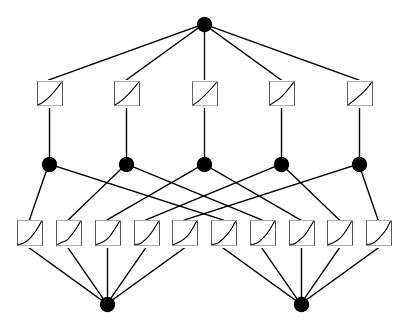

In [3]:
# plot KAN at initialization
model(dataset['train_input']);
model.plot(beta=100)

Train KAN with sparsity regularization

In [4]:
# train the model
model.train(dataset, opt="LBFGS", steps=20, lamb=0.01, lamb_entropy=10.)

train loss: 1.57e-01 | test loss: 1.31e-01 | reg: 2.05e+01 : 100%|██| 20/20 [00:18<00:00,  1.06it/s]


Plot trained KAN

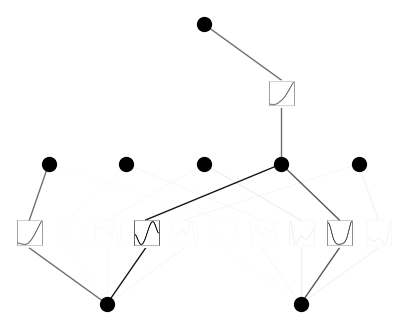

In [5]:
model.plot()

Prune KAN and replot (keep the original shape)

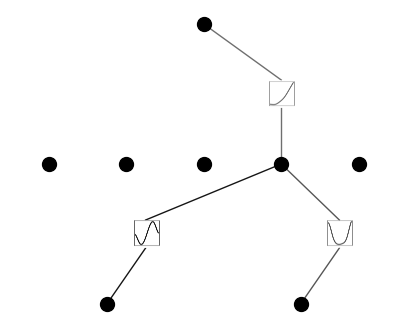

In [6]:
model.prune()
model.plot(mask=True)

Prune KAN and replot (get a smaller shape)

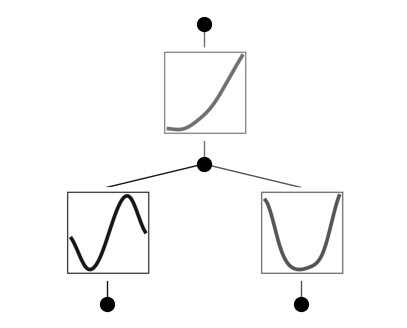

In [7]:
model = model.prune()
model(dataset['train_input'])
model.plot()

Continue training and replot

In [8]:
model.train(dataset, opt="LBFGS", steps=50);

train loss: 4.74e-03 | test loss: 4.80e-03 | reg: 2.98e+00 : 100%|██| 50/50 [00:07<00:00,  7.03it/s]


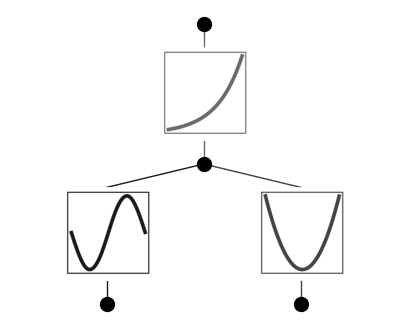

In [9]:
model.plot()

Automatically or manually set activation functions to be symbolic

In [10]:
mode = "auto" # "manual"

if mode == "manual":
    # manual mode
    model.fix_symbolic(0,0,0,'sin');
    model.fix_symbolic(0,1,0,'x^2');
    model.fix_symbolic(1,0,0,'exp');
elif mode == "auto":
    # automatic mode
    lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','abs']
    model.auto_symbolic(lib=lib)

fixing (0,0,0) with sin, r2=0.999987252534279
fixing (0,1,0) with x^2, r2=0.9999996536741071
fixing (1,0,0) with exp, r2=0.9999988529417926


Continue training to almost machine precision

In [11]:
model.train(dataset, opt="LBFGS", steps=50);

train loss: 2.02e-10 | test loss: 1.13e-10 | reg: 2.98e+00 : 100%|██| 50/50 [00:02<00:00, 22.59it/s]


Obtain the symbolic formula

In [12]:
model.symbolic_formula()[0][0]

1.0*exp(1.0*x_2**2 + 1.0*sin(3.14*x_1))

B样条曲线（B-spline curve）是一种广泛用于计算机图形学和CAD（计算机辅助设计）中的平滑曲线表示方法。它们由一组控制点定义，并具有良好的局部控制特性。以下是关于B样条曲线的详细讲解，包括数学表达。

### 1. 定义

B样条曲线是通过一组控制点和一个参数化的基函数来定义的。给定控制点 $P_0, P_1, \ldots, P_n$ 和一个非递减的节点向量 $U = [u_0, u_1, \ldots, u_{m+n+1}]$，B样条曲线 $C(u)$ 可以表示为：

$$
C(u) = \sum_{i=0}^{n} N_{i,k}(u) P_i
$$

其中：
- $N_{i,k}(u)$ 是第 $i$ 个控制点的 $k$ 次 B样条基函数。
- $P_i$ 是控制点。
- $k$ 是曲线的阶数。

### 2. 节点向量

节点向量 $U$ 是一个非递减的序列，定义了参数 $u$ 的区间和基函数的支持范围。节点向量的长度为 $m+n+1$，其中 $m$ 是节点的数量，$n$ 是控制点的数量。

### 3. B样条基函数

B样条基函数 $N_{i,k}(u)$ 是递归定义的。

#### 基函数的递归定义：

- **阶数 $k=0$**：
  $$
  N_{i,0}(u) = 
  \begin{cases}
    1, & \text{if } u_i \leq u < u_{i+1} \\
    0, & \text{otherwise}
  \end{cases}
  $$

- **阶数 $k \geq 1$**：
  $$
  N_{i,k}(u) = \frac{u - u_i}{u_{i+k} - u_i} N_{i,k-1}(u) + \frac{u_{i+k+1} - u}{u_{i+k+1} - u_{i+1}} N_{i+1,k-1}(u)
  $$

### 4. 性质

- **局部控制**：移动一个控制点只影响与该控制点相关的曲线部分。
- **非负性**：所有基函数的值都是非负的。
- **插值性**：当 $k \leq n$ 时，曲线通过第一个和最后一个控制点。

### 5. 示例

假设有四个控制点 $P_0, P_1, P_2, P_3$，并且使用节点向量 $U = [0, 0, 0, 1, 1, 1]$，这是一个二次B样条曲线（$k=2$）。

曲线表示为：

$$
C(u) = N_{0,2}(u) P_0 + N_{1,2}(u) P_1 + N_{2,2}(u) P_2 + N_{3,2}(u) P_3
$$

### 6. 应用

B样条曲线在计算机图形学、动画、CAD、曲面建模等领域得到了广泛应用，因其灵活性和高效性。

### 总结

B样条曲线通过控制点、节点向量和基函数的组合，提供了一种灵活的方式来表示平滑曲线。它的局部控制和非负性使得它在许多应用中非常有用。

在 B 样条曲线中，控制点的数量与网格大小（grid size）和样条阶数（degree）之间存在一定的关系。给定网格大小为 5 和样条阶数为 3，控制点的数量可以通过以下公式计算：

### 公式

控制点的数量 $n$ 与网格大小 $g$ 和样条阶数 $k$ 的关系为：

$$
n = g + k - 1
$$

### 计算

1. **网格大小**（grid size）$g = 5$。
2. **样条阶数**（degree）$k = 3$。

将这些值代入公式：

$$
n = 5 + 3 - 1 = 7
$$

### 结果

因此，B 样条曲线的控制点数量为 **7**。

## B-Splines for KAN

FLOPs: floating point operations